In [12]:
import colour

In [11]:
import bolift
import pandas as pd
import numpy as np
import os
import seaborn as sns
import cloudpickle

In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (5.0, 5.0 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

In [ ]:
# os.environ['OPENAI_API_KEY']= "<SECRET HERE>"

# RF baseline

## Experiment outputs

In [ ]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Temperature(C)', 'Doping(%)', 'Time(min)']).count()

In [ ]:
index = df.keys().tolist().index('Experiment')
features = df.keys()[:index]
labels = df.keys()[index+1:-6]
features, labels


## Spectra output

### Evaluate predictions

In [4]:
import numpy as np 

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

# bolift

In [5]:
import os
import cloudpickle
import bolift
import seaborn as sns
from dotenv import load_dotenv
load_dotenv("../.env", override=True)

False

In [ ]:
df = pd.read_csv('Data/procedures.tsv', sep="\t")
df = df[df['QY'] > 0]

import numpy as np
indexes = np.arange(len(df))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)

# plt.set_cmap('Dark2')
# train_df = df.iloc[indexes[:int(split*len(indexes))]]
# test_df = df.iloc[indexes[int(split*len(indexes)):]]
# train_indexes = train_df.index
# test_indexes = test_df.index

plt.set_cmap('viridis')
train_df = df[~df['Experiment'].str.startswith('M5') & ~df['Experiment'].str.startswith('M6')]
test_df = df[df['Experiment'].str.startswith('M5') | df['Experiment'].str.startswith('M6')]
train_indexes = train_df.index
test_indexes = test_df.index


with open('Data/system_message.txt', 'r') as f:
    system_message = f.read()

In [23]:
df

prompt         obj_f  peak1  \
0   Stock nanoplatelets have dimensions 18.8 nm by...  3.074970e-01  513.0   
1   Stock nanoplatelets have dimensions 18.8 nm by...  2.307426e-01  514.0   
2   Stock nanoplatelets have dimensions 18.8 nm by...  2.346841e-01  512.0   
3   Stock nanoplatelets have dimensions 18.8 nm by...  8.388796e-02  491.0   
4   Stock nanoplatelets have dimensions 18.8 nm by...  4.928815e-08  514.0   
..                                                ...           ...    ...   
69  Stock nanoplatelets have dimensions 26.437 nm ...           NaN    NaN   
70  Stock nanoplatelets have dimensions 35.064 nm ...           NaN    NaN   
71  Stock nanoplatelets have dimensions 26.577 nm ...           NaN    NaN   
72  Stock nanoplatelets have dimensions 26.437 nm ...           NaN    NaN   
73  Stock nanoplatelets have dimensions 35.064 nm ...           NaN    NaN   

    peak2      auc1      auc2        QY  
0   626.0  0.295030  0.611720  0.141195  
1   641.0  0.056906  0.706526  0.057943  
2   639.0  0.055621  0.741612  0.065100  
3   654.0  0.109129  0.606139  0.024582  
4   550.0  0.929356  0.062914  0.299366  
..    ...       ...       ...       ...  
69    NaN       NaN       NaN       NaN  
70    NaN       NaN       NaN       NaN  
71    NaN       NaN       NaN       NaN  
72    NaN       NaN       NaN       NaN  
73    NaN       NaN       NaN       NaN  

[74 rows x 7 columns]

## Predicting peaks

In [ ]:
asktell_peak1 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="first peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

asktell_peak2 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="second peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
    asktell_peak1.tell(df['Prompt'][i], df['Peak1'][i])

for i in train_indexes:
    asktell_peak2.tell(df['Prompt'][i], df['Peak2'][i])

## Predicting areas

In [330]:
asktell_auc1 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="area under the first peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

asktell_auc2 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="area under the second peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
    asktell_auc1.tell(df['Prompt'][i], df['Area1'][i])

for i in train_indexes:
    asktell_auc2.tell(df['Prompt'][i], df['Area2'][i])

In [331]:
# system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat_1=[]
yhat_2=[]
y_1=[]
y_2=[]
for i in test_indexes:
  yhat_1.append(asktell_auc1.predict(df['Prompt'][i], system_message=system_message))
  yhat_2.append(asktell_auc2.predict(df['Prompt'][i], system_message=system_message))
  y_1.append(df['Area1'][i])
  y_2.append(df['Area2'][i])
  print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['Area1'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {df['Area2'][i]}")


0.27+/-0.03 : 0.0159319452142701 // 0.68+/-0.06 : 0.907779872634646
0.55+/-0.16 : 0.2913299064067982 // 0.65+/-0.24 : 0.6885024396086137
0.31+/-0.09 : 0.3337016146713414 // 0.47+/-0.15 : 0.6590716491873605
0.53+/-0.17 : 0.6909245344307962 // 0.39+/-0.13 : 0.308120226065005
0.56+/-0.29 : 0.0401353753129296 // 0.63+/-0.13 : 0.8662336968256829
0.43+/-0.05 : 0.0776890168951515 // 0.65+/-0.21 : 0.8924789752206166
0.32+/-0.17 : 0.0354377223146335 // 0.69+/-0.08 : 0.9440783841615122
0.73+/-0.08 : 0.0059065831486889 // 0.54+/-0.08 : 0.9144309708802528
0.43+/-0.32 : 0.3233131794115474 // 0.87+/-0.01 : 0.6602438162860779
0.32+/-0.05 : 0.0148543538163129 // 0.72+/-0.06 : 0.9687313694156364
0.58+/-0.14 : 0.2490210867709846 // 0.70+/-0.27 : 0.7348353201818786
0.30+/-0.02 : 0.2756405406363365 // 0.41+/-0.11 : 0.7184085233104437
0.64+/-0.15 : 0.6621421362243245 // 0.33+/-0.01 : 0.3367027850028067
0.71+/-0.34 : 0.0329321133568393 // 0.63+/-0.13 : 0.9578560032652306
0.40+/-0.07 : 0.2953745724010526 // 

In [30]:
## Util function to save results (sorry, didnt save them originally, but now i need this to save from the print statements)
import re 
def parse_experiment_to_csv(input_text, output_file):
    data = []
    current_iteration = None
    pattern = re.compile(r"([\-\d.]+)\+/-([\-\d.]+)\s*:\s*([\-\de.]+)")
    f = input_text.split("\n")
    for line in f:
            line = line.strip()
            
            # Check if line indicates iteration
            if line.startswith("Iteration:"):
                # e.g. "Iteration:  0" -> split on ':' -> ["Iteration", "  0"]
                current_iteration = int(line.split(":")[1])
            
            else:
                # Attempt to match the "mean+/-std : label" pattern
                match = pattern.search(line)
                if match:
                    mean_str, std_str, label_str = match.groups()
                    
                    # Convert strings to float
                    mean_val = float(mean_str)
                    std_val  = float(std_str)
                    label_val = float(label_str)
                    
                    data.append({
                        "iteration": current_iteration,
                        "y_hats_mean": mean_val,
                        "y_hats_std": std_val,
                        "y_label": label_val
                    })

    # Create DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)

# Predicting AUC 2

In [457]:
rmses = []
y_hats = []
y_s = []
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."
seed = 1234
#randomly shuffle the dataset
indexes = np.arange(len(df))
np.random.shuffle(indexes)
#split the dataset into 5 folds
folds = np.array_split(indexes, 5)


for run in range(5):
    test_indexes = folds[run]
    train_indexes = np.concatenate([folds[i] for i in range(5) if i != run])

    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="relative area under the second peak in the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-3.5-turbo",
        selector_k=5,
        temperature=0.7
    )

    for i in train_indexes:
        asktell.tell(df['prompt'][i], df['auc2'][i])
    yhat_1=[]
    y_1=[]
    rmse = []
    print("-"*50)
    print("Iteration: ", run)
    print("-"*50)
    for i in test_indexes:
        yhat_1.append(asktell.predict(df['prompt'][i], system_message=system_message))
        y_1.append(df['auc2'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['auc2'][i]}")
        rmse.append(np.sqrt(np.mean((y_1[-1] - yhat_1[-1].mean())**2)))
    rmses.append(rmse)
    y_hats.append(yhat_1)
    y_s.append(y_1)

--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.23+/-0.02 : 0.2953657940256268
0.44+/-0.08 : 0.2624603965695792
0.15+/-0.07 : 0.0646916294698669
0.12+/-0.01 : 0.0841559783264317
0.25+/-0.14 : 0.1674772879866486
0.64+/-0.15 : 0.309699856985101
0.40+/-0.18 : 0.2912090093164146
0.23+/-0.17 : 0.1602385999202718
0.79+/-0.13 : 0.6061394078779798
0.58+/-0.16 : 0.4759055956414617
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.31+/-0.05 : 0.1733997206063347
0.20+/-0.05 : 0.2828481825878629
0.32+/-0.06 : 0.3066041093697584
0.39+/-0.03 : 0.1904586945757142
0.35+/-0.01 : 0.4427887184934959
0.37+/-0.02 : 0.4360718822353877
0.12+/-0.01 : 0.1422145013940117
0.12+/-0.07 : 0.3898966338880653
0.43+/-0.14 : 0.7812792246761073
0.13+/-0.22 : 0.2430953132155384
--------------------------------------------------
Iteration:  2
--------------------------------------------

In [466]:
results = """
--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.23+/-0.02 : 0.2953657940256268
0.44+/-0.08 : 0.2624603965695792
0.15+/-0.07 : 0.0646916294698669
0.12+/-0.01 : 0.0841559783264317
0.25+/-0.14 : 0.1674772879866486
0.64+/-0.15 : 0.309699856985101
0.40+/-0.18 : 0.2912090093164146
0.23+/-0.17 : 0.1602385999202718
0.79+/-0.13 : 0.6061394078779798
0.58+/-0.16 : 0.4759055956414617
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.31+/-0.05 : 0.1733997206063347
0.20+/-0.05 : 0.2828481825878629
0.32+/-0.06 : 0.3066041093697584
0.39+/-0.03 : 0.1904586945757142
0.35+/-0.01 : 0.4427887184934959
0.37+/-0.02 : 0.4360718822353877
0.12+/-0.01 : 0.1422145013940117
0.12+/-0.07 : 0.3898966338880653
0.43+/-0.14 : 0.7812792246761073
0.13+/-0.22 : 0.2430953132155384
--------------------------------------------------
Iteration:  2
--------------------------------------------------
0.45+/-0.05 : 0.6117197488991221
0.34+/-0.25 : 0.0354598411446561
0.08+/-0.21 : 0.1696641317572414
0.39+/-0.01 : 0.3523473169828111
0.41+/-0.04 : 0.4256909053862968
0.10+/-0.02 : 0.0629136968193054
0.24+/-0.06 : 0.0689583402864335
0.46+/-0.10 : 0.4977212392516333
0.61+/-0.02 : 0.6566887305341638
0.12+/-0.03 : 0.1142177798758055
--------------------------------------------------
Iteration:  3
--------------------------------------------------
0.15+/-0.06 : 0.3751014820313336
0.13+/-0.02 : 0.131806215275276
0.11+/-0.07 : 0.0573401540691778
0.65+/-0.13 : 0.3023466413296236
0.90+/-0.10 : 0.4682733133999453
0.61+/-0.03 : 0.2154666786668164
0.39+/-0.22 : 0.250379623570074
0.38+/-0.06 : 0.4033964535292222
0.49+/-0.11 : 0.647637234704595
0.33+/-0.03 : 0.1918322992353092
--------------------------------------------------
Iteration:  4
--------------------------------------------------
0.27+/-0.12 : 0.7065256284519555
0.36+/-0.15 : 0.4151376833035197
0.27+/-0.06 : 0.1340448058009197
0.14+/-0.03 : 0.0840665229012216
0.52+/-0.26 : 0.7402359425318793
0.88+/-0.06 : 0.7245213667611271
0.19+/-0.04 : 0.1726803805931685
0.29+/-0.07 : 0.0764399145895817
0.25+/-0.01 : 0.4362107682667612
0.55+/-0.15 : 0.7416118477580256
"""
file_path = "Data/cv_auc2_gpt35_turbo.csv"
parse_experiment_to_csv(results, file_path)

Run 0: 0.149
Run 1: 0.170
Run 2: 0.128
Run 3: 0.241
Run 4: 0.201


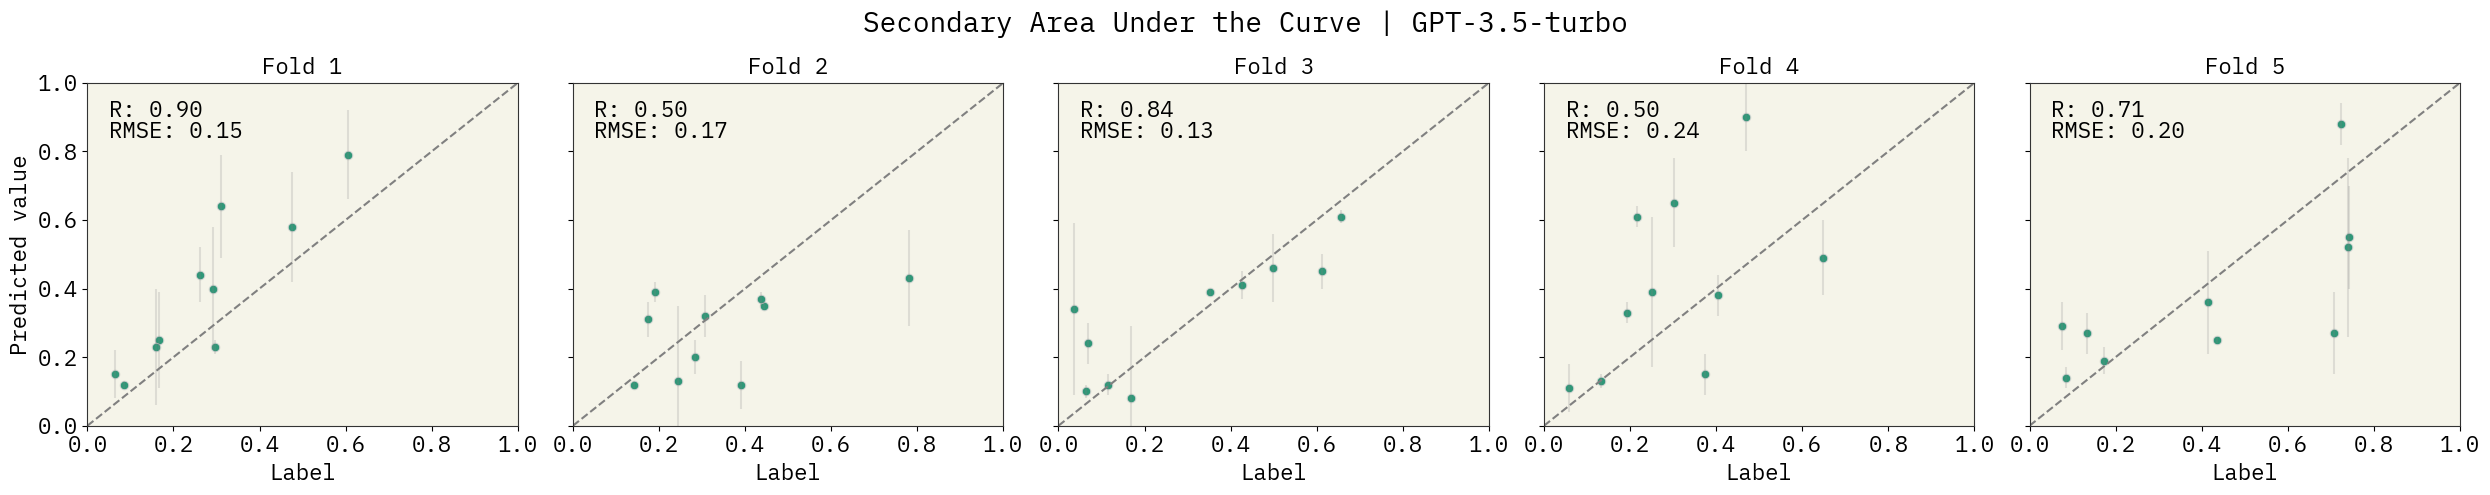

In [467]:
#load the data
df = pd.read_csv("Data/cv_auc2_gpt35_turbo.csv")
y_hats = df['y_hats_mean'].groupby(df['iteration']).apply(list).values
y_labels = df['y_label'].groupby(df['iteration']).apply(list).values
y_hats_std = df['y_hats_std'].groupby(df['iteration']).apply(list).values
fig, axs = plt.subplots(1, 5, figsize=(25,5 ), sharex=True, sharey=True)

for i, (y_1, yhat_1, y_std,ax) in enumerate(zip(y_labels, y_hats, y_hats_std,axs)):
    rmse = np.sqrt(np.mean((y_1 - np.array(yhat_1))**2))
    print(f"Run {i}: {rmse:.3f}")
    
    ax.set_title(f"Fold {i+1}", fontsize=16)
    sns.scatterplot(x=y_1, y= yhat_1, ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=   yhat_1, yerr= y_std, fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    ax.text(0.05, 0.90, f"R: {np.corrcoef(y_1, yhat_1)[0, 1]:.2f}", transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.84, f"RMSE: {rmse:.2f}", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Predicted value", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #increase ticks labels size
    ax.tick_params(axis='both', which='major', labelsize=16)
    #sup title Secondary Area Under the Curve | GPT-4o
    fig.suptitle("Secondary Area Under the Curve | GPT-3.5-turbo", fontsize=20)

plt.tight_layout()
plt.show()
plt.show()

In [456]:
#set random seed 
import time
rmses = []
y_hats = []
y_s = []
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."
seed = 1234
#randomly shuffle the dataset
indexes = np.arange(len(df))
np.random.shuffle(indexes)
#split the dataset into 5 folds
folds = np.array_split(indexes, 5)


for run in range(5):
    test_indexes = folds[run]
    train_indexes = np.concatenate([folds[i] for i in range(5) if i != run])

    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="area under the second peak in the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7
    )

    for i in train_indexes:
        asktell.tell(df['prompt'][i], df['auc2'][i])
    yhat_1=[]
    y_1=[]
    rmse = []
    print("-"*50)
    print("Iteration: ", run)
    print("-"*50)
    for i in test_indexes:
        yhat_1.append(asktell.predict(df['prompt'][i], system_message=system_message))
        y_1.append(df['auc2'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['auc2'][i]}")
        rmse.append(np.sqrt(np.mean((y_1[-1] - yhat_1[-1].mean())**2)))
    rmses.append(rmse)
    y_hats.append(yhat_1)
    y_s.append(y_1)

--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.24+/-0.04 : 0.2624603965695792
0.29+/-0.02 : 0.3023466413296236
0.16+/-0.08 : 0.0646916294698669
0.33+/-0.02 : 0.1918322992353092
0.33+/-0.01 : 0.0573401540691778
0.31+/-0.01 : 0.3751014820313336
0.14+/-0.00 : 0.1340448058009197
0.93+/-0.12 : 0.7245213667611271
0.31+/-0.08 : 0.3066041093697584
0.36+/-0.13 : 0.7402359425318793
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.10+/-0.01 : 0.1674772879866486
0.52+/-0.07 : 0.2154666786668164
0.11+/-0.02 : 0.1726803805931685
0.27+/-0.02 : 0.1904586945757142
0.35+/-0.07 : 0.1696641317572414
0.14+/-0.01 : 0.3898966338880653
0.56+/-0.04 : 0.7416118477580256
0.43+/-0.01 : 0.4033964535292222
0.55+/-0.00 : 0.309699856985101
0.61+/-0.02 : 0.7065256284519555
--------------------------------------------------
Iteration:  2
--------------------------------------------

In [464]:
results = """
--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.24+/-0.04 : 0.2624603965695792
0.29+/-0.02 : 0.3023466413296236
0.16+/-0.08 : 0.0646916294698669
0.33+/-0.02 : 0.1918322992353092
0.33+/-0.01 : 0.0573401540691778
0.31+/-0.01 : 0.3751014820313336
0.14+/-0.00 : 0.1340448058009197
0.93+/-0.12 : 0.7245213667611271
0.31+/-0.08 : 0.3066041093697584
0.36+/-0.13 : 0.7402359425318793
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.10+/-0.01 : 0.1674772879866486
0.52+/-0.07 : 0.2154666786668164
0.11+/-0.02 : 0.1726803805931685
0.27+/-0.02 : 0.1904586945757142
0.35+/-0.07 : 0.1696641317572414
0.14+/-0.01 : 0.3898966338880653
0.56+/-0.04 : 0.7416118477580256
0.43+/-0.01 : 0.4033964535292222
0.55+/-0.00 : 0.309699856985101
0.61+/-0.02 : 0.7065256284519555
--------------------------------------------------
Iteration:  2
--------------------------------------------------
0.56+/-0.10 : 0.4360718822353877
0.33+/-0.02 : 0.6117197488991221
0.17+/-0.03 : 0.0764399145895817
0.36+/-0.11 : 0.250379623570074
0.28+/-0.01 : 0.2912090093164146
0.13+/-0.05 : 0.1422145013940117
0.24+/-0.11 : 0.2828481825878629
0.17+/-0.02 : 0.131806215275276
0.28+/-0.22 : 0.4427887184934959
0.10+/-0.02 : 0.0689583402864335
--------------------------------------------------
Iteration:  3
--------------------------------------------------
0.11+/-0.01 : 0.0629136968193054
0.37+/-0.02 : 0.3523473169828111
0.30+/-0.06 : 0.647637234704595
0.17+/-0.01 : 0.2430953132155384
0.23+/-0.06 : 0.1602385999202718
0.19+/-0.08 : 0.4151376833035197
0.04+/-0.01 : 0.0354598411446561
0.20+/-0.03 : 0.2953657940256268
0.10+/-0.01 : 0.1142177798758055
0.11+/-0.01 : 0.0841559783264317
--------------------------------------------------
Iteration:  4
--------------------------------------------------
0.52+/-0.03 : 0.7812792246761073
0.51+/-0.08 : 0.4977212392516333
0.38+/-0.05 : 0.4362107682667612
0.34+/-0.01 : 0.4759055956414617
0.07+/-0.01 : 0.0840665229012216
0.40+/-0.01 : 0.4682733133999453
0.12+/-0.01 : 0.1733997206063347
0.45+/-0.02 : 0.4256909053862968
0.83+/-0.02 : 0.6061394078779798
0.81+/-0.04 : 0.6566887305341638
"""
file_path = "Data/cv_auc2_gpt4o.csv"
parse_experiment_to_csv(results, file_path)

Run 0: 0.172
Run 1: 0.174
Run 2: 0.121
Run 3: 0.139
Run 4: 0.131


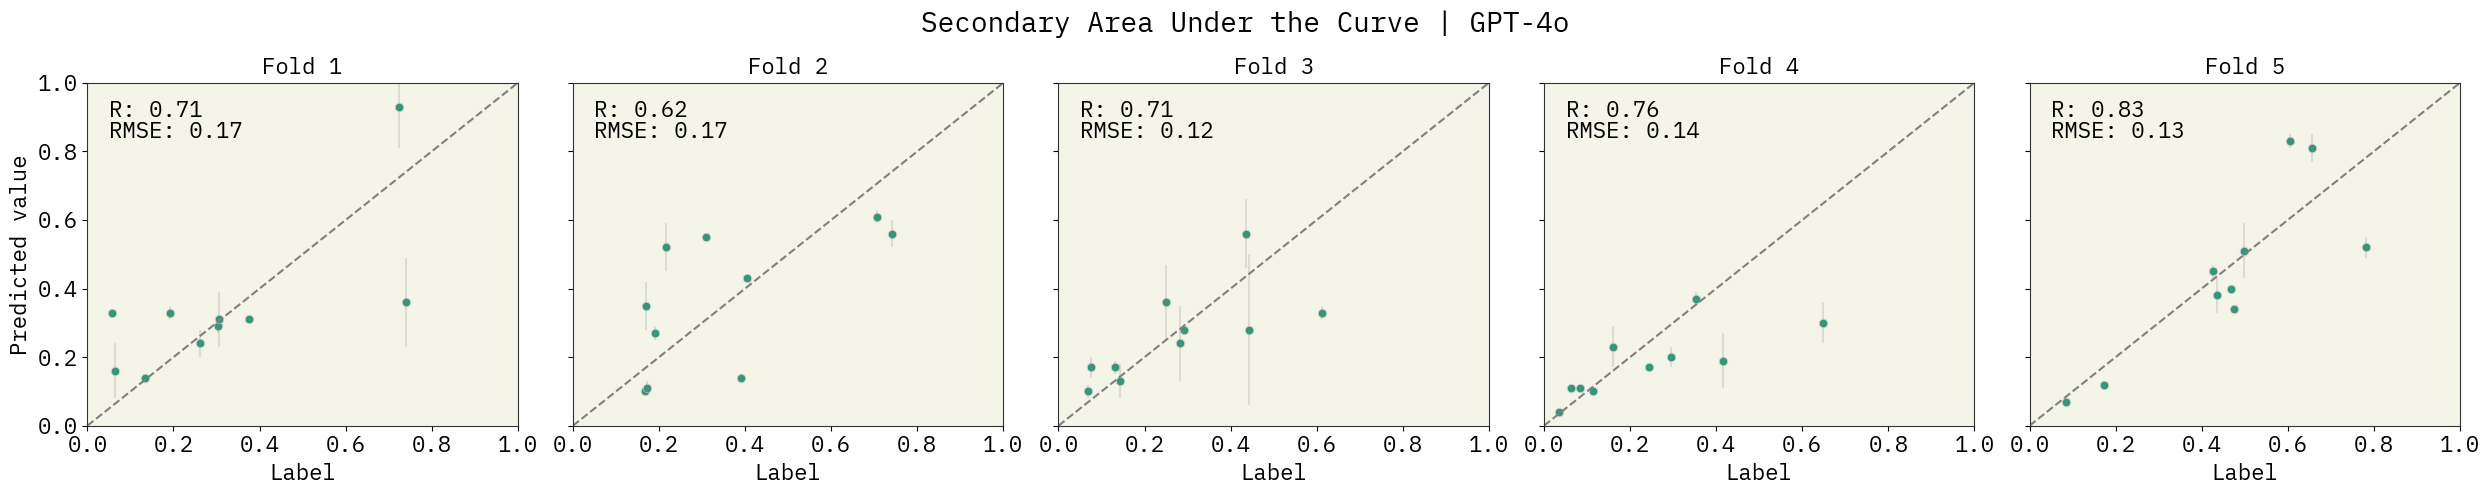

In [465]:
#load the data
df = pd.read_csv("Data/cv_auc2_gpt4o.csv")
y_hats = df['y_hats_mean'].groupby(df['iteration']).apply(list).values
y_labels = df['y_label'].groupby(df['iteration']).apply(list).values
y_hats_std = df['y_hats_std'].groupby(df['iteration']).apply(list).values
fig, axs = plt.subplots(1, 5, figsize=(25,5 ), sharex=True, sharey=True)

for i, (y_1, yhat_1, y_std,ax) in enumerate(zip(y_labels, y_hats, y_hats_std,axs)):
    rmse = np.sqrt(np.mean((y_1 - np.array(yhat_1))**2))
    print(f"Run {i}: {rmse:.3f}")
    
    ax.set_title(f"Fold {i+1}", fontsize=16)
    sns.scatterplot(x=y_1, y= yhat_1, ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=   yhat_1, yerr= y_std, fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    ax.text(0.05, 0.90, f"R: {np.corrcoef(y_1, yhat_1)[0, 1]:.2f}", transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.84, f"RMSE: {rmse:.2f}", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Predicted value", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #increase ticks labels size
    ax.tick_params(axis='both', which='major', labelsize=16)
    #sup title Secondary Area Under the Curve | GPT-4o
    fig.suptitle("Secondary Area Under the Curve | GPT-4o", fontsize=20)

plt.tight_layout()
plt.show()
plt.show()

## Predicting QY

In [435]:
df = pd.read_csv('Data/procedures_prompts.tsv', sep="\t")
df.head()

prompt         obj_f  peak1  \
0  Stock nanoplatelets have dimensions 18.8 nm by...  3.074970e-01  513.0   
1  Stock nanoplatelets have dimensions 18.8 nm by...  2.307426e-01  514.0   
2  Stock nanoplatelets have dimensions 18.8 nm by...  2.346841e-01  512.0   
3  Stock nanoplatelets have dimensions 18.8 nm by...  8.388796e-02  491.0   
4  Stock nanoplatelets have dimensions 18.8 nm by...  4.928815e-08  514.0   

   peak2      auc1      auc2        QY  
0  626.0  0.295030  0.611720  0.141195  
1  641.0  0.056906  0.706526  0.057943  
2  639.0  0.055621  0.741612  0.065100  
3  654.0  0.109129  0.606139  0.024582  
4  550.0  0.929356  0.062914  0.299366

In [436]:
#take only first 50 points (original dataset)
df = df.iloc[:50]
print(len(df))
df.tail()

50


prompt         obj_f  peak1  \
45  Stock nanoplatelets have dimensions 45.77 nm b...  3.609710e-23  511.0   
46  Stock nanoplatelets have dimensions 45.77 nm b...  6.495031e-02  511.0   
47  Stock nanoplatelets have dimensions 45.77 nm b...  2.634259e-23  511.0   
48  Stock nanoplatelets have dimensions 46.3494 nm...  5.209272e-01  512.0   
49  Stock nanoplatelets have dimensions 36.9235 nm...  2.428102e-03  511.0   

    peak2      auc1      auc2        QY  
45  609.0  0.916222  0.068958  0.096244  
46  613.0  0.709605  0.250380  0.078262  
47  621.0  0.906897  0.076440  0.091762  
48  650.0  0.037484  0.740236  0.101877  
49  550.0  0.958160  0.035460  0.000001

In [455]:
#set random seed 
import time
rmses = []
y_hats = []
y_s = []
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."
seed = 1234
#randomly shuffle the dataset
indexes = np.arange(len(df))
np.random.shuffle(indexes)
#split the dataset into 5 folds
folds = np.array_split(indexes, 5)


for run in range(5):
    test_indexes = folds[run]
    train_indexes = np.concatenate([folds[i] for i in range(5) if i != run])

    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="quantum yield of the last experiment",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7
    )

    for i in train_indexes:
        asktell.tell(df['prompt'][i], df['QY'][i])
    yhat_1=[]
    y_1=[]
    rmse = []
    print("-"*50)
    print("Iteration: ", run)
    print("-"*50)
    for i in test_indexes:
        yhat_1.append(asktell.predict(df['prompt'][i], system_message=system_message))
        y_1.append(df['QY'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['QY'][i]}")
        rmse.append(np.sqrt(np.mean((y_1[-1] - yhat_1[-1].mean())**2)))
    rmses.append(rmse)
    y_hats.append(yhat_1)
    y_s.append(y_1)

--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.40+/-0.02 : 0.6001187212109055
0.12+/-0.02 : 0.1411951625968577
0.11+/-0.02 : 0.0671820110463102
0.30+/-0.06 : 0.0560141258979956
0.02+/-0.00 : 0.0561038024162386
0.15+/-0.00 : 0.1188516483657638
0.45+/-0.03 : 0.3344876494548325
0.10+/-0.04 : 0.0782617533287777
0.17+/-0.01 : 0.1496474808092574
0.20+/-0.03 : 0.42850390614647
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.15+/-0.01 : 0.1018774812239877
0.46+/-0.04 : 0.4533763064141378
0.09+/-0.02 : 0.1011158776886467
0.21+/-0.01 : 0.2993663829142426
0.12+/-0.00 : 0.1474852581793888
0.03+/-0.00 : 0.0245816424033565
0.21+/-0.04 : 0.2207958402559034
0.16+/-0.02 : 0.2308475209588556
0.12+/-0.15 : 0.0899251906930338
0.65+/-0.15 : 0.3253356923326964
--------------------------------------------------
Iteration:  2
---------------------------------------------

In [468]:
save_file = "Data/cv_qy_gpt4o.csv"
results = """
--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.40+/-0.02 : 0.6001187212109055
0.12+/-0.02 : 0.1411951625968577
0.11+/-0.02 : 0.0671820110463102
0.30+/-0.06 : 0.0560141258979956
0.02+/-0.00 : 0.0561038024162386
0.15+/-0.00 : 0.1188516483657638
0.45+/-0.03 : 0.3344876494548325
0.10+/-0.04 : 0.0782617533287777
0.17+/-0.01 : 0.1496474808092574
0.20+/-0.03 : 0.42850390614647
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.15+/-0.01 : 0.1018774812239877
0.46+/-0.04 : 0.4533763064141378
0.09+/-0.02 : 0.1011158776886467
0.21+/-0.01 : 0.2993663829142426
0.12+/-0.00 : 0.1474852581793888
0.03+/-0.00 : 0.0245816424033565
0.21+/-0.04 : 0.2207958402559034
0.16+/-0.02 : 0.2308475209588556
0.12+/-0.15 : 0.0899251906930338
0.65+/-0.15 : 0.3253356923326964
--------------------------------------------------
Iteration:  2
--------------------------------------------------
0.15+/-0.00 : 0.0917619661282155
0.23+/-0.02 : 0.1751337507694327
0.18+/-0.01 : 0.138291775761419
0.12+/-0.15 : 0.1075117822038666
0.39+/-0.08 : 0.4109752631486212
0.60+/-0.23 : 1.118667773375044e-06
0.05+/-0.01 : 0.0170738286261515
0.12+/-0.00 : 0.0789863457585547
0.25+/-0.04 : 0.2386061913314964
0.16+/-0.03 : 0.109912231193349
--------------------------------------------------
Iteration:  3
--------------------------------------------------
0.05+/-0.00 : 0.103709286202787
0.04+/-0.01 : 0.051461672754283
0.10+/-0.00 : 0.065100207526833
0.45+/-0.06 : 0.4180703494488649
0.26+/-0.01 : 0.2367575321820904
0.11+/-0.01 : 0.0579425782072234
0.10+/-0.03 : 0.4416344919133096
0.14+/-0.01 : 0.1627421037874981
0.59+/-0.09 : 0.4039813397451247
0.05+/-0.01 : 0.0962444512754384
--------------------------------------------------
Iteration:  4
--------------------------------------------------
0.40+/-0.06 : 0.4530884922585037
0.04+/-0.01 : 0.0459342000056323
0.07+/-0.02 : 0.0974985692674476
0.17+/-0.01 : 0.2422532881260777
0.39+/-0.08 : 0.1916920635282294
0.15+/-0.03 : 0.1102106401529744
0.18+/-0.06 : 0.183164469448393
0.07+/-0.02 : 0.020962473350054
0.13+/-0.04 : 0.1220939258243236
0.16+/-0.00 : 0.1287444064052028
"""
parse_experiment_to_csv(results, save_file)

Run 0: 0.131
Run 1: 0.111
Run 2: 0.193
Run 3: 0.127
Run 4: 0.073


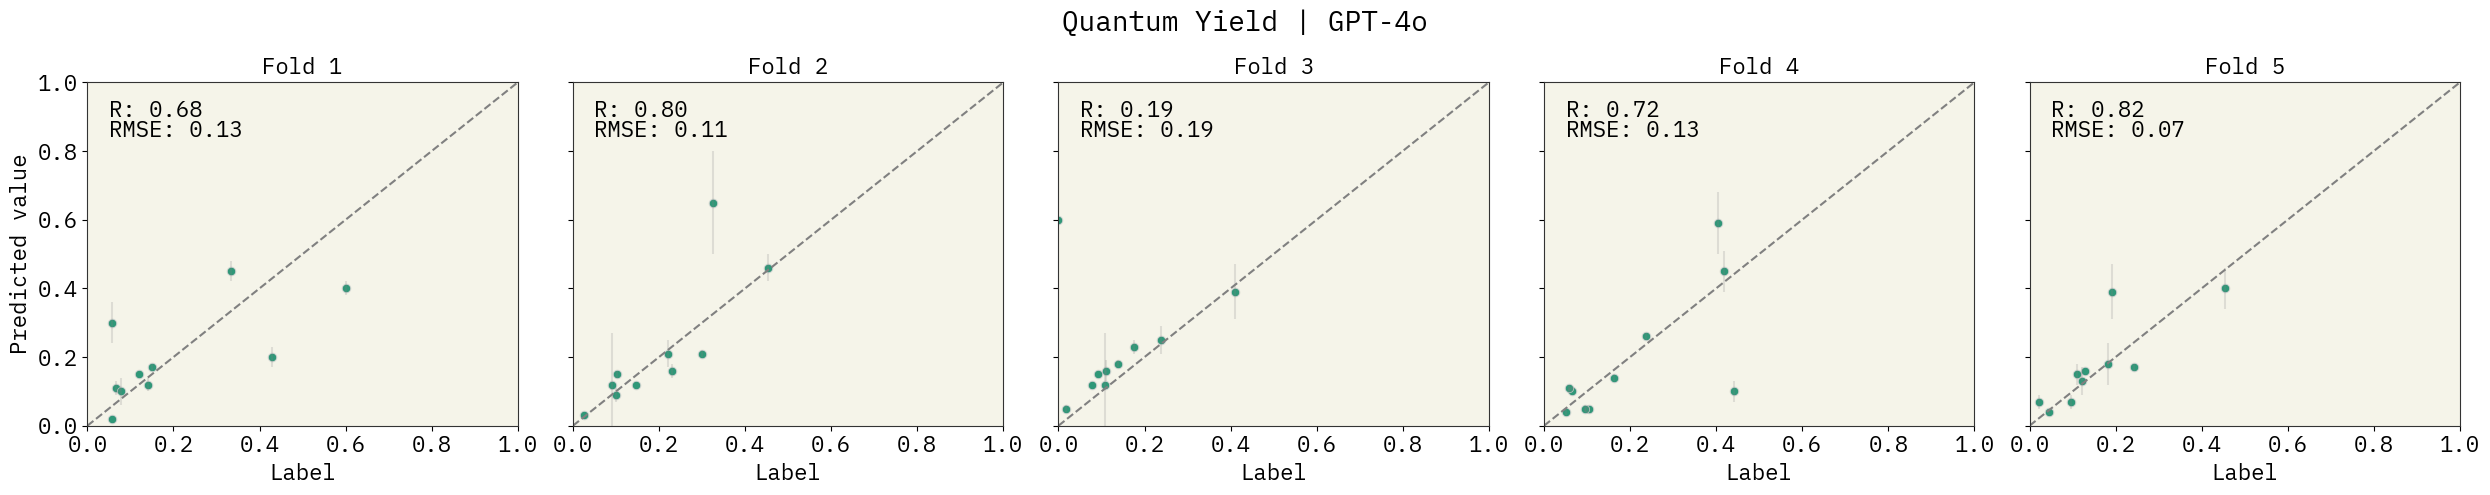

In [469]:
#load the data
df = pd.read_csv("Data/cv_qy_gpt4o.csv")
y_hats = df['y_hats_mean'].groupby(df['iteration']).apply(list).values
y_labels = df['y_label'].groupby(df['iteration']).apply(list).values
y_hats_std = df['y_hats_std'].groupby(df['iteration']).apply(list).values
fig, axs = plt.subplots(1, 5, figsize=(25,5 ), sharex=True, sharey=True)

for i, (y_1, yhat_1, y_std,ax) in enumerate(zip(y_labels, y_hats, y_hats_std,axs)):
    rmse = np.sqrt(np.mean((y_1 - np.array(yhat_1))**2))
    print(f"Run {i}: {rmse:.3f}")
    
    ax.set_title(f"Fold {i+1}", fontsize=16)
    sns.scatterplot(x=y_1, y= yhat_1, ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=   yhat_1, yerr= y_std, fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    ax.text(0.05, 0.90, f"R: {np.corrcoef(y_1, yhat_1)[0, 1]:.2f}", transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.84, f"RMSE: {rmse:.2f}", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Predicted value", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #increase ticks labels size
    ax.tick_params(axis='both', which='major', labelsize=16)
    #sup title Quantum Yield | GPT-4o
    fig.suptitle("Quantum Yield | GPT-4o", fontsize=20)

plt.tight_layout()
plt.show()
plt.show()

In [454]:
#set random seed 
import time
import time
rmses = []
y_hats = []
y_s = []
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."
seed = 1234
#randomly shuffle the dataset
indexes = np.arange(len(df))
np.random.shuffle(indexes)
#split the dataset into 5 folds
folds = np.array_split(indexes, 5)


for run in range(5):
    test_indexes = folds[run]
    train_indexes = np.concatenate([folds[i] for i in range(5) if i != run])

    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="quantum yield of the last experiment",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-3.5-turbo",
        selector_k=5,
        temperature=0.7
    )

    for i in train_indexes:
        asktell.tell(df['prompt'][i], df['QY'][i])
    yhat_1=[]
    y_1=[]
    rmse = []
    print("-"*50)
    print("Iteration: ", run)
    print("-"*50)
    for i in test_indexes:
        try:
            pred = asktell.predict(df['prompt'][i], system_message=system_message)
        except Exception as e:
            time.sleep(10)
            print(f"Exception skipping prediction")
            continue

        yhat_1.append(pred)
        y_1.append(df['QY'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['QY'][i]}")
        rmse.append(np.sqrt(np.mean((y_1[-1] - yhat_1[-1].mean())**2)))
    rmses.append(rmse)
    y_hats.append(yhat_1)
    y_s.append(y_1)

--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.09+/-0.01 : 0.0671820110463102
0.56+/-0.04 : 0.3253356923326964
0.09+/-0.14 : 0.0789863457585547
0.63+/-0.26 : 1.118667773375044e-06
0.10+/-0.14 : 0.0782617533287777
0.05+/-0.01 : 0.0561038024162386
0.55+/-0.06 : 0.4530884922585037
0.11+/-0.02 : 0.1188516483657638
0.08+/-0.01 : 0.2207958402559034
0.26+/-0.11 : 0.42850390614647
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.60+/-0.09 : 0.4039813397451247
0.13+/-0.05 : 0.1102106401529744
0.15+/-0.05 : 0.1075117822038666
0.04+/-0.01 : 0.1411951625968577
0.09+/-0.05 : 0.065100207526833
0.13+/-0.01 : 0.109912231193349
0.16+/-0.08 : 0.138291775761419
0.54+/-0.08 : 0.4109752631486212
0.04+/-0.01 : 0.1496474808092574
0.11+/-0.03 : 0.0974985692674476
--------------------------------------------------
Iteration:  2
---------------------------------------------

In [462]:
results = """
--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.09+/-0.01 : 0.0671820110463102
0.56+/-0.04 : 0.3253356923326964
0.09+/-0.14 : 0.0789863457585547
0.63+/-0.26 : 1.118667773375044e-06
0.10+/-0.14 : 0.0782617533287777
0.05+/-0.01 : 0.0561038024162386
0.55+/-0.06 : 0.4530884922585037
0.11+/-0.02 : 0.1188516483657638
0.08+/-0.01 : 0.2207958402559034
0.26+/-0.11 : 0.42850390614647
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.60+/-0.09 : 0.4039813397451247
0.13+/-0.05 : 0.1102106401529744
0.15+/-0.05 : 0.1075117822038666
0.04+/-0.01 : 0.1411951625968577
0.09+/-0.05 : 0.065100207526833
0.13+/-0.01 : 0.109912231193349
0.16+/-0.08 : 0.138291775761419
0.54+/-0.08 : 0.4109752631486212
0.04+/-0.01 : 0.1496474808092574
0.11+/-0.03 : 0.0974985692674476
--------------------------------------------------
Iteration:  2
--------------------------------------------------
0.09+/-0.03 : 0.1751337507694327
0.58+/-0.03 : 0.1916920635282294
0.40+/-0.08 : 0.183164469448393
0.22+/-0.01 : 0.1287444064052028
0.13+/-0.06 : 0.0899251906930338
0.10+/-0.02 : 0.1011158776886467
0.15+/-0.05 : 0.103709286202787
0.45+/-0.03 : 0.3344876494548325
0.12+/-0.03 : 0.2308475209588556
0.43+/-0.00 : 0.0560141258979956
--------------------------------------------------
Iteration:  3
--------------------------------------------------
0.42+/-0.01 : 0.4180703494488649
0.09+/-0.02 : 0.2367575321820904
0.39+/-0.04 : 0.6001187212109055
0.08+/-0.04 : 0.0579425782072234
0.41+/-0.06 : 0.4533763064141378
0.12+/-0.04 : 0.2993663829142426
0.14+/-0.05 : 0.2422532881260777
0.07+/-0.02 : 0.1627421037874981
0.10+/-0.02 : 0.4416344919133096
0.09+/-0.01 : 0.020962473350054
--------------------------------------------------
Iteration:  4
--------------------------------------------------
0.10+/-0.09 : 0.1220939258243236
0.17+/-0.01 : 0.0917619661282155
0.26+/-0.05 : 0.051461672754283
0.27+/-0.06 : 0.1018774812239877
0.14+/-0.03 : 0.0459342000056323
0.11+/-0.02 : 0.1474852581793888
0.04+/-0.04 : 0.0962444512754384
0.24+/-0.06 : 0.0245816424033565
0.09+/-0.03 : 0.0170738286261515
0.23+/-0.05 : 0.2386061913314964
"""
save_file = "Data/cv_qy_gpt35turbo.csv"
parse_experiment_to_csv(results, save_file)

Run 0: 0.226
Run 1: 0.090
Run 2: 0.196
Run 3: 0.155
Run 4: 0.120


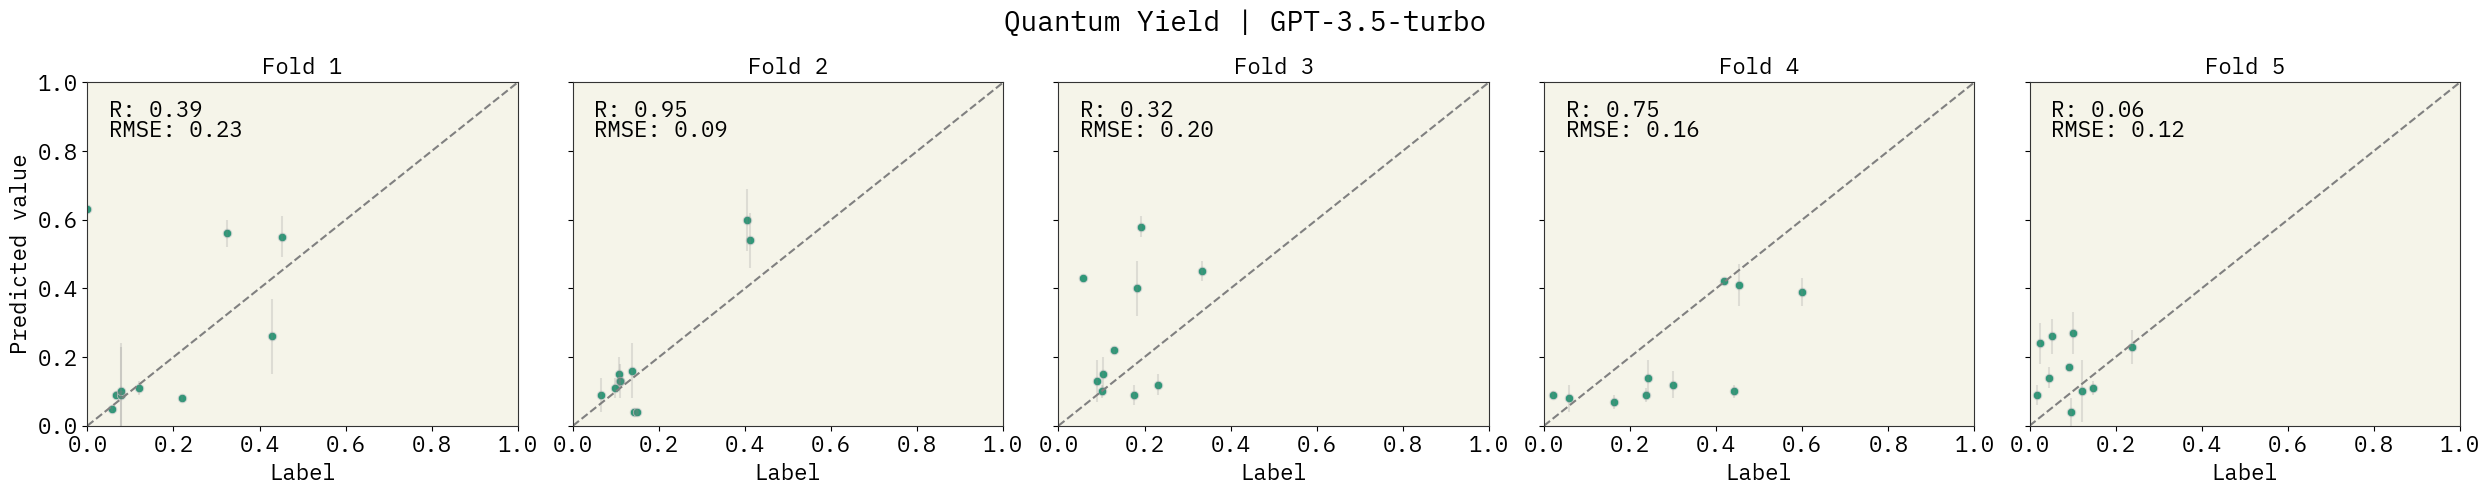

In [463]:
#load the data
df = pd.read_csv("Data/cv_qy_gpt35turbo.csv")
y_hats = df['y_hats_mean'].groupby(df['iteration']).apply(list).values
y_labels = df['y_label'].groupby(df['iteration']).apply(list).values
y_hats_std = df['y_hats_std'].groupby(df['iteration']).apply(list).values
fig, axs = plt.subplots(1, 5, figsize=(25,5 ), sharex=True, sharey=True)

for i, (y_1, yhat_1, y_std,ax) in enumerate(zip(y_labels, y_hats, y_hats_std,axs)):
    rmse = np.sqrt(np.mean((y_1 - np.array(yhat_1))**2))
    print(f"Run {i}: {rmse:.3f}")
    
    ax.set_title(f"Fold {i+1}", fontsize=16)
    sns.scatterplot(x=y_1, y= yhat_1, ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=   yhat_1, yerr= y_std, fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    ax.text(0.05, 0.90, f"R: {np.corrcoef(y_1, yhat_1)[0, 1]:.2f}", transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.84, f"RMSE: {rmse:.2f}", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Predicted value", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #increase ticks labels size
    ax.tick_params(axis='both', which='major', labelsize=16)
    #sup title Quantum Yield | GPT-3.5-turbo
    fig.suptitle("Quantum Yield | GPT-3.5-turbo", fontsize=20)

plt.tight_layout()
plt.show()


## Predicting f=QY*AUC2

In [54]:
df = pd.read_csv('Data/procedures_prompts.tsv', sep="\t")
df.head()

prompt         obj_f  peak1  \
0  Stock nanoplatelets have dimensions 18.8 nm by...  3.074970e-01  513.0   
1  Stock nanoplatelets have dimensions 18.8 nm by...  2.307426e-01  514.0   
2  Stock nanoplatelets have dimensions 18.8 nm by...  2.346841e-01  512.0   
3  Stock nanoplatelets have dimensions 18.8 nm by...  8.388796e-02  491.0   
4  Stock nanoplatelets have dimensions 18.8 nm by...  4.928815e-08  514.0   

   peak2      auc1      auc2        QY  
0  626.0  0.295030  0.611720  0.141195  
1  641.0  0.056906  0.706526  0.057943  
2  639.0  0.055621  0.741612  0.065100  
3  654.0  0.109129  0.606139  0.024582  
4  550.0  0.929356  0.062914  0.299366

In [55]:
#take only first 50 points (original dataset)
df = df.iloc[:50]
len(df)

50

In [28]:
#set random seed 
import time
rmses = []
y_hats = []
y_s = []
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."
seed = 1234
# #randomly shuffle the dataset
# indexes = np.arange(len(df))
# np.random.shuffle(indexes)
# #split the dataset into 5 folds
# folds = np.array_split(indexes, 5)


for run in range(5):
    test_indexes = folds[run]
    train_indexes = np.concatenate([folds[i] for i in range(5) if i != run])

    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="product of the quantum yield with the area under the fluorescence peak at 650 nm",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7,
        k=50
    )

    for i in train_indexes:
        asktell.tell(df['prompt'][i], df['obj_f'][i])
    yhat_1=[]
    y_1=[]
    rmse = []
    print("-"*50)
    print("Iteration: ", run)
    print("-"*50)
    for i in test_indexes:
        yhat_1.append(asktell.predict(df['prompt'][i], system_message=system_message))
        y_1.append(df['obj_f'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['obj_f'][i]}")
        rmse.append(np.sqrt(np.mean((y_1[-1] - yhat_1[-1].mean())**2)))
    rmses.append(np.mean(rmse))
    y_hats.append(yhat_1)
    y_s.append(y_1)

--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.13+/-0.02 : 0.1214078889627302
0.11+/-0.00 : 0.0922627459213349
0.19+/-0.04 : 0.186055682609363
0.00+/-0.10 : 5.376082341012849e-23
0.05+/-0.04 : 0.5209271695912385
0.09+/-0.02 : 0.1031003279038298
0.32+/-0.09 : 6.008432398454667e-09
0.06+/-0.01 : 0.0822179124639913
0.30+/-0.03 : 0.3081927703561664
0.24+/-0.03 : 0.0565085035109458
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.42+/-0.02 : 0.3205384014781173
0.25+/-0.06 : 0.2738430329178065
0.01+/-0.01 : 1.2509253448855664e-23
0.08+/-0.05 : 0.0311985015342253
0.04+/-0.05 : 3.609710192742992e-23
0.15+/-0.07 : 0.169743031661677
0.14+/-0.15 : 0.0024281016488759
0.12+/-0.03 : 0.1744684928216673
0.12+/-0.07 : 0.1761206137591969
0.08+/-0.00 : 4.9288145223513725e-08
--------------------------------------------------
Iteration:  2
----------------------------

In [27]:
#set random seed 
import time
rmses = []
y_hats = []
y_s = []
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."
seed = 1234
#randomly shuffle the dataset
indexes = np.arange(len(df))
np.random.shuffle(indexes)
#split the dataset into 5 folds
folds = np.array_split(indexes, 5)


for run in range(5):
    test_indexes = folds[run]
    train_indexes = np.concatenate([folds[i] for i in range(5) if i != run])

    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="product of the quantum yield with the area under the fluorescence peak at 650 nm",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7,
        k=5
    )

    for i in train_indexes:
        asktell.tell(df['prompt'][i], df['obj_f'][i])
    yhat_1=[]
    y_1=[]
    rmse = []
    print("-"*50)
    print("Iteration: ", run)
    print("-"*50)
    for i in test_indexes:
        yhat_1.append(asktell.predict(df['prompt'][i], system_message=system_message))
        y_1.append(df['obj_f'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['obj_f'][i]}")
        rmse.append(np.sqrt(np.mean((y_1[-1] - yhat_1[-1].mean())**2)))
    rmses.append(np.mean(rmse))
    y_hats.append(yhat_1)
    y_s.append(y_1)

--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.13+/-0.02 : 0.1214078889627302
0.11+/-0.00 : 0.0922627459213349
0.17+/-0.04 : 0.186055682609363
0.00+/-0.10 : 5.376082341012849e-23
0.12+/-0.16 : 0.5209271695912385
0.10+/-0.01 : 0.1031003279038298
0.32+/-0.10 : 6.008432398454667e-09
0.06+/-0.01 : 0.0822179124639913
0.26+/-0.04 : 0.3081927703561664
0.24+/-0.03 : 0.0565085035109458
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.42+/-0.01 : 0.3205384014781173
0.25+/-0.06 : 0.2738430329178065
0.00+/-0.00 : 1.2509253448855664e-23
0.11+/-0.07 : 0.0311985015342253
0.03+/-0.03 : 3.609710192742992e-23
0.23+/-0.11 : 0.169743031661677
0.13+/-0.06 : 0.0024281016488759
0.14+/-0.03 : 0.1744684928216673
0.11+/-0.07 : 0.1761206137591969
0.08+/-0.11 : 4.9288145223513725e-08
--------------------------------------------------
Iteration:  2
----------------------------

In [42]:
#set random seed 
import time
rmses = []
y_hats = []
y_s = []
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."
seed = 1234
# #randomly shuffle the dataset
# indexes = np.arange(len(df))
# np.random.shuffle(indexes)
# #split the dataset into 5 folds
# folds = np.array_split(indexes, 5)


for run in range(5):
    test_indexes = folds[run]
    train_indexes = np.concatenate([folds[i] for i in range(5) if i != run])

    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="product of the quantum yield with the area under the fluorescence peak at 650 nm",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-3.5-turbo",
        selector_k=5,
        temperature=0.7,
        k=50
    )

    for i in train_indexes:
        asktell.tell(df['prompt'][i], df['obj_f'][i])
    yhat_1=[]
    y_1=[]
    rmse = []
    print("-"*50)
    print("Iteration: ", run)
    print("-"*50)
    for i in test_indexes:
        yhat_1.append(asktell.predict(df['prompt'][i], system_message=system_message))
        y_1.append(df['obj_f'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['obj_f'][i]}")
        rmse.append(np.sqrt(np.mean((y_1[-1] - yhat_1[-1].mean())**2)))
    rmses.append(np.mean(rmse))
    y_hats.append(yhat_1)
    y_s.append(y_1)

--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.07+/-0.14 : 0.0024281016488759
0.00+/-0.01 : 5.376082341012849e-23
0.20+/-0.09 : 0.1244802946123225
0.45+/-0.17 : 0.1761206137591969
0.11+/-0.06 : 0.144038875423928
0.05+/-0.06 : 0.1281655976638377
0.12+/-0.04 : 0.1627886921783613
0.16+/-0.03 : 0.2346841074952277
0.07+/-0.05 : 0.1675805540221749
0.06+/-0.03 : 0.1532509213800647
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.09+/-0.01 : 0.1036540153288402
0.25+/-0.06 : 0.0954507534516285
0.34+/-0.18 : 0.1883050544245699
0.29+/-0.12 : 6.008432398454667e-09
0.03+/-0.02 : 0.3074969703159863
0.24+/-0.02 : 0.1332244677154561
0.18+/-0.01 : 0.1031003279038298
0.02+/-0.01 : 3.609710192742992e-23
0.16+/-0.08 : 0.2738430329178065
0.14+/-0.06 : 0.2487693146354349
--------------------------------------------------
Iteration:  2
-----------------------------------

In [48]:
#set random seed 
import time
rmses = []
y_hats = []
y_s = []
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."
seed = 1234
# #randomly shuffle the dataset
# indexes = np.arange(len(df))
# np.random.shuffle(indexes)
# #split the dataset into 5 folds
# folds = np.array_split(indexes, 5)


for run in range(5):
    test_indexes = folds[run]
    train_indexes = np.concatenate([folds[i] for i in range(5) if i != run])

    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="product of the quantum yield with the area under the fluorescence peak at 650 nm",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-3.5-turbo",
        selector_k=50,
        temperature=0.7,
        k=5
    )

    for i in train_indexes:
        asktell.tell(df['prompt'][i], df['obj_f'][i])
    yhat_1=[]
    y_1=[]
    rmse = []
    print("-"*50)
    print("Iteration: ", run)
    print("-"*50)
    for i in test_indexes:
        yhat_1.append(asktell.predict(df['prompt'][i], system_message=system_message))
        y_1.append(df['obj_f'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['obj_f'][i]}")
        rmse.append(np.sqrt(np.mean((y_1[-1] - yhat_1[-1].mean())**2)))
    rmses.append(np.mean(rmse))
    y_hats.append(yhat_1)
    y_s.append(y_1)

--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.23+/-0.13 : 0.0024281016488759
0.00+/-0.12 : 5.376082341012849e-23
0.15+/-0.08 : 0.1244802946123225
0.21+/-0.02 : 0.1761206137591969
0.20+/-0.05 : 0.144038875423928
0.14+/-0.04 : 0.1281655976638377
0.18+/-0.12 : 0.1627886921783613
0.16+/-0.04 : 0.2346841074952277
0.17+/-0.12 : 0.1675805540221749
0.04+/-0.03 : 0.1532509213800647
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.09+/-0.03 : 0.1036540153288402
0.12+/-0.01 : 0.0954507534516285
0.12+/-0.05 : 0.1883050544245699
0.09+/-0.05 : 6.008432398454667e-09
0.14+/-0.08 : 0.3074969703159863
0.19+/-0.06 : 0.1332244677154561
0.11+/-0.03 : 0.1031003279038298
0.02+/-0.02 : 3.609710192742992e-23
0.37+/-0.12 : 0.2738430329178065
0.29+/-0.03 : 0.2487693146354349
--------------------------------------------------
Iteration:  2
-----------------------------------

In [59]:
for i in test_indexes:
    print(asktell.predict(df['prompt'][i], system_message=system_message))
    break

GaussDist(0.31, 0.10971624527834505)


DiscreteDist([0.27 0.31], [0.2 0.8])
DiscreteDist([0.19 0.27 0.31], [0.2 0.2 0.6])

In [452]:
#set random seed 
import time
rmses = []
y_hats = []
y_s = []
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."
seed = 1234
#randomly shuffle the dataset
indexes = np.arange(len(df))
np.random.shuffle(indexes)
#split the dataset into 5 folds
folds = np.array_split(indexes, 5)


for run in range(5):
    test_indexes = folds[run]
    train_indexes = np.concatenate([folds[i] for i in range(5) if i != run])

    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="product of the quantum yield with the area under the fluorescence peak at 650 nm",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7
    )

    for i in train_indexes:
        asktell.tell(df['prompt'][i], df['obj_f'][i])
    yhat_1=[]
    y_1=[]
    rmse = []
    print("-"*50)
    print("Iteration: ", run)
    print("-"*50)
    for i in test_indexes:
        yhat_1.append(asktell.predict(df['prompt'][i], system_message=system_message))
        y_1.append(df['obj_f'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['obj_f'][i]}")
        rmse.append(np.sqrt(np.mean((y_1[-1] - yhat_1[-1].mean())**2)))
    rmses.append(np.mean(rmse))
    y_hats.append(yhat_1)
    y_s.append(y_1)

--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.23+/-0.02 : 0.169743031661677
0.01+/-0.01 : 1.2509253448855664e-23
0.30+/-0.00 : 0.363978915859598
0.02+/-0.01 : 0.1532509213800647
0.11+/-0.03 : 0.0323517737303893
0.08+/-0.12 : 4.9288145223513725e-08
0.09+/-0.04 : 0.1744684928216673
0.09+/-0.01 : 2.634258636089805e-23
0.22+/-0.01 : 0.1332244677154561
0.06+/-0.01 : 0.0822179124639913
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.27+/-0.02 : 0.2910117512640602
0.13+/-0.03 : 1.1265608371843352e-08
0.11+/-0.11 : 0.1031003279038298
0.04+/-0.03 : 0.0024281016488759
0.24+/-0.04 : 0.2468866643908369
0.08+/-0.01 : 0.3074969703159863
0.05+/-0.04 : 0.0311985015342253
0.15+/-0.04 : 0.1214078889627302
0.00+/-0.11 : 5.376082341012849e-23
0.08+/-0.01 : 0.1036540153288402
--------------------------------------------------
Iteration:  2
---------------------------

Run 0: 0.087
Run 1: 0.075
Run 2: 0.169
Run 3: 0.109
Run 4: 0.135


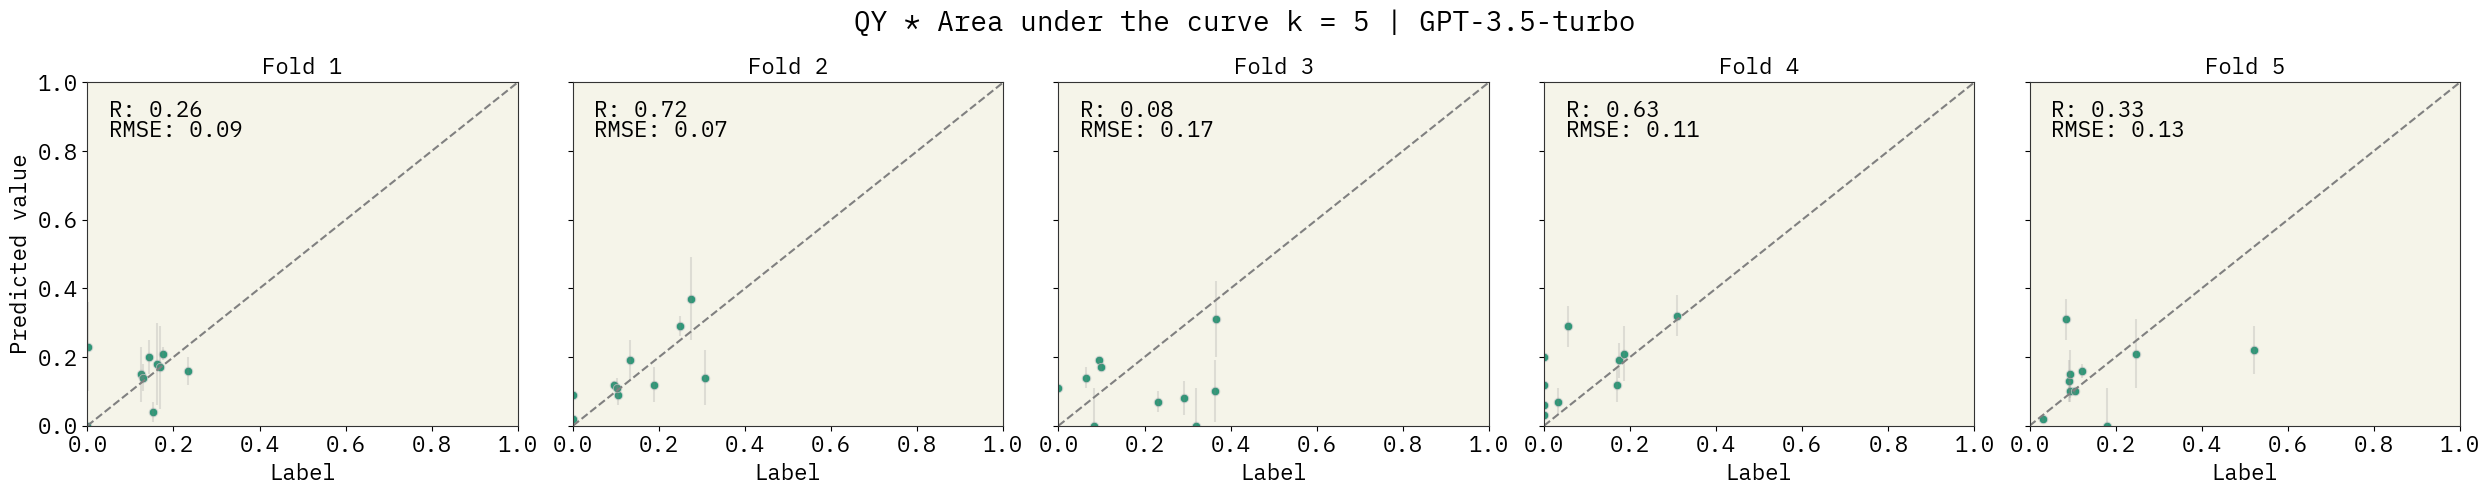

Run 0: 0.080
Run 1: 0.076
Run 2: 0.160
Run 3: 0.099
Run 4: 0.135


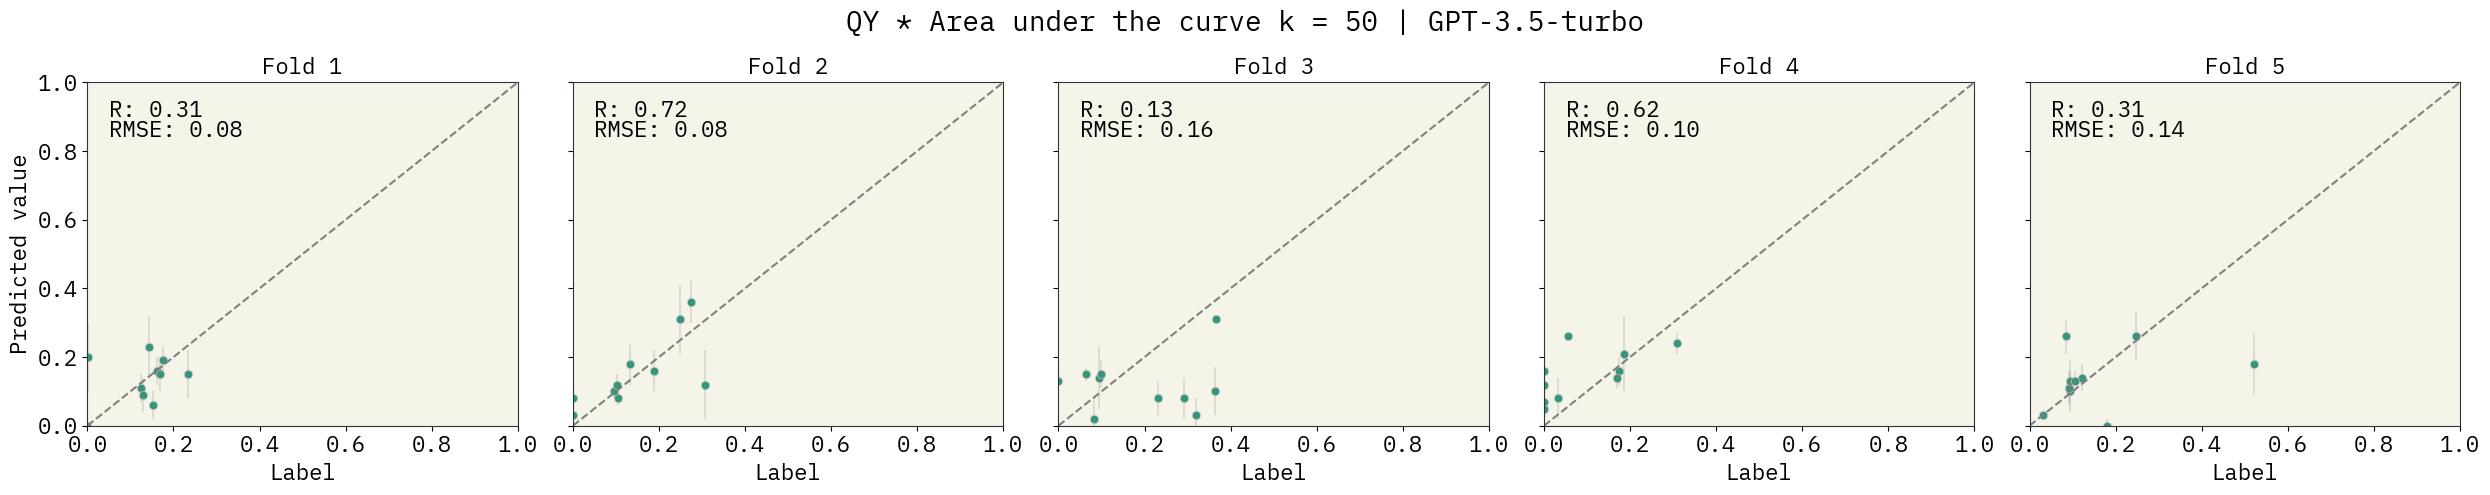

In [52]:
#load the data
results = """
--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.23+/-0.13 : 0.0024281016488759
0.00+/-0.12 : 5.376082341012849e-23
0.15+/-0.08 : 0.1244802946123225
0.21+/-0.02 : 0.1761206137591969
0.20+/-0.05 : 0.144038875423928
0.14+/-0.04 : 0.1281655976638377
0.18+/-0.12 : 0.1627886921783613
0.16+/-0.04 : 0.2346841074952277
0.17+/-0.12 : 0.1675805540221749
0.04+/-0.03 : 0.1532509213800647
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.09+/-0.03 : 0.1036540153288402
0.12+/-0.01 : 0.0954507534516285
0.12+/-0.05 : 0.1883050544245699
0.09+/-0.05 : 6.008432398454667e-09
0.14+/-0.08 : 0.3074969703159863
0.19+/-0.06 : 0.1332244677154561
0.11+/-0.03 : 0.1031003279038298
0.02+/-0.02 : 3.609710192742992e-23
0.37+/-0.12 : 0.2738430329178065
0.29+/-0.03 : 0.2487693146354349
--------------------------------------------------
Iteration:  2
--------------------------------------------------
0.00+/-0.11 : 0.3205384014781173
0.19+/-0.01 : 0.0941715779393882
0.07+/-0.03 : 0.2307426188748351
0.10+/-0.09 : 0.363978915859598
0.31+/-0.11 : 0.3661359975066579
0.11+/-0.08 : 1.1283350591476104e-08
0.14+/-0.03 : 0.0649503127083214
0.17+/-0.01 : 0.097980365553943
0.00+/-0.11 : 0.0822179124639913
0.08+/-0.05 : 0.2910117512640602
--------------------------------------------------
Iteration:  3
--------------------------------------------------
0.12+/-0.04 : 1.1265608371843352e-08
0.32+/-0.06 : 0.3081927703561664
0.29+/-0.06 : 0.0565085035109458
0.19+/-0.05 : 0.1744684928216673
0.20+/-0.13 : 4.9288145223513725e-08
0.07+/-0.04 : 0.0323517737303893
0.12+/-0.05 : 0.169743031661677
0.06+/-0.03 : 2.634258636089805e-23
0.03+/-0.02 : 1.2509253448855664e-23
0.21+/-0.08 : 0.186055682609363
--------------------------------------------------
Iteration:  4
--------------------------------------------------
0.21+/-0.10 : 0.2468866643908369
0.22+/-0.07 : 0.5209271695912385
0.31+/-0.06 : 0.083887957088509
0.02+/-0.01 : 0.0311985015342253
0.10+/-0.03 : 0.0942982443125344
0.13+/-0.06 : 0.0922627459213349
0.15+/-0.07 : 0.0934143199198959
0.16+/-0.02 : 0.1214078889627302
0.10+/-0.01 : 0.1064509982449831
0.00+/-0.11 : 0.1803572358605922
"""
save_file = "Data/cv_objf_gpt4o.csv"
parse_experiment_to_csv(results, save_file)
df = pd.read_csv("Data/cv_objf_gpt4o.csv")
y_hats = df['y_hats_mean'].groupby(df['iteration']).apply(list).values
y_labels = df['y_label'].groupby(df['iteration']).apply(list).values
y_hats_std = df['y_hats_std'].groupby(df['iteration']).apply(list).values
fig, axs = plt.subplots(1, 5, figsize=(25,5 ), sharex=True, sharey=True)

for i, (y_1, yhat_1, y_std,ax) in enumerate(zip(y_labels, y_hats, y_hats_std,axs)):
    rmse = np.sqrt(np.mean((y_1 - np.array(yhat_1))**2))
    print(f"Run {i}: {rmse:.3f}")
    
    ax.set_title(f"Fold {i+1}", fontsize=16)
    sns.scatterplot(x=y_1, y= yhat_1, ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=   yhat_1, yerr= y_std, fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    ax.text(0.05, 0.90, f"R: {np.corrcoef(y_1, yhat_1)[0, 1]:.2f}", transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.84, f"RMSE: {rmse:.2f}", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Predicted value", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #increase ticks labels size
    ax.tick_params(axis='both', which='major', labelsize=16)
    #sup title QY * Area under the curve | GPT-4o
    fig.suptitle("QY * Area under the curve k = 5 | GPT-3.5-turbo", fontsize=20)

plt.tight_layout()
plt.show()
results = """
--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.20+/-0.10 : 0.0024281016488759
0.00+/-0.01 : 5.376082341012849e-23
0.11+/-0.04 : 0.1244802946123225
0.19+/-0.04 : 0.1761206137591969
0.23+/-0.09 : 0.144038875423928
0.09+/-0.05 : 0.1281655976638377
0.16+/-0.04 : 0.1627886921783613
0.15+/-0.07 : 0.2346841074952277
0.15+/-0.05 : 0.1675805540221749
0.06+/-0.04 : 0.1532509213800647
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.08+/-0.02 : 0.1036540153288402
0.10+/-0.02 : 0.0954507534516285
0.16+/-0.06 : 0.1883050544245699
0.08+/-0.02 : 6.008432398454667e-09
0.12+/-0.10 : 0.3074969703159863
0.18+/-0.06 : 0.1332244677154561
0.12+/-0.03 : 0.1031003279038298
0.03+/-0.01 : 3.609710192742992e-23
0.36+/-0.06 : 0.2738430329178065
0.31+/-0.10 : 0.2487693146354349
--------------------------------------------------
Iteration:  2
--------------------------------------------------
0.03+/-0.05 : 0.3205384014781173
0.14+/-0.09 : 0.0941715779393882
0.08+/-0.05 : 0.2307426188748351
0.10+/-0.07 : 0.363978915859598
0.31+/-0.01 : 0.3661359975066579
0.13+/-0.05 : 1.1283350591476104e-08
0.15+/-0.02 : 0.0649503127083214
0.15+/-0.04 : 0.097980365553943
0.02+/-0.06 : 0.0822179124639913
0.08+/-0.06 : 0.2910117512640602
--------------------------------------------------
Iteration:  3
--------------------------------------------------
0.16+/-0.05 : 1.1265608371843352e-08
0.24+/-0.03 : 0.3081927703561664
0.26+/-0.01 : 0.0565085035109458
0.16+/-0.04 : 0.1744684928216673
0.12+/-0.10 : 4.9288145223513725e-08
0.08+/-0.06 : 0.0323517737303893
0.14+/-0.03 : 0.169743031661677
0.07+/-0.05 : 2.634258636089805e-23
0.05+/-0.07 : 1.2509253448855664e-23
0.21+/-0.11 : 0.186055682609363
--------------------------------------------------
Iteration:  4
--------------------------------------------------
0.26+/-0.07 : 0.2468866643908369
0.18+/-0.09 : 0.5209271695912385
0.26+/-0.05 : 0.083887957088509
0.03+/-0.01 : 0.0311985015342253
0.10+/-0.06 : 0.0942982443125344
0.11+/-0.05 : 0.0922627459213349
0.13+/-0.06 : 0.0934143199198959
0.14+/-0.04 : 0.1214078889627302
0.13+/-0.03 : 0.1064509982449831
0.00+/-0.02 : 0.1803572358605922
"""
save_file = "Data/cv_objf_gpt4o.csv"
parse_experiment_to_csv(results, save_file)
df = pd.read_csv("Data/cv_objf_gpt4o.csv")
y_hats = df['y_hats_mean'].groupby(df['iteration']).apply(list).values
y_labels = df['y_label'].groupby(df['iteration']).apply(list).values
y_hats_std = df['y_hats_std'].groupby(df['iteration']).apply(list).values
fig, axs = plt.subplots(1, 5, figsize=(25,5 ), sharex=True, sharey=True)

for i, (y_1, yhat_1, y_std,ax) in enumerate(zip(y_labels, y_hats, y_hats_std,axs)):
    rmse = np.sqrt(np.mean((y_1 - np.array(yhat_1))**2))
    print(f"Run {i}: {rmse:.3f}")
    
    ax.set_title(f"Fold {i+1}", fontsize=16)
    sns.scatterplot(x=y_1, y= yhat_1, ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=   yhat_1, yerr= y_std, fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    ax.text(0.05, 0.90, f"R: {np.corrcoef(y_1, yhat_1)[0, 1]:.2f}", transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.84, f"RMSE: {rmse:.2f}", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Predicted value", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #increase ticks labels size
    ax.tick_params(axis='both', which='major', labelsize=16)
    #sup title QY * Area under the curve | GPT-4o
    fig.suptitle("QY * Area under the curve k = 50 | GPT-3.5-turbo", fontsize=20)

plt.tight_layout()
plt.show()

Run 0: 0.173
Run 1: 0.070
Run 2: 0.076
Run 3: 0.098
Run 4: 0.090


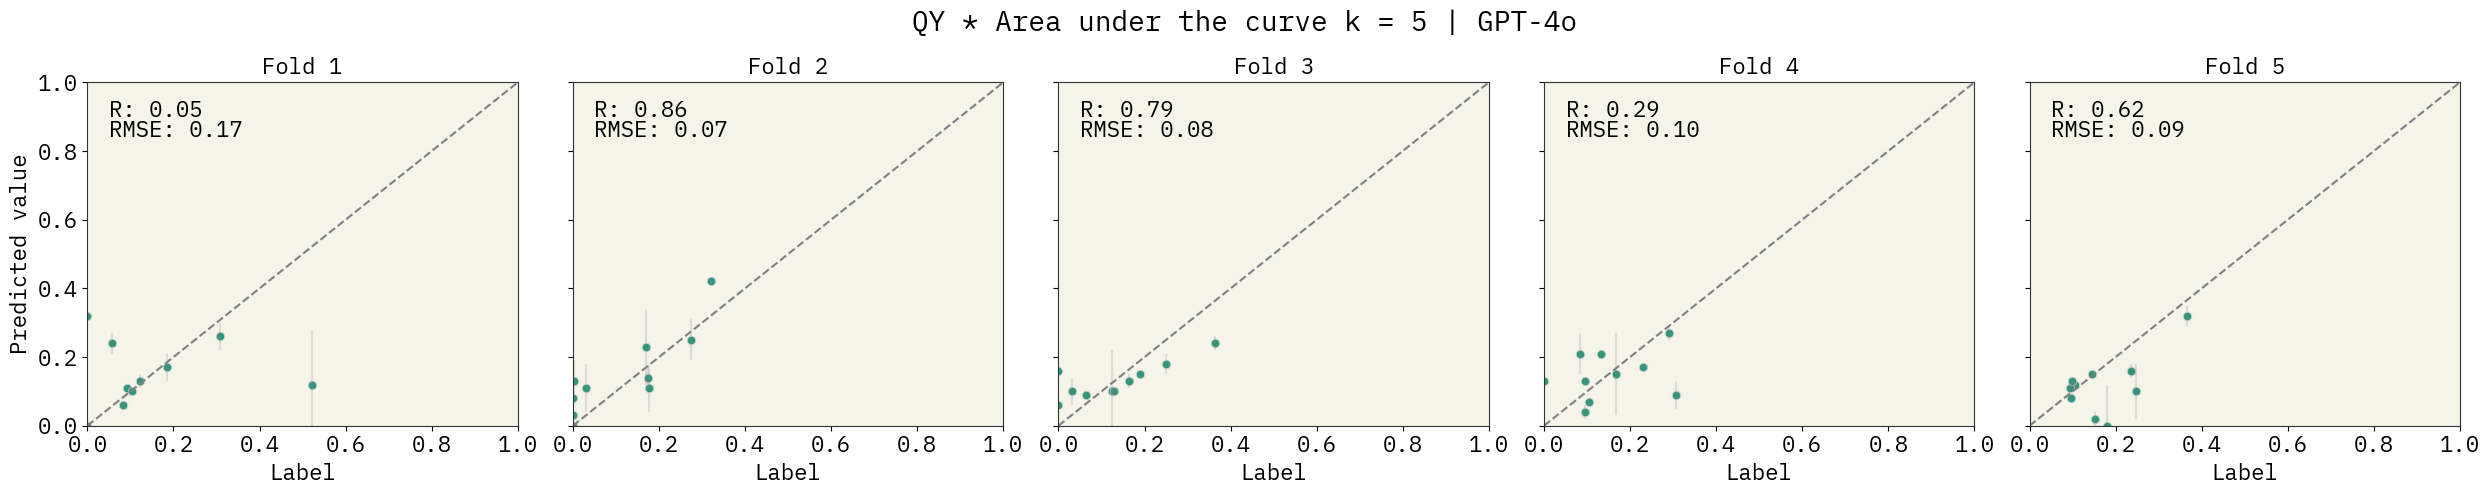

Run 0: 0.189
Run 1: 0.068
Run 2: 0.071
Run 3: 0.089
Run 4: 0.102


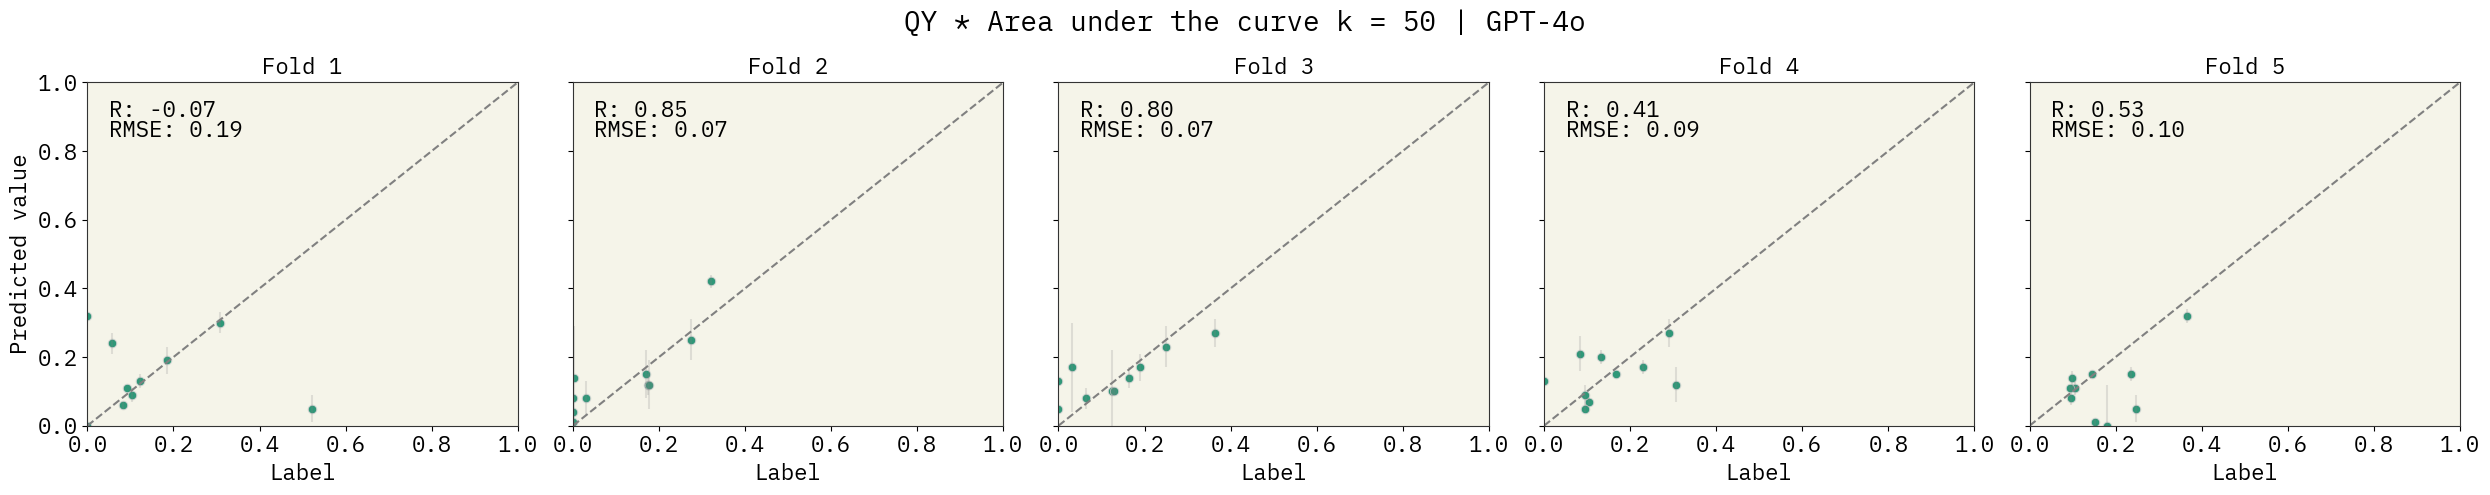

In [34]:
#load the data
results = """
--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.13+/-0.02 : 0.1214078889627302
0.11+/-0.00 : 0.0922627459213349
0.17+/-0.04 : 0.186055682609363
0.00+/-0.10 : 5.376082341012849e-23
0.12+/-0.16 : 0.5209271695912385
0.10+/-0.01 : 0.1031003279038298
0.32+/-0.10 : 6.008432398454667e-09
0.06+/-0.01 : 0.0822179124639913
0.26+/-0.04 : 0.3081927703561664
0.24+/-0.03 : 0.0565085035109458
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.42+/-0.01 : 0.3205384014781173
0.25+/-0.06 : 0.2738430329178065
0.00+/-0.00 : 1.2509253448855664e-23
0.11+/-0.07 : 0.0311985015342253
0.03+/-0.03 : 3.609710192742992e-23
0.23+/-0.11 : 0.169743031661677
0.13+/-0.06 : 0.0024281016488759
0.14+/-0.03 : 0.1744684928216673
0.11+/-0.07 : 0.1761206137591969
0.08+/-0.11 : 4.9288145223513725e-08
--------------------------------------------------
Iteration:  2
--------------------------------------------------
0.10+/-0.12 : 0.1244802946123225
0.10+/-0.00 : 0.1281655976638377
0.24+/-0.02 : 0.363978915859598
0.18+/-0.03 : 0.2487693146354349
0.09+/-0.01 : 0.0649503127083214
0.10+/-0.04 : 0.0323517737303893
0.13+/-0.02 : 0.1627886921783613
0.06+/-0.04 : 2.634258636089805e-23
0.16+/-0.03 : 1.1265608371843352e-08
0.15+/-0.00 : 0.1883050544245699
--------------------------------------------------
Iteration:  3
--------------------------------------------------
0.07+/-0.01 : 0.1036540153288402
0.13+/-0.01 : 0.0941715779393882
0.21+/-0.01 : 0.1332244677154561
0.21+/-0.06 : 0.083887957088509
0.15+/-0.12 : 0.1675805540221749
0.13+/-0.01 : 1.1283350591476104e-08
0.27+/-0.02 : 0.2910117512640602
0.04+/-0.02 : 0.0942982443125344
0.09+/-0.04 : 0.3074969703159863
0.17+/-0.01 : 0.2307426188748351
--------------------------------------------------
Iteration:  4
--------------------------------------------------
0.10+/-0.08 : 0.2468866643908369
0.00+/-0.12 : 0.1803572358605922
0.12+/-0.01 : 0.1064509982449831
0.11+/-0.01 : 0.0934143199198959
0.16+/-0.02 : 0.2346841074952277
0.15+/-0.00 : 0.144038875423928
0.02+/-0.02 : 0.1532509213800647
0.13+/-0.01 : 0.097980365553943
0.08+/-0.00 : 0.0954507534516285
0.32+/-0.03 : 0.3661359975066579
"""
save_file = "Data/cv_objf_gpt4o.csv"
parse_experiment_to_csv(results, save_file)
df = pd.read_csv("Data/cv_objf_gpt4o.csv")
y_hats = df['y_hats_mean'].groupby(df['iteration']).apply(list).values
y_labels = df['y_label'].groupby(df['iteration']).apply(list).values
y_hats_std = df['y_hats_std'].groupby(df['iteration']).apply(list).values
fig, axs = plt.subplots(1, 5, figsize=(25,5 ), sharex=True, sharey=True)

for i, (y_1, yhat_1, y_std,ax) in enumerate(zip(y_labels, y_hats, y_hats_std,axs)):
    rmse = np.sqrt(np.mean((y_1 - np.array(yhat_1))**2))
    print(f"Run {i}: {rmse:.3f}")
    
    ax.set_title(f"Fold {i+1}", fontsize=16)
    sns.scatterplot(x=y_1, y= yhat_1, ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=   yhat_1, yerr= y_std, fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    ax.text(0.05, 0.90, f"R: {np.corrcoef(y_1, yhat_1)[0, 1]:.2f}", transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.84, f"RMSE: {rmse:.2f}", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Predicted value", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #increase ticks labels size
    ax.tick_params(axis='both', which='major', labelsize=16)
    #sup title QY * Area under the curve | GPT-4o
    fig.suptitle("QY * Area under the curve k = 5 | GPT-4o", fontsize=20)

plt.tight_layout()
plt.show()
results = """
--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.13+/-0.02 : 0.1214078889627302
0.11+/-0.00 : 0.0922627459213349
0.19+/-0.04 : 0.186055682609363
0.00+/-0.10 : 5.376082341012849e-23
0.05+/-0.04 : 0.5209271695912385
0.09+/-0.02 : 0.1031003279038298
0.32+/-0.09 : 6.008432398454667e-09
0.06+/-0.01 : 0.0822179124639913
0.30+/-0.03 : 0.3081927703561664
0.24+/-0.03 : 0.0565085035109458
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.42+/-0.02 : 0.3205384014781173
0.25+/-0.06 : 0.2738430329178065
0.01+/-0.01 : 1.2509253448855664e-23
0.08+/-0.05 : 0.0311985015342253
0.04+/-0.05 : 3.609710192742992e-23
0.15+/-0.07 : 0.169743031661677
0.14+/-0.15 : 0.0024281016488759
0.12+/-0.03 : 0.1744684928216673
0.12+/-0.07 : 0.1761206137591969
0.08+/-0.00 : 4.9288145223513725e-08
--------------------------------------------------
Iteration:  2
--------------------------------------------------
0.10+/-0.12 : 0.1244802946123225
0.10+/-0.01 : 0.1281655976638377
0.27+/-0.04 : 0.363978915859598
0.23+/-0.06 : 0.2487693146354349
0.08+/-0.03 : 0.0649503127083214
0.17+/-0.13 : 0.0323517737303893
0.14+/-0.03 : 0.1627886921783613
0.05+/-0.08 : 2.634258636089805e-23
0.13+/-0.03 : 1.1265608371843352e-08
0.17+/-0.04 : 0.1883050544245699
--------------------------------------------------
Iteration:  3
--------------------------------------------------
0.07+/-0.01 : 0.1036540153288402
0.09+/-0.03 : 0.0941715779393882
0.20+/-0.02 : 0.1332244677154561
0.21+/-0.05 : 0.083887957088509
0.15+/-0.00 : 0.1675805540221749
0.13+/-0.02 : 1.1283350591476104e-08
0.27+/-0.04 : 0.2910117512640602
0.05+/-0.01 : 0.0942982443125344
0.12+/-0.05 : 0.3074969703159863
0.17+/-0.02 : 0.2307426188748351
--------------------------------------------------
Iteration:  4
--------------------------------------------------
0.05+/-0.04 : 0.2468866643908369
0.00+/-0.12 : 0.1803572358605922
0.11+/-0.02 : 0.1064509982449831
0.11+/-0.01 : 0.0934143199198959
0.15+/-0.02 : 0.2346841074952277
0.15+/-0.01 : 0.144038875423928
0.01+/-0.01 : 0.1532509213800647
0.14+/-0.02 : 0.097980365553943
0.08+/-0.02 : 0.0954507534516285
0.32+/-0.02 : 0.3661359975066579"""
save_file = "Data/cv_objf_gpt4o.csv"
parse_experiment_to_csv(results, save_file)
df = pd.read_csv("Data/cv_objf_gpt4o.csv")
y_hats = df['y_hats_mean'].groupby(df['iteration']).apply(list).values
y_labels = df['y_label'].groupby(df['iteration']).apply(list).values
y_hats_std = df['y_hats_std'].groupby(df['iteration']).apply(list).values
fig, axs = plt.subplots(1, 5, figsize=(25,5 ), sharex=True, sharey=True)

for i, (y_1, yhat_1, y_std,ax) in enumerate(zip(y_labels, y_hats, y_hats_std,axs)):
    rmse = np.sqrt(np.mean((y_1 - np.array(yhat_1))**2))
    print(f"Run {i}: {rmse:.3f}")
    
    ax.set_title(f"Fold {i+1}", fontsize=16)
    sns.scatterplot(x=y_1, y= yhat_1, ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=   yhat_1, yerr= y_std, fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    ax.text(0.05, 0.90, f"R: {np.corrcoef(y_1, yhat_1)[0, 1]:.2f}", transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.84, f"RMSE: {rmse:.2f}", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Predicted value", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #increase ticks labels size
    ax.tick_params(axis='both', which='major', labelsize=16)
    #sup title QY * Area under the curve | GPT-4o
    fig.suptitle("QY * Area under the curve k = 50 | GPT-4o", fontsize=20)

plt.tight_layout()
plt.show()

In [458]:
results = """
--------------------------------------------------
Iteration:  0
--------------------------------------------------
0.23+/-0.02 : 0.169743031661677
0.01+/-0.01 : 1.2509253448855664e-23
0.30+/-0.00 : 0.363978915859598
0.02+/-0.01 : 0.1532509213800647
0.11+/-0.03 : 0.0323517737303893
0.08+/-0.12 : 4.9288145223513725e-08
0.09+/-0.04 : 0.1744684928216673
0.09+/-0.01 : 2.634258636089805e-23
0.22+/-0.01 : 0.1332244677154561
0.06+/-0.01 : 0.0822179124639913
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.27+/-0.02 : 0.2910117512640602
0.13+/-0.03 : 1.1265608371843352e-08
0.11+/-0.11 : 0.1031003279038298
0.04+/-0.03 : 0.0024281016488759
0.24+/-0.04 : 0.2468866643908369
0.08+/-0.01 : 0.3074969703159863
0.05+/-0.04 : 0.0311985015342253
0.15+/-0.04 : 0.1214078889627302
0.00+/-0.11 : 5.376082341012849e-23
0.08+/-0.01 : 0.1036540153288402
--------------------------------------------------
Iteration:  2
--------------------------------------------------
0.16+/-0.04 : 0.0941715779393882
0.10+/-0.01 : 0.0942982443125344
0.09+/-0.04 : 0.5209271695912385
0.00+/-0.10 : 0.1803572358605922
0.24+/-0.02 : 0.0565085035109458
0.10+/-0.10 : 0.1244802946123225
0.41+/-0.00 : 0.3205384014781173
0.22+/-0.05 : 6.008432398454667e-09
0.26+/-0.05 : 0.3081927703561664
0.05+/-0.01 : 1.1283350591476104e-08
--------------------------------------------------
Iteration:  3
--------------------------------------------------
0.00+/-0.12 : 3.609710192742992e-23
0.27+/-0.04 : 0.2307426188748351
0.15+/-0.12 : 0.144038875423928
0.14+/-0.02 : 0.097980365553943
0.11+/-0.04 : 0.2346841074952277
0.12+/-0.04 : 0.1064509982449831
0.26+/-0.08 : 0.2738430329178065
0.07+/-0.02 : 0.1761206137591969
0.22+/-0.04 : 0.186055682609363
0.08+/-0.02 : 0.0649503127083214
--------------------------------------------------
Iteration:  4
--------------------------------------------------
0.33+/-0.02 : 0.3661359975066579
0.17+/-0.03 : 0.2487693146354349
0.10+/-0.12 : 0.1281655976638377
0.08+/-0.12 : 0.0954507534516285
0.13+/-0.12 : 0.1675805540221749
0.15+/-0.00 : 0.1627886921783613
0.15+/-0.00 : 0.1883050544245699
0.11+/-0.12 : 0.0922627459213349
0.10+/-0.02 : 0.0934143199198959
0.16+/-0.02 : 0.083887957088509"""
save_file = "Data/cv_objf_gpt4o.csv"
parse_experiment_to_csv(results, save_file)

Run 0: 0.078
Run 1: 0.085
Run 2: 0.178
Run 3: 0.056
Run 4: 0.042


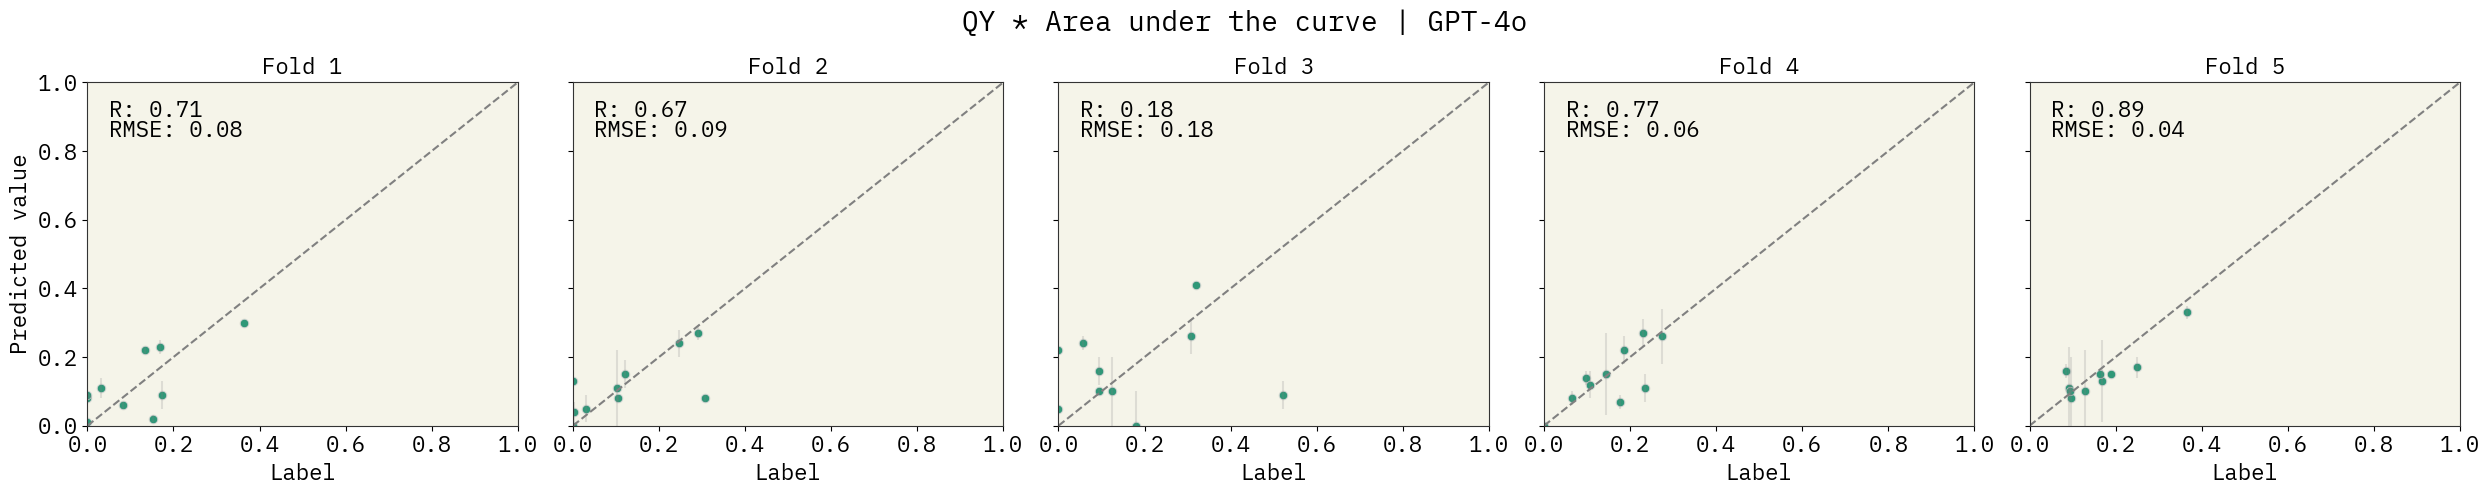

In [459]:
#load the data
df = pd.read_csv("Data/cv_objf_gpt4o.csv")
y_hats = df['y_hats_mean'].groupby(df['iteration']).apply(list).values
y_labels = df['y_label'].groupby(df['iteration']).apply(list).values
y_hats_std = df['y_hats_std'].groupby(df['iteration']).apply(list).values
fig, axs = plt.subplots(1, 5, figsize=(25,5 ), sharex=True, sharey=True)

for i, (y_1, yhat_1, y_std,ax) in enumerate(zip(y_labels, y_hats, y_hats_std,axs)):
    rmse = np.sqrt(np.mean((y_1 - np.array(yhat_1))**2))
    print(f"Run {i}: {rmse:.3f}")
    
    ax.set_title(f"Fold {i+1}", fontsize=16)
    sns.scatterplot(x=y_1, y= yhat_1, ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=   yhat_1, yerr= y_std, fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    ax.text(0.05, 0.90, f"R: {np.corrcoef(y_1, yhat_1)[0, 1]:.2f}", transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.84, f"RMSE: {rmse:.2f}", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Predicted value", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #increase ticks labels size
    ax.tick_params(axis='both', which='major', labelsize=16)
    #sup title QY * Area under the curve | GPT-4o
    fig.suptitle("QY * Area under the curve | GPT-4o", fontsize=20)

plt.tight_layout()
plt.show()


In [453]:
#set random seed 
import time
rmses = []
y_hats = []
y_s = []
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."
seed = 1234
#randomly shuffle the dataset
indexes = np.arange(len(df))
np.random.shuffle(indexes)
#split the dataset into 5 folds
folds = np.array_split(indexes, 5)


for run in range(5):
    test_indexes = folds[run]
    train_indexes = np.concatenate([folds[i] for i in range(5) if i != run])

    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="product of the quantum yield with the area under the fluorescence peak at 650 nm",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-3.5-turbo",
        selector_k=5,
        temperature=0.7
    )

    for i in train_indexes:
        asktell.tell(df['prompt'][i], df['obj_f'][i])
    yhat_1=[]
    y_1=[]
    rmse = []
    print("-"*50)
    print("Iteration: ", run)
    print("-"*50)
    for i in test_indexes:
        yhat_1.append(asktell.predict(df['prompt'][i], system_message=system_message))
        y_1.append(df['obj_f'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['obj_f'][i]}")
        rmse.append(np.sqrt(np.mean((y_1[-1] - yhat_1[-1].mean())**2)))
    rmses.append(np.mean(rmse))
    y_hats.append(yhat_1)
    y_s.append(y_1)

--------------------------------------------------
Iteration:  0
--------------------------------------------------
1.27+/-0.16 : 6.008432398454667e-09
0.05+/-0.02 : 0.363978915859598
0.04+/-0.05 : 0.1803572358605922
0.12+/-0.01 : 0.1064509982449831
0.06+/-0.05 : 0.0941715779393882
0.08+/-0.10 : 0.0822179124639913
0.08+/-0.03 : 0.1036540153288402
0.10+/-0.02 : 0.1281655976638377
0.09+/-0.06 : 0.1214078889627302
0.18+/-0.03 : 0.2487693146354349
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.12+/-0.01 : 1.1283350591476104e-08
0.35+/-0.09 : 0.3081927703561664
0.23+/-0.18 : 0.0934143199198959
0.01+/-0.02 : 3.609710192742992e-23
0.15+/-0.01 : 0.1744684928216673
0.07+/-0.02 : 0.0942982443125344
0.07+/-0.06 : 0.0311985015342253
0.06+/-0.02 : 0.3205384014781173
0.16+/-0.09 : 0.2738430329178065
0.16+/-0.15 : 0.0649503127083214
--------------------------------------------------
Iteration:  2
----------------------------------

In [460]:
import re
import pandas as pd

# Regex to match lines in the form "0.22+/-0.06 : 1.1265608371843352e-08"

results = """
--------------------------------------------------
Iteration:  0
--------------------------------------------------
1.27+/-0.16 : 6.008432398454667e-09
0.05+/-0.02 : 0.363978915859598
0.04+/-0.05 : 0.1803572358605922
0.12+/-0.01 : 0.1064509982449831
0.06+/-0.05 : 0.0941715779393882
0.08+/-0.10 : 0.0822179124639913
0.08+/-0.03 : 0.1036540153288402
0.10+/-0.02 : 0.1281655976638377
0.09+/-0.06 : 0.1214078889627302
0.18+/-0.03 : 0.2487693146354349
--------------------------------------------------
Iteration:  1
--------------------------------------------------
0.12+/-0.01 : 1.1283350591476104e-08
0.35+/-0.09 : 0.3081927703561664
0.23+/-0.18 : 0.0934143199198959
0.01+/-0.02 : 3.609710192742992e-23
0.15+/-0.01 : 0.1744684928216673
0.07+/-0.02 : 0.0942982443125344
0.07+/-0.06 : 0.0311985015342253
0.06+/-0.02 : 0.3205384014781173
0.16+/-0.09 : 0.2738430329178065
0.16+/-0.15 : 0.0649503127083214
--------------------------------------------------
Iteration:  2
--------------------------------------------------
0.28+/-0.07 : 0.186055682609363
0.19+/-0.12 : 0.5209271695912385
0.22+/-0.10 : 0.1244802946123225
0.18+/-0.08 : 0.2346841074952277
0.03+/-0.04 : 5.376082341012849e-23
0.15+/-0.05 : 0.2307426188748351
0.08+/-0.04 : 0.0323517737303893
0.14+/-0.02 : 0.1675805540221749
0.09+/-0.00 : 0.2910117512640602
0.12+/-0.16 : 0.0024281016488759
--------------------------------------------------
Iteration:  3
--------------------------------------------------
0.68+/-0.17 : 0.1761206137591969
0.15+/-0.02 : 0.1031003279038298
0.14+/-0.00 : 0.0954507534516285
0.31+/-0.12 : 0.2468866643908369
0.07+/-0.01 : 4.9288145223513725e-08
0.34+/-0.10 : 0.1883050544245699
0.13+/-0.01 : 1.1265608371843352e-08
0.34+/-0.08 : 0.1332244677154561
0.09+/-0.01 : 0.0922627459213349
0.02+/-0.01 : 2.634258636089805e-23
--------------------------------------------------
Iteration:  4
--------------------------------------------------
0.07+/-0.02 : 0.1532509213800647
0.12+/-0.08 : 0.097980365553943
0.24+/-0.03 : 0.3661359975066579
0.24+/-0.09 : 0.169743031661677
0.06+/-0.04 : 0.1627886921783613
0.24+/-0.01 : 0.0565085035109458
0.02+/-0.01 : 1.2509253448855664e-23
0.44+/-0.83 : 0.3074969703159863
0.13+/-0.01 : 0.144038875423928
0.29+/-0.03 : 0.083887957088509
"""


parse_experiment_to_csv(results, "Data/cv_QY_AUC2_gpt35.csv")


[6.00843239845e-09, 0.36397891586, 0.180357235861, 0.106450998245, 0.0941715779394, 0.082217912464, 0.103654015329, 0.128165597664, 0.121407888963, 0.248769314635] [1.27, 0.05, 0.04, 0.12, 0.06, 0.08, 0.08, 0.1, 0.09, 0.18]
Run 0: 0.417
Run 1: 0.113
Run 2: 0.140
Run 3: 0.187
Run 4: 0.115


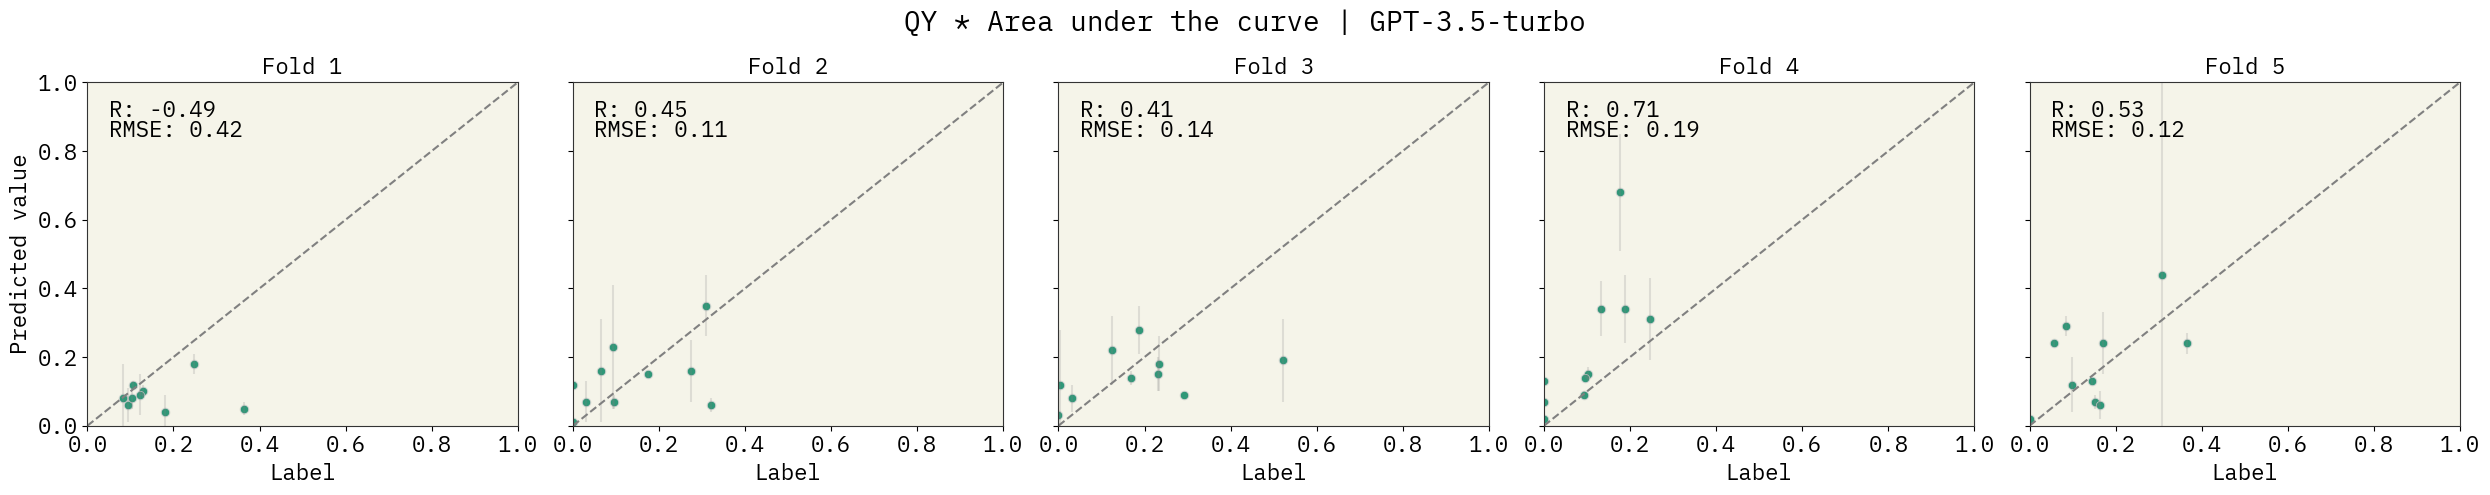

In [461]:
#load the data
df = pd.read_csv("Data/cv_QY_AUC2_gpt35.csv")
y_hats = df['y_hats_mean'].groupby(df['iteration']).apply(list).values
y_labels = df['y_label'].groupby(df['iteration']).apply(list).values
y_hats_std = df['y_hats_std'].groupby(df['iteration']).apply(list).values
fig, axs = plt.subplots(1, 5, figsize=(25,5 ), sharex=True, sharey=True)

for i, (y_1, yhat_1, y_std,ax) in enumerate(zip(y_labels, y_hats, y_hats_std,axs)):
    if i == 0:
        print(y_1, yhat_1)
    rmse = np.sqrt(np.mean((np.array(y_1) - yhat_1)**2))
    print(f"Run {i}: {rmse:.3f}")
    
    ax.set_title(f"Fold {i+1}", fontsize=16)
    sns.scatterplot(x=y_1, y= yhat_1, ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=   yhat_1, yerr= y_std, fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    ax.text(0.05, 0.90, f"R: {np.corrcoef(np.array(y_1), np.array(yhat_1))[0, 1]:.2f}", transform=ax.transAxes, fontsize=16)
    ax.text(0.05, 0.84, f"RMSE: {rmse:.2f}", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Predicted value", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #increase ticks labels size
    ax.tick_params(axis='both', which='major', labelsize=16)
    #sup title QY * Area under the curve | GPT-3.5-turbo
    fig.suptitle("QY * Area under the curve | GPT-3.5-turbo", fontsize=20)

plt.tight_layout()
plt.show()



In [ ]:
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat_1=[]
y_1=[]
for i in test_indexes:
  yhat_1.append(asktell.predict(df['Prompt'][i], system_message=system_message))
  y_1.append(df['f'][i])
  print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['f'][i]}")


0.34+/-0.14 : 0.1988183425807789
0.30+/-0.18 : 0.1599328608388116
0.30+/-0.17 : 0.1330910448376423
0.17+/-0.06 : 0.1097804772312241
0.25+/-0.04 : 0.0853817344296481
0.50+/-0.22 : 0.3059663553493036
0.26+/-0.28 : 0.1555238091405023
0.14+/-0.06 : 0.2100319821575873
0.56+/-0.18 : 0.2712714273847921
0.24+/-0.04 : 0.1283634042910054
0.30+/-0.21 : 0.1662505427573248
0.28+/-0.09 : 0.1404935146836862
0.21+/-0.05 : 0.0375107602763444
0.21+/-0.07 : 0.1285520101269751
0.46+/-0.24 : 0.1630117208364813
0.24+/-0.21 : 0.1613264409922826
0.24+/-0.11 : 0.1876191624268434
0.68+/-0.20 : 0.1702781335879201


# Predicting CIE_x and CIE_y

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bolift

GPR Packages not installed. Do `pip install bolift[gpr]` to install them


In [3]:
df = pd.read_csv('Data/procedures_CIE.tsv', sep="\t")
df.head()

print(len(df))

56


In [4]:
df.columns

Index(['Prompt', 'CIE_x', 'CIE_y'], dtype='object')

In [ ]:
#read corrected data wo baseline v8: data with CIE values
dataframe = pd.read_csv('Data/processed_data.csv', sep=",")
dataframe.columns

Index(['Dimension1(nm)', 'Dimension2(nm)', 'OD', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'MeOH_vol(mL)', 'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)',
       'Temperature(C)', 'Experiment', 'Peak1', 'Peak2', 'Area1', 'Area2',
       'Pre-QY', 'QY', 'QY_peak1', 'QY_peak2', 'Fl_Wavelengths',
       'Fluorescence', 'Fluorescence_norm', 'Abs_Wavelengths', 'Absorbance',
       'Absorbance_norm', 'CIE_x', 'CIE_y'],
      dtype='object')

In [229]:
df_structured = dataframe[['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'Doping(%)',  'Time(min)',
       'Temperature(C)', 'CIE_x', 'CIE_y']]
df_structured.head()

Dimension1(nm)  Dimension2(nm)  Dilution(%)  Dilution(%)  \
0            18.8           14.04        0.175        0.175   
1            18.8           14.04        0.175        0.175   
2            18.8           14.04        0.175        0.175   
3            18.8           14.04        0.175        0.175   
4            18.8           14.04        0.175        0.175   

   Nano_stock_vol(mL)  AgConc(M)  AgMass(mg)  Doping(%)  Time(min)  \
0                0.25     0.0060         7.8       1.25         60   
1                0.25     0.0060         7.8       2.50         60   
2                0.25     0.0060         7.8       5.00         60   
3                0.25     0.0060         7.8      10.00         60   
4                0.25     0.0007         3.5       0.25         60   

   Temperature(C)     CIE_x     CIE_y  
0              25  0.521398  0.447538  
1              25  0.650174  0.348096  
2              25  0.639103  0.358419  
3              25  0.658767  0.339308  
4              25  0.041857  0.777612

In [230]:
indexes = np.arange(len(df_structured))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)

#split into train and test
train_df = df_structured.iloc[indexes[:int(split*len(indexes))]]
test_df = df_structured.iloc[indexes[int(split*len(indexes)):]]

Linear Regression CIE_x [ 0.22371915  0.46456048  0.27835174  0.26291512  0.1894298   0.29249346
  0.46585161  0.31476157  0.31911614  0.12457473  0.2922053   0.28963189
  0.40223765  0.04376433  0.55923833  0.25858607  0.29391167  0.25730414
  0.26749745  0.24406256  0.11025681  0.26211859  0.37292262  0.69195758
  0.3365965   0.06966222  0.55131429  0.33487525  0.41738928  0.6069332
  0.27508597  0.23968238  0.48110204  0.30967832  0.73665452  0.36159559
  0.29758019  0.08709399  0.32950233  0.26353793  0.48053899  0.42100725
  0.39426578  0.26337188] [ 0.20661231  0.45548318  0.02716795  0.35850545  0.18882361  0.41822415
  0.12470777  0.02694148  0.04185684  0.02444294  0.4344144   0.28826612
  0.24029907  0.24242132  0.65017364  0.25137967  0.31369069  0.39927988
  0.4639325   0.59541789  0.14551183  0.34534245  0.43153777  0.65715504
  0.46473877  0.1532759   0.42491172  0.2620459   0.34390597  0.52139794
  0.30873864  0.40361865  0.54483035  0.35095678  0.63910276  0.41605574
  

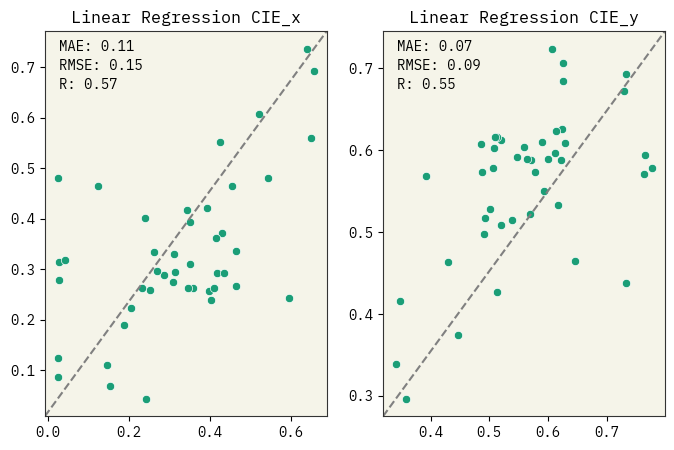

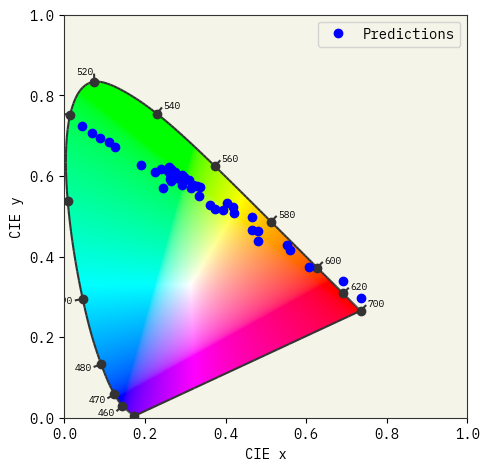

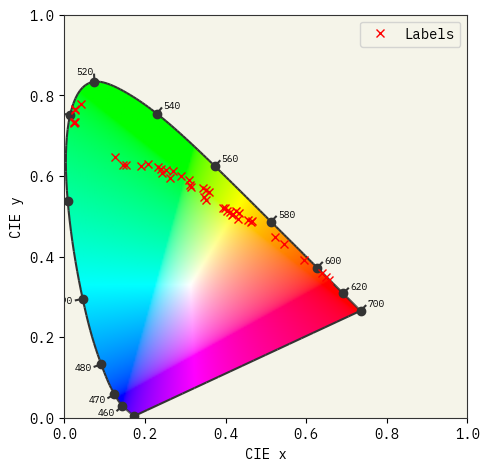

Random Forest CIE_x [ 0.13282934  0.37405109  0.29544299  0.30761416  0.20220597  0.29027459
  0.50947639  0.28612831  0.27302288  0.14754661  0.347003    0.23218907
  0.3079265   0.09690073  0.51518281  0.16005917  0.21133287  0.37233697
  0.31553939  0.36218015  0.12736726  0.27540976  0.3488211   0.56435624
  0.34812008  0.13400475  0.4395834   0.34313571  0.33375941  0.37733461
  0.26751269  0.25080721  0.3975203   0.37915429  0.59720171  0.33807579
  0.3533779   0.19559356  0.18081472  0.24923309  0.36307652  0.40966199
  0.22657471  0.1879552 ] [ 0.20661231  0.45548318  0.02716795  0.35850545  0.18882361  0.41822415
  0.12470777  0.02694148  0.04185684  0.02444294  0.4344144   0.28826612
  0.24029907  0.24242132  0.65017364  0.25137967  0.31369069  0.39927988
  0.4639325   0.59541789  0.14551183  0.34534245  0.43153777  0.65715504
  0.46473877  0.1532759   0.42491172  0.2620459   0.34390597  0.52139794
  0.30873864  0.40361865  0.54483035  0.35095678  0.63910276  0.41605574
  0.2

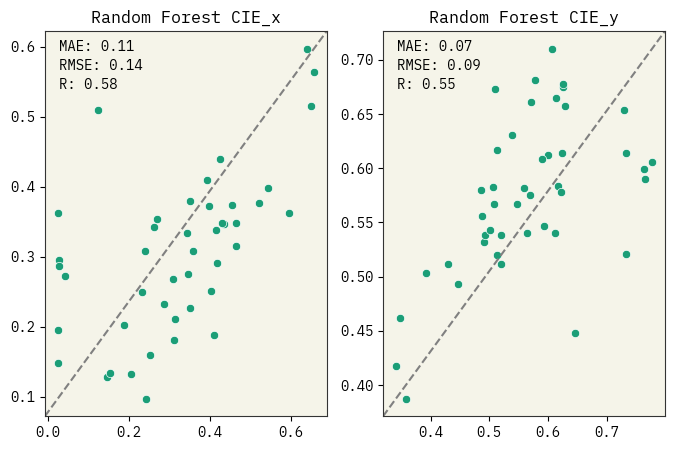

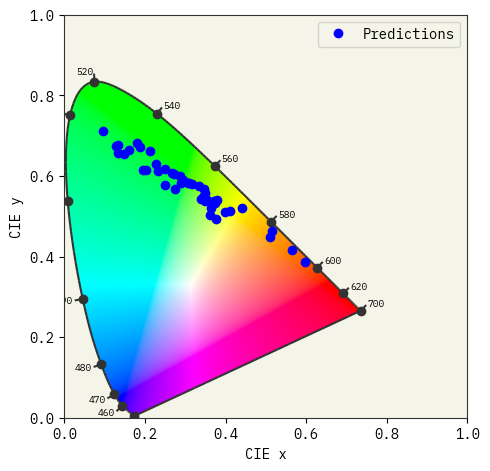

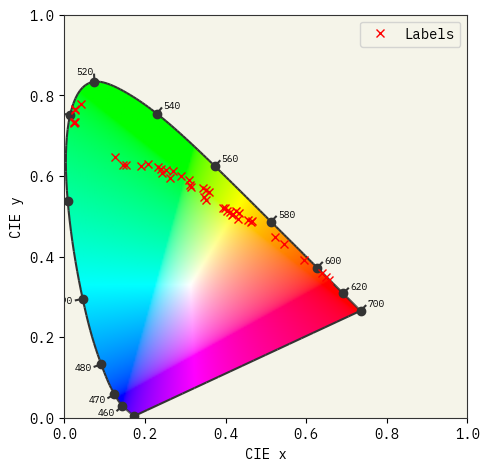

SVR CIE_x [ 0.2120696   0.37684922  0.30073169  0.36243567  0.38895025  0.1316499
  0.44598713  0.2459625   0.37354048  0.22470855  0.38688509  0.35723453
  0.35756356  0.17104042  0.42541993  0.38334055  0.21435265  0.21574459
  0.34239465  0.3610087   0.31536681  0.33247502  0.34849713  0.40633451
  0.37908801  0.29123194  0.38353923  0.22238442  0.34501265  0.37378312
  0.35274343  0.27577911  0.37995922  0.35813812  0.39385994  0.35012996
  0.38239086  0.34994955  0.13726131  0.31410041  0.29041944  0.31693898
  0.15495992  0.13708058] [ 0.20661231  0.45548318  0.02716795  0.35850545  0.18882361  0.41822415
  0.12470777  0.02694148  0.04185684  0.02444294  0.4344144   0.28826612
  0.24029907  0.24242132  0.65017364  0.25137967  0.31369069  0.39927988
  0.4639325   0.59541789  0.14551183  0.34534245  0.43153777  0.65715504
  0.46473877  0.1532759   0.42491172  0.2620459   0.34390597  0.52139794
  0.30873864  0.40361865  0.54483035  0.35095678  0.63910276  0.41605574
  0.26952103  0.

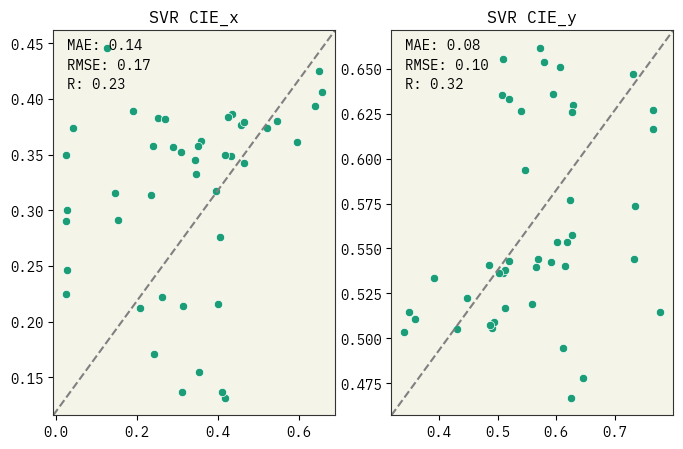

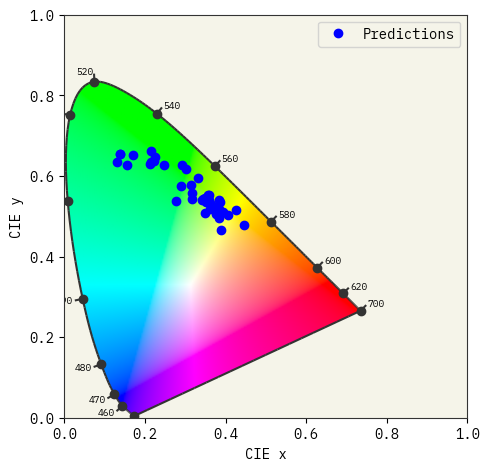

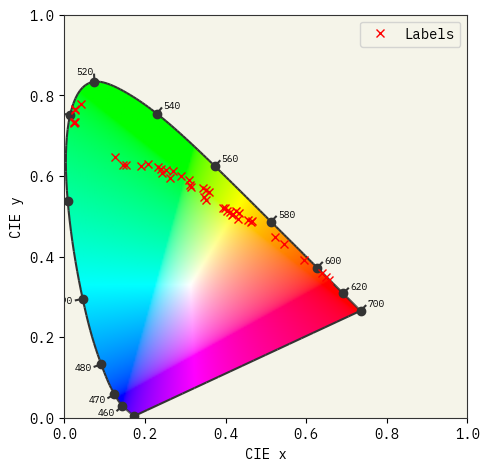

In [234]:
#train and test a gpr with ard_dim =9 and GPMatern 2.5 kernel and LeaveOneOutPseudoLikelihood.
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
from colour.plotting import plot_chromaticity_diagram_CIE1931, render
kernel = Matern(nu=2.5, length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
gpr_y = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
X_train = train_df[['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Dilution(%)',
         'Nano_stock_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
         'Doping(%)',  'Time(min)',
         'Temperature(C)']]
y_train_x = train_df[['CIE_x']]
y_train_y = train_df[['CIE_y']]
gpr_x.fit(X_train, y_train_x)
gpr_y.fit(X_train, y_train_y)


X_test = test_df[['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Dilution(%)',
            'Nano_stock_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
            'Doping(%)',  'Time(min)',
            'Temperature(C)']]
y_test_x = test_df[['CIE_x']]
y_test_y = test_df[['CIE_y']]

#train other common baseline models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_val_predict


lr_x = LinearRegression()
lr_y = LinearRegression()
rf_x = RandomForestRegressor()
rf_y = RandomForestRegressor()
svr_x = SVR()
svr_y = SVR()

models_x = [lr_x, rf_x, svr_x]
model_names_x = ["Linear Regression CIE_x", "Random Forest CIE_x", "SVR CIE_x"]
models_names_y = ["Linear Regression CIE_y", "Random Forest CIE_y", "SVR CIE_y"]
model_y = [lr_y,rf_y,svr_y]
for model_x, name_x, model_y, name_y in zip(models_x, model_names_x,model_y,models_names_y):
    # print(f"{name} RMSE: {np.mean(np.sqrt(-scores))}")
    #plot the scatter plots 
    # model.fit(X_train, y_train_x)
    scores_x = cross_val_predict(model_x, X_train, y_train_x.to_numpy().ravel(), cv=5,)# scoring='neg_mean_absolute_error')
    scores_y = cross_val_predict(model_y, X_train, y_train_y.to_numpy().ravel(), cv=5,)# scoring='neg_mean_absolute_error')
    #calculate MAE and RMSE
    print(name_x,scores_x,y_train_x.to_numpy().ravel())

    mae_x = np.mean(np.abs(scores_x - y_train_x.to_numpy().ravel()))
    rmse_x = np.sqrt(np.mean((scores_x - y_train_x.to_numpy().ravel())**2))
    #scatter plot 
    fig, ax = plt.subplots(1,2,figsize=(8, 5))
    ax[0].set_title(name_x)
    ax[0]=sns.scatterplot(x=y_train_x.to_numpy().ravel(), y=scores_x, ax=ax[0], color='C0')
    ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, ls="--", color="gray")
    #include correlation coefficient
    ax[0].text(0.05, 0.95, f"MAE: {mae_x:.2f}", transform=ax[0].transAxes)
    ax[0].text(0.05, 0.90, f"RMSE: {rmse_x:.2f}", transform=ax[0].transAxes)
    ax[0].text(0.05, 0.85, f"R: {np.corrcoef(y_train_x.to_numpy().ravel(), scores_x)[0, 1]:.2f}", transform=ax[0].transAxes)
    
    mae_y = np.mean(np.abs(scores_y - y_train_y.to_numpy().ravel()))
    rmse_y = np.sqrt(np.mean((scores_y - y_train_y.to_numpy().ravel())**2))
    #scatter plot 
    # fig, ax = plt.subplots(1,2,figsize=(8, 5))
    ax[1].set_title(name_y)
    ax[1]=sns.scatterplot(x=y_train_y.to_numpy().ravel(), y=scores_y, ax=ax[1], color='C0')
    ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes, ls="--", color="gray")
    #include correlation coefficient
    ax[1].text(0.05, 0.95, f"MAE: {mae_y:.2f}", transform=ax[1].transAxes)
    ax[1].text(0.05, 0.90, f"RMSE: {rmse_y:.2f}", transform=ax[1].transAxes)
    ax[1].text(0.05, 0.85, f"R: {np.corrcoef(y_train_y.to_numpy().ravel(), scores_y)[0, 1]:.2f}", transform=ax[1].transAxes)
    print(name_y,scores_y,y_train_y.to_numpy().ravel())
    # print(f"{name} RMSE: {np.mean(np.sqrt(-scores))}")
    



    # Data from the user
    yhat_means_x = scores_x
    yhat_means_y = scores_y
    labels_x = y_train_x.to_numpy().ravel()
    labels_y = y_train_y.to_numpy().ravel()

    # Setting up the plot
    plot_chromaticity_diagram_CIE1931(show=False, title = "")

    # Plot predictions
    # plt.title("")
    plt.plot(yhat_means_x, yhat_means_y, "o", color="blue", label="Predictions")
    plt.legend()
    plt.show()
    plot_chromaticity_diagram_CIE1931(show=False,title="")
    # plt.title("")
    # Plot labels
    plt.plot(labels_x, labels_y, "x", color="red", label="Labels")

    # Annotate
    # for i, (px, py, lx, ly) in enumerate(zip(yhat_means_x, yhat_means_y, labels_x, labels_y)):
        # plt.annotate(f"P{i+1}", (px, py), color="blue")
        # plt.annotate(f"L{i+1}", (lx, ly), color="red")
        # if i >3:
            # break

    # Add legend and render
    plt.legend()
    render(show=True, limits=(-0.1, 0.9, -0.1, 0.9), x_tighten=True, y_tighten=True)

# for model, name in zip(models, models_names_y):
#     print(name,scores)
#     # print(f"{name} RMSE: {np.mean(np.sqrt(-scores))}")
#     #plot the scatter plots
#     # model.fit(X_train, y_train_y)
#     scores = cross_val_predict(model, X_train, y_train_y.to_numpy().ravel(), cv=5,)# scoring='neg_mean_absolute_error')
#     #calculate MAE and RMSE
#     mae = np.mean(np.abs(scores - y_train_y.to_numpy().ravel()))
#     rmse = np.sqrt(np.mean((scores - y_train_y.to_numpy().ravel())**2))
#     #scatter plot
#     fig, ax = plt.subplots(figsize=(8, 5))
#     ax.set_title(name)

#     sns.scatterplot(x=y_train_y.to_numpy().ravel(), y=scores, ax=ax, color='C0')
#     ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
#     #include correlation coefficient
#     ax.text(0.05, 0.95, f"MAE: {mae:.2f}", transform=ax.transAxes)
#     ax.text(0.05, 0.90, f"RMSE: {rmse:.2f}", transform=ax.transAxes)
#     ax.text(0.05, 0.85, f"R: {np.corrcoef(y_train_y.to_numpy().ravel(), scores)[0, 1]:.2f}", transform=ax.transAxes)
#     print(name,scores)





In [6]:
import numpy as np
indexes = np.arange(len(df))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)
print(split)
#split into train and test
#get the indexes for 5 folds
folds = np.array_split(indexes, 5)
print(folds)
train_indexes = np.concatenate([folds[i] for i in range(4)])
test_indexes = folds[4]
print(train_indexes)
train_df = df.iloc[train_indexes]
test_df = df.iloc[test_indexes]


0.7857142857142857
[array([ 9,  5, 31, 15, 13, 44, 45, 24,  3, 26, 30, 28]), array([46, 51, 41, 50, 33, 35,  6, 12, 14,  2, 39]), array([42, 47, 49, 19, 10,  7,  0, 36, 22, 23, 40]), array([ 1, 25, 17, 18, 20, 48, 37, 11, 43, 55, 27]), array([54, 38, 53, 29, 16, 52,  4, 34,  8, 32, 21])]
[ 9  5 31 15 13 44 45 24  3 26 30 28 46 51 41 50 33 35  6 12 14  2 39 42
 47 49 19 10  7  0 36 22 23 40  1 25 17 18 20 48 37 11 43 55 27]


In [5]:
len(train_df)

45

In [354]:
asktell_CIEx.prompt

FewShotPromptTemplate(input_variables=['x', 'y_name'], input_types={}, partial_variables={}, example_selector=SemanticSimilarityExampleSelector(vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x30f3e0160>, k=5, example_keys=None, input_keys=None, vectorstore_kwargs=None), example_prompt=PromptTemplate(input_variables=['x', 'y', 'y_name'], input_types={}, partial_variables={}, template='Q: Given {x}, what is {y_name}?\nA: {y}###\n\n'), suffix='Q: Given {x}. What is {y_name}?\nA: ', prefix='Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n')

In [356]:
asktell_CIEx.prompt.example_selector.select_examples(input_variables={'x':x, 'y':y})

[{'x': 'the experimental procedure: Stock nanoplatelets have dimensions 45.77 nm by 7.29 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20 mL of MeOH and 8 mL of water. 5.0 % Ag doping requires 206.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.',
  'y': '0.31',
  'y_name': "The 'CIE 1931 2 Degree Standard Observer' x (red) coordinate from the fluorescence spectrum"},
 {'x': 'the experimental procedure: Stock nanoplatelets have dimensions 45.77 nm by 7.29 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver

In [363]:
asktell_CIEx.prompt

FewShotPromptTemplate(input_variables=['x', 'y_name'], input_types={}, partial_variables={}, example_selector=SemanticSimilarityExampleSelector(vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x30f3e0160>, k=5, example_keys=None, input_keys=None, vectorstore_kwargs=None), example_prompt=PromptTemplate(input_variables=['x', 'y', 'y_name'], input_types={}, partial_variables={}, template='Q: Given {x}, what is {y_name}?\nA: {y}###\n\n'), suffix='Q: Given {x}. What is {y_name}?\nA: ', prefix='Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n')

In [367]:
print(df.iloc[test_indexes].iloc[1])


Prompt    Stock nanoplatelets have dimensions 18.8 nm by...
CIE_x                                              0.269521
CIE_y                                               0.61163
Name: 7, dtype: object


In [472]:
print(df.iloc[test_indexes].iloc[3]['Prompt'])
x=asktell_CIEx.format_x(df.iloc[test_indexes].iloc[1]['Prompt'])
y = asktell_CIEx._y_name
# print(x)
# print(y)
# print(asktell_CIEx.ask(x))
print(asktell_CIEx.prompt.format(x=x,y_name=y))

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20 mL of MeOH and 8 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: 


Q: Given the experimental procedure: Stock nanoplatelets have dimensions 31.63 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acet

In [473]:
df.iloc[test_indexes].iloc[3]

Prompt    Stock nanoplatelets have dimensions 36.27 nm b...
CIE_x                                              0.145512
CIE_y                                              0.626008
Name: 38, dtype: object

## Different number of samples 



In [ ]:
#code to get the predictions for the CIE_x and CIE_y
#using the GPT-4o model and 5 fold cross validation
number_of_samples = [1,5,50]
y_hats_per_nsamples = []
y_per_nsamples = []
y_hats_CIE_x = []
y_hats_CIE_y = []
y_CIE_x = []
y_CIE_y = []
for k in number_of_samples:
    for i in range(5):
        print(f"Fold {i+1}")
        test_indexes = folds[i]
        train_indexes = np.concatenate([folds[j] for j in range(5) if j != i])
        test_df = df.iloc[test_indexes]
        train_df = df.iloc[train_indexes]

        asktell_CIEx = bolift.AskTellFewShotTopk(
            prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
            x_formatter=lambda x: f"the experimental procedure: {x}",
            y_name="The 'CIE 1931 2 Degree Standard Observer' x (red) coordinate from the fluorescence spectrum",
            y_formatter=lambda y: f"{y:.2f}",
            model="gpt-4o",
            selector_k=5,
            temperature=0.7
            k=k
        )

        asktell_CIEy = bolift.AskTellFewShotTopk(
            prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
            x_formatter=lambda x: f"the experimental procedure: {x}",
            y_name="The 'CIE 1931 2 Degree Standard Observer' y (green) coordinate from the fluorescence spectrum",
            y_formatter=lambda y: f"{y:.2f}",
            model="gpt-4o",
            selector_k=5,
            temperature=0.7
            k=k
        )

        for i in range(len(train_df)):
            asktell_CIEx.tell(train_df['Prompt'].iloc[i], train_df['CIE_x'].iloc[i])

        for i in range(len(train_df)):
            asktell_CIEy.tell(train_df['Prompt'].iloc[i], train_df['CIE_y'].iloc[i])


        yhat_1=[]
        yhat_2=[]
        y_1=[]
        y_2=[]
        for i in test_df.index:
            yhat_1.append(asktell_CIEx.predict(df['Prompt'][i])) #system_message=system_message))
            yhat_2.append(asktell_CIEy.predict(df['Prompt'][i])) #system_message=system_message))
            y_1.append(test_df['CIE_x'][i])
            y_2.append(test_df['CIE_y'][i])
            print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {test_df['CIE_x'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {test_df['CIE_y'][i]}")
        y_hats_CIE_x.append(yhat_1)
        y_hats_CIE_y.append(yhat_2)
        y_CIE_x.append(y_1)
        y_CIE_y.append(y_2)
    y_hats_per_nsamples.append(y_hats_CIE_x)
    y_per_nsamples.append(y_CIE_x)


        



In [ ]:
#code to get the predictions for the CIE_x and CIE_y
#using the GPT-4o model and 5 fold cross validation
y_hats_CIE_x =[]
y_hats_CIE_y =[]
y_hats_CIE_y_withxfirst = []
y_CIE_x = []
y_CIE_y = []
k_s = [5, 50]
for i in range(1):
    print(f"Fold {i+1}")
    test_indexes = folds[i]
    train_indexes = np.concatenate([folds[j] for j in range(5) if j != i])
    test_df = df.iloc[test_indexes]
    train_df = df.iloc[train_indexes]

    asktell_CIEx = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="The 'CIE 1931 2 Degree Standard Observer' x (red) coordinate from the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7,
        k=5
    )
    asktell_CIEy_withxfirst = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="The 'CIE 1931 2 Degree Standard Observer' y (green) coordinate from the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7,
        k=5
    )
    asktell_CIEy = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="The 'CIE 1931 2 Degree Standard Observer' y (green) coordinate from the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7,
        k=5
    )

    for i in range(len(train_df)):
        asktell_CIEx.tell(train_df['Prompt'].iloc[i], train_df['CIE_x'].iloc[i])

    for i in range(len(train_df)):
        asktell_CIEy.tell(train_df['Prompt'].iloc[i], train_df['CIE_y'].iloc[i])


    yhat_1=[]
    yhat_2=[]
    y_1=[]
    y_2=[]
    for i in test_df.index:
        yhat_1.append(asktell_CIEx.predict(df['Prompt'][i])) #system_message=system_message))
        yhat_2.append(asktell_CIEy.predict(df['Prompt'][i])) #system_message=system_message))
        y_1.append(test_df['CIE_x'][i])
        y_2.append(test_df['CIE_y'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {test_df['CIE_x'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {test_df['CIE_y'][i]}")
    y_hats_CIE_x.append(yhat_1)
    y_hats_CIE_y.append(yhat_2)

    y_CIE_x.append(y_1)
    y_CIE_y.append(y_2)

    #train the model for the CIE_y using the CIE_x as input
    for i in range(len(train_df)):
        asktell_CIEy_withxfirst.tell(train_df['Prompt'].iloc[i] +  "Knowing the CIE_x value is " + str(train_df['CIE_x'].iloc[i]) + "###", train_df['CIE_y'].iloc[i])

    yhat_2=[]
    y_2=[]
    for i in test_df.index:
        yhat_2.append(asktell_CIEy_withxfirst.predict(test_df['Prompt'][i] + "Knowing the CIE_x value is " + str(test_df['CIE_x'][i]) + "###")) #system_message=system_message))
        y_2.append(test_df['CIE_y'][i])
        print(f"{yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {test_df['CIE_y'][i]}")
    y_hats_CIE_y_withxfirst.append(yhat_2)
    y_CIE_y.append(y_2)
    break


Fold 1


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.34+/-0.00 : 0.434414396086 // 0.57+/-0.12 : 0.508303464483


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.15+/-0.03 : 0.251379670741 // 0.62+/-0.01 : 0.614294308089


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.35+/-0.04 : 0.436089229321 // 0.55+/-0.05 : 0.489465044629


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.32+/-0.01 : 0.34390597269 // 0.58+/-0.00 : 0.568940145251


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.21+/-0.06 : 0.248689496167 // 0.64+/-0.03 : 0.621038853167


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.40+/-0.19 : 0.313690694308 // 0.51+/-0.12 : 0.571878429115


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.33+/-0.00 : 0.451884884484 // 0.56+/-0.03 : 0.483065606105


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.49+/-0.01 : 0.605660003479 // 0.48+/-0.03 : 0.386337599064


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.67+/-0.02 : 0.658767415803 // 0.32+/-0.06 : 0.339308124846


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.25+/-0.06 : 0.124707770088 // 0.39+/-0.08 : 0.645863938604


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.08+/-0.04 : 0.206612310612 // 0.66+/-0.03 : 0.628832537346


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.01+/-0.19 : 0.242421319414 // 0.71+/-0.01 : 0.607213300653


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.52+/-0.00 : 0.508303464483


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.64+/-0.01 : 0.614294308089


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.48+/-0.12 : 0.489465044629


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.57+/-0.01 : 0.568940145251


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.61+/-0.00 : 0.621038853167


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.56+/-0.03 : 0.571878429115


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.49+/-0.01 : 0.483065606105


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.39+/-0.02 : 0.386337599064


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.34+/-0.00 : 0.339308124846


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.63+/-0.04 : 0.645863938604


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.60+/-0.00 : 0.628832537346


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.62+/-0.03 : 0.607213300653


In [17]:
print(y_hats_CIE_x[0], y_CIE_x)
print(y_hats_CIE_y[0], y_CIE_y)
print(y_hats_CIE_y_withxfirst[0], y_CIE_y)

[DiscreteDist([ 0.33  0.34], [ 0.2  0.8]), DiscreteDist([ 0.12  0.15  0.18], [ 0.4  0.2  0.4]), DiscreteDist([ 0.39  0.38  0.29  0.37  0.31], [ 0.2  0.2  0.2  0.2  0.2]), DiscreteDist([ 0.31  0.32  0.34], [ 0.2  0.6  0.2]), DiscreteDist([ 0.18  0.32], [ 0.8  0.2]), GaussDist(0.4, 0.18576175988907054), DiscreteDist([ 0.33  0.34], [ 0.6  0.4]), DiscreteDist([ 0.48  0.5 ], [ 0.6  0.4]), DiscreteDist([ 0.66  0.67  0.7 ], [ 0.6  0.2  0.2]), DiscreteDist([ 0.18  0.36  0.2   0.25  0.26], [ 0.2  0.2  0.2  0.2  0.2]), DiscreteDist([ 0.03  0.05  0.07  0.16], [ 0.2  0.2  0.4  0.2]), GaussDist(0.01, 0.18576175988907054)] [[0.43441439608600002, 0.25137967074099998, 0.43608922932100003, 0.34390597269000001, 0.24868949616700001, 0.31369069430800001, 0.45188488448399999, 0.60566000347899995, 0.65876741580300002, 0.12470777008800001, 0.206612310612, 0.242421319414]]
[GaussDist(0.57, 0.11676099877810175), DiscreteDist([ 0.6   0.62  0.63  0.64], [ 0.2  0.4  0.2  0.2]), DiscreteDist([ 0.62  0.48  0.52  0.

In [18]:
means_y_hats_CIE_x = [y.mean() for y in y_hats_CIE_x[0]]
# means_y_CIE_x = np.mean(y_CIE_x, axis=0)
means_y_hats_CIE_y = [y.mean() for y in y_hats_CIE_y[0]]
# means_y_CIE_y = np.mean(y_CIE_y, axis=0)
means_y_hats_CIE_y_withxfirst = [y.mean() for y in y_hats_CIE_y_withxfirst[0]]
print(means_y_hats_CIE_x, means_y_hats_CIE_y, means_y_hats_CIE_y_withxfirst)

[0.33800000000000002, 0.14999999999999999, 0.34800000000000003, 0.32200000000000001, 0.20799999999999999, 0.40000000000000002, 0.33400000000000007, 0.48800000000000004, 0.67000000000000004, 0.25, 0.076000000000000012, 0.01] [0.56999999999999995, 0.622, 0.54600000000000004, 0.57799999999999996, 0.64400000000000002, 0.51000000000000001, 0.55800000000000005, 0.4840000000000001, 0.316, 0.38600000000000007, 0.65800000000000003, 0.70800000000000007] [0.52200000000000002, 0.63800000000000001, 0.47999999999999998, 0.56800000000000006, 0.60600000000000009, 0.55600000000000005, 0.48999999999999999, 0.38800000000000007, 0.34400000000000003, 0.63200000000000001, 0.60400000000000009, 0.62400000000000011]


In [26]:
print(means_y_hats_CIE_y)
print(means_y_hats_CIE_y_withxfirst)

[0.56999999999999995, 0.622, 0.54600000000000004, 0.57799999999999996, 0.64400000000000002, 0.51000000000000001, 0.55800000000000005, 0.4840000000000001, 0.316, 0.38600000000000007, 0.65800000000000003, 0.70800000000000007]
[0.52200000000000002, 0.63800000000000001, 0.47999999999999998, 0.56800000000000006, 0.60600000000000009, 0.55600000000000005, 0.48999999999999999, 0.38800000000000007, 0.34400000000000003, 0.63200000000000001, 0.60400000000000009, 0.62400000000000011]


In [19]:
std_y_hats_CIE_x = [y.std() for y in y_hats_CIE_x[0]]
# std_y_CIE_x = np.std(y_CIE_x, axis=0)
std_y_hats_CIE_y = [y.std() for y in y_hats_CIE_y[0]]
# std_y_CIE_y = np.std(y_CIE_y, axis=0)
std_y_hats_CIE_y_withxfirst = [y.std() for y in y_hats_CIE_y_withxfirst[0]]
print(std_y_hats_CIE_x, std_y_hats_CIE_y, std_y_hats_CIE_y_withxfirst)

[0.0040000000000000036, 0.026832815729997479, 0.040199502484483569, 0.0097979589711327201, 0.056000000000000008, 0.18576175988907054, 0.0048989794855663609, 0.0097979589711327218, 0.015491933384829638, 0.062609903369994113, 0.044542114902640179, 0.18576175988907054] [0.11676099877810175, 0.013266499161421611, 0.046303347611160908, 0.0040000000000000036, 0.025768197453450273, 0.11676099877810175, 0.025612496949731372, 0.033226495451672319, 0.063749509802036905, 0.079397732965116832, 0.026381811916545862, 0.0097979589711327201] [0.0040000000000000036, 0.0074833147735478894, 0.11676099877810175, 0.0074833147735478426, 0.0048989794855663609, 0.02870540018881464, 0.0063245553203367649, 0.017204650534085254, 0.004898979485566334, 0.04214261501141095, 0.0048989794855663609, 0.032000000000000028]


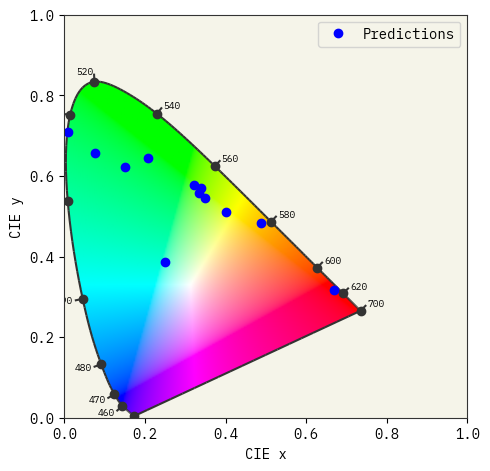

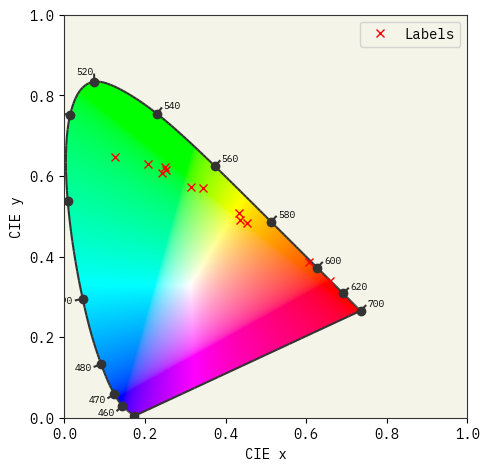

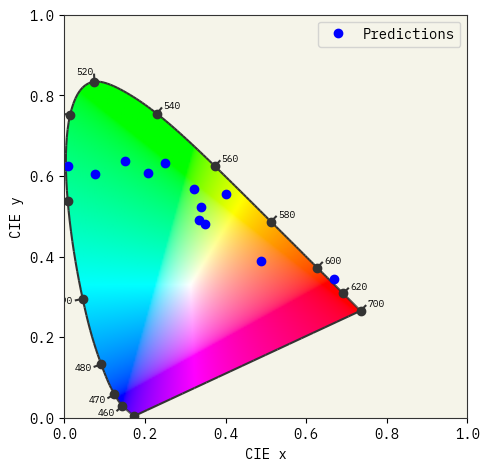

In [23]:
#plot chromaticity diagrams for the CIE_x and CIE_y
from colour.plotting import plot_chromaticity_diagram_CIE1931, render
import matplotlib.pyplot as plt
# Setting up the plot
plot_chromaticity_diagram_CIE1931(show=False, title = "")

# Plot predictions
# plt.title("")
plt.plot(means_y_hats_CIE_x, means_y_hats_CIE_y, "o", color="blue", label="Predictions")
plt.legend()
plt.show()
plot_chromaticity_diagram_CIE1931(show=False,title="")
# plt.title("")
# Plot labels
plt.plot(y_CIE_x[0], y_CIE_y[0], "x", color="red", label="Labels")
plt.legend()
plt.show()
# Annotate

#now with the CIE_y using the CIE_x as input
plot_chromaticity_diagram_CIE1931(show=False, title = "")
plt.plot(means_y_hats_CIE_x, means_y_hats_CIE_y_withxfirst, "o", color="blue", label="Predictions")
plt.legend()
plt.show()

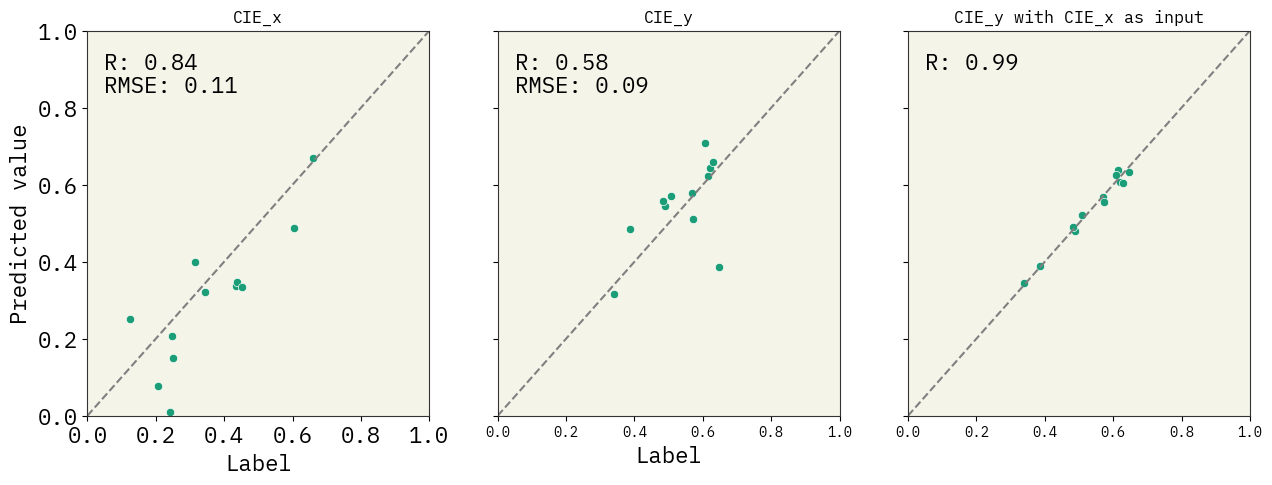

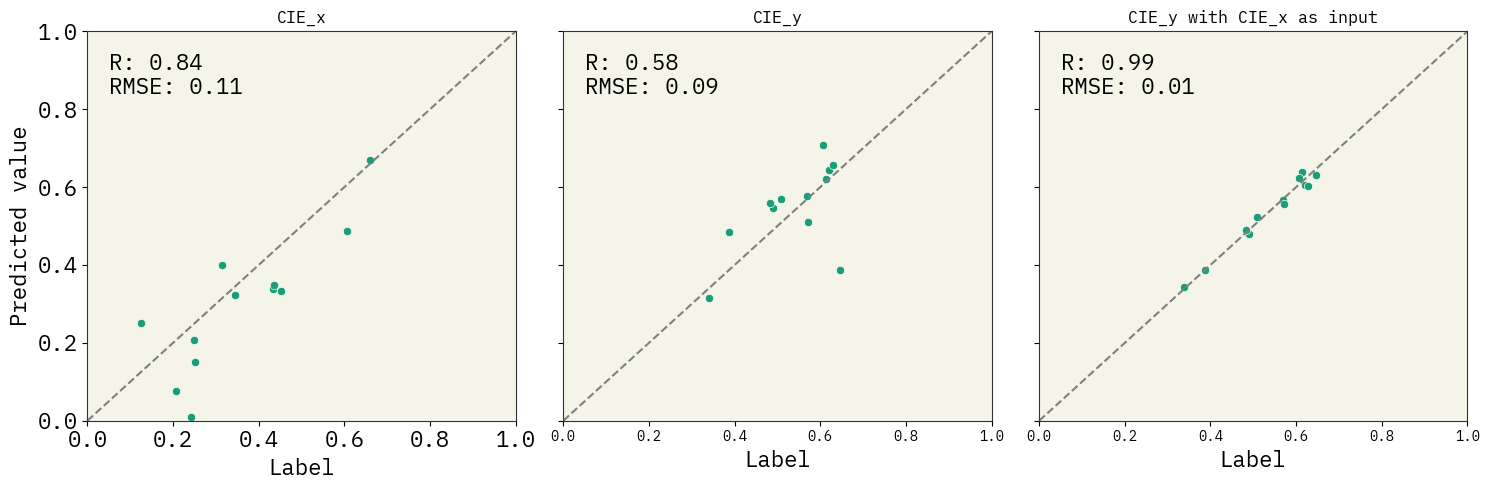

In [25]:
#make the scatter plots for the CIE_x and CIE_y
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
axs[0].set_title("CIE_x")
sns.scatterplot(x=y_CIE_x[0], y=means_y_hats_CIE_x, ax=axs[0], color='C0')
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
#include correlation coefficient
axs[0].text(0.05, 0.90, f"R: {np.corrcoef(y_CIE_x[0], means_y_hats_CIE_x)[0, 1]:.2f}", transform=axs[0].transAxes, fontsize=16)
axs[0].text(0.05, 0.84, f"RMSE: {np.sqrt(np.mean((np.array(y_CIE_x[0]) - means_y_hats_CIE_x)**2)):.2f}", transform=axs[0].transAxes, fontsize=16)
axs[0].set_xlabel("Label", fontsize=16)
axs[0].set_ylabel("Predicted value", fontsize=16)
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
#increase ticks labels size
axs[0].tick_params(axis='both', which='major', labelsize=16)

axs[1].set_title("CIE_y")
sns.scatterplot(x=y_CIE_y[0], y=means_y_hats_CIE_y, ax=axs[1], color='C0')
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
#include correlation coefficient
axs[1].text(0.05, 0.90, f"R: {np.corrcoef(y_CIE_y[0], means_y_hats_CIE_y)[0, 1]:.2f}", transform=axs[1].transAxes, fontsize=16)
axs[1].text(0.05, 0.84, f"RMSE: {np.sqrt(np.mean((np.array(y_CIE_y[0]) - means_y_hats_CIE_y)**2)):.2f}", transform=axs[1].transAxes, fontsize=16)
axs[1].set_xlabel("Label", fontsize=16)
axs[1].set_ylabel("Predicted value", fontsize=16)
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)

axs[2].set_title("CIE_y with CIE_x as input")
sns.scatterplot(x=y_CIE_y[0], y=means_y_hats_CIE_y_withxfirst, ax=axs[2], color='C0')
axs[2].plot([0, 1], [0, 1], transform=axs[2].transAxes, ls="--", color="gray")
#include correlation coefficient
axs[2].text(0.05, 0.90, f"R: {np.corrcoef(y_CIE_y[0], means_y_hats_CIE_y_withxfirst)[0, 1]:.2f}", transform=axs[2].transAxes, fontsize=16)
axs[2].text(0.05, 0.84, f"RMSE: {np.sqrt(np.mean((np.array(y_CIE_y[0]) - means_y_hats_CIE_y_withxfirst)**2)):.2f}", transform=axs[2].transAxes, fontsize=16)
axs[2].set_xlabel("Label", fontsize=16)
axs[2].set_ylabel("Predicted value", fontsize=16)

plt.tight_layout()
plt.show()


In [41]:
#code to get the predictions for the CIE_x and CIE_y
#using the GPT-4o model and 5 fold cross validation
y_hats_CIE_x =[]
y_hats_CIE_y =[]
y_hats_CIE_y_withxfirst = []
y_hats_CIE_y_with_inferred_xfirst = []
y_CIE_x = []
y_CIE_y = []
k_s = [5, 50]
for i in range(1):
    print(f"Fold {i+1}")
    test_indexes = folds[i]
    train_indexes = np.concatenate([folds[j] for j in range(5) if j != i])
    test_df = df.iloc[test_indexes]
    train_df = df.iloc[train_indexes]

    asktell_CIEx = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="The 'CIE 1931 2 Degree Standard Observer' x (red) coordinate from the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7,
        k=5
    )
    asktell_CIEy_with_xfirst = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="The 'CIE 1931 2 Degree Standard Observer' y (green) coordinate from the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7,
        k=5
    )
    asktell_CIEy_with_inferred_xfirst = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="The 'CIE 1931 2 Degree Standard Observer' y (green) coordinate from the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7,
        k=5
    )
    asktell_CIEy = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="The 'CIE 1931 2 Degree Standard Observer' y (green) coordinate from the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7,
        k=5
    )

    for i in range(len(train_df)):
        asktell_CIEx.tell(train_df['Prompt'].iloc[i], train_df['CIE_x'].iloc[i])

    for i in range(len(train_df)):
        asktell_CIEy.tell(train_df['Prompt'].iloc[i], train_df['CIE_y'].iloc[i])


    yhat_1=[]
    yhat_2=[]
    yhat_3=[]
    y_1=[]
    y_2=[]
    y_3 = []
    for i in test_df.index:
        yhat_1.append(asktell_CIEx.predict(df['Prompt'][i])) #system_message=system_message))
        yhat_2.append(asktell_CIEy.predict(df['Prompt'][i])) #system_message=system_message))
        y_1.append(test_df['CIE_x'][i])
        y_2.append(test_df['CIE_y'][i])
        print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {test_df['CIE_x'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {test_df['CIE_y'][i]}")
    y_hats_CIE_x.append(yhat_1)
    y_hats_CIE_y.append(yhat_2)

    y_CIE_x.append(y_1)
    y_CIE_y.append(y_2)

    #train the model for the CIE_y using the CIE_x as input
    for i in range(len(train_df)):
        asktell_CIEy_with_xfirst.tell(train_df['Prompt'].iloc[i] +  "Knowing the CIE_x value is " + str(train_df['CIE_x'].iloc[i]) + "###", train_df['CIE_y'].iloc[i])
        asktell_CIEy_with_inferred_xfirst.tell(train_df['Prompt'].iloc[i] +  "Knowing the CIE_x value is " + str(train_df['CIE_x'].iloc[i]) + "###", train_df['CIE_y'].iloc[i])
    yhat_2=[]
    y_2=[]
    for num, i in enumerate(test_df.index):
        yhat_2.append(asktell_CIEy_with_xfirst.predict(test_df['Prompt'][i] + "Knowing the CIE_x value is " + str(test_df['CIE_x'][i]) + "###")) #system_message=system_message))
        y_2.append(test_df['CIE_y'][i])
        print(f"{yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {test_df['CIE_y'][i]}")
        yhat_3.append(asktell_CIEy_with_inferred_xfirst.predict(test_df['Prompt'][i] + "Knowing the CIE_x value is " + str(yhat_1[num].mean()) + "###")) #system_message=system_message))
    y_hats_CIE_y_withxfirst.append(yhat_2)
    y_CIE_y.append(y_2)
    y_hats_CIE_y_with_inferred_xfirst.append(yhat_3)
    break

Fold 1


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.33+/-0.00 : 0.434414396086 // 0.57+/-0.12 : 0.508303464483


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.14+/-0.02 : 0.251379670741 // 0.63+/-0.04 : 0.614294308089


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.37+/-0.03 : 0.436089229321 // 0.51+/-0.03 : 0.489465044629


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.32+/-0.01 : 0.34390597269 // 0.58+/-0.12 : 0.568940145251


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.18+/-0.01 : 0.248689496167 // 0.63+/-0.03 : 0.621038853167


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.31+/-0.14 : 0.313690694308 // 0.53+/-0.04 : 0.571878429115


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.34+/-0.01 : 0.451884884484 // 0.55+/-0.02 : 0.483065606105


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.49+/-0.01 : 0.605660003479 // 0.47+/-0.00 : 0.386337599064


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.68+/-0.02 : 0.658767415803 // 0.32+/-0.01 : 0.339308124846


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.36+/-0.11 : 0.124707770088 // 0.45+/-0.00 : 0.645863938604


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.12+/-0.10 : 0.206612310612 // 0.64+/-0.06 : 0.628832537346


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.01+/-0.19 : 0.242421319414 // 0.64+/-0.06 : 0.607213300653


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.53+/-0.00 : 0.508303464483


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.63+/-0.00 : 0.614294308089


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.48+/-0.12 : 0.489465044629


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.57+/-0.01 : 0.568940145251


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.61+/-0.12 : 0.621038853167


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.57+/-0.06 : 0.571878429115


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.49+/-0.01 : 0.483065606105


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.37+/-0.01 : 0.386337599064


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.34+/-0.00 : 0.339308124846


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.61+/-0.08 : 0.645863938604


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.61+/-0.01 : 0.628832537346


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


0.56+/-0.03 : 0.607213300653


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


In [43]:
means_y_hats_CIE_x = [y.mean() for y in y_hats_CIE_x[0]]
# means_y_CIE_x = np.mean(y_CIE_x, axis=0)
means_y_hats_CIE_y = [y.mean() for y in y_hats_CIE_y[0]]
# means_y_CIE_y = np.mean(y_CIE_y, axis=0)
means_y_hats_CIE_y_withxfirst = [y.mean() for y in y_hats_CIE_y_withxfirst[0]]
means_y_hats_CIE_y_with_inferred_xfirst = [y.mean() for y in y_hats_CIE_y_with_inferred_xfirst[0]]
print(means_y_hats_CIE_x, means_y_hats_CIE_y, means_y_hats_CIE_y_withxfirst, means_y_hats_CIE_y)
# print(means_y_hats_CIE_x, means_y_hats_CIE_y, means_y_hats_CIE_y_withxfirst)
std_y_hats_CIE_x = [y.std() for y in y_hats_CIE_x[0]]
# std_y_CIE_x = np.std(y_CIE_x, axis=0)
std_y_hats_CIE_y = [y.std() for y in y_hats_CIE_y[0]]
# std_y_CIE_y = np.std(y_CIE_y, axis=0)
std_y_hats_CIE_y_withxfirst = [y.std() for y in y_hats_CIE_y_withxfirst[0]]
std_y_hats_CIE_y_with_inferred_xfirst = [y.std() for y in y_hats_CIE_y_with_inferred_xfirst[0]]
# print(std_y_hats_CIE_x, std_y_hats_CIE_y, std_y_hats_CIE_y_withxfirst)

[0.33400000000000007, 0.13800000000000001, 0.37400000000000005, 0.32000000000000001, 0.18200000000000002, 0.30800000000000005, 0.34400000000000003, 0.48799999999999999, 0.67600000000000005, 0.35799999999999998, 0.12400000000000001, 0.01] [0.56999999999999995, 0.63200000000000001, 0.50600000000000001, 0.57999999999999996, 0.63400000000000001, 0.53200000000000003, 0.54800000000000004, 0.46600000000000008, 0.316, 0.45200000000000007, 0.63800000000000001, 0.63600000000000001] [0.52600000000000002, 0.628, 0.47999999999999998, 0.57000000000000006, 0.60999999999999999, 0.56800000000000006, 0.49000000000000005, 0.37400000000000005, 0.34400000000000003, 0.6100000000000001, 0.6140000000000001, 0.56000000000000005] [0.56999999999999995, 0.63200000000000001, 0.50600000000000001, 0.57999999999999996, 0.63400000000000001, 0.53200000000000003, 0.54800000000000004, 0.46600000000000008, 0.316, 0.45200000000000007, 0.63800000000000001, 0.63600000000000001]


In [29]:
means_y_hats_CIE_y_with_inferred_xfirst = [y.mean() for y in y_hats_CIE_y_with_inferred_xfirst[0]]
print(means_y_hats_CIE_y_with_inferred_xfirst)
std_y_hats_CIE_y_with_inferred_xfirst = [y.std() for y in y_hats_CIE_y_with_inferred_xfirst[0]]

[0.56999999999999995, 0.70800000000000007, 0.53000000000000003, 0.57000000000000006, 0.64600000000000002, 0.51000000000000001, 0.55000000000000004, 0.47199999999999998, 1236.0008000000003, 0.4900000000000001, 0.66400000000000003, 0.746]


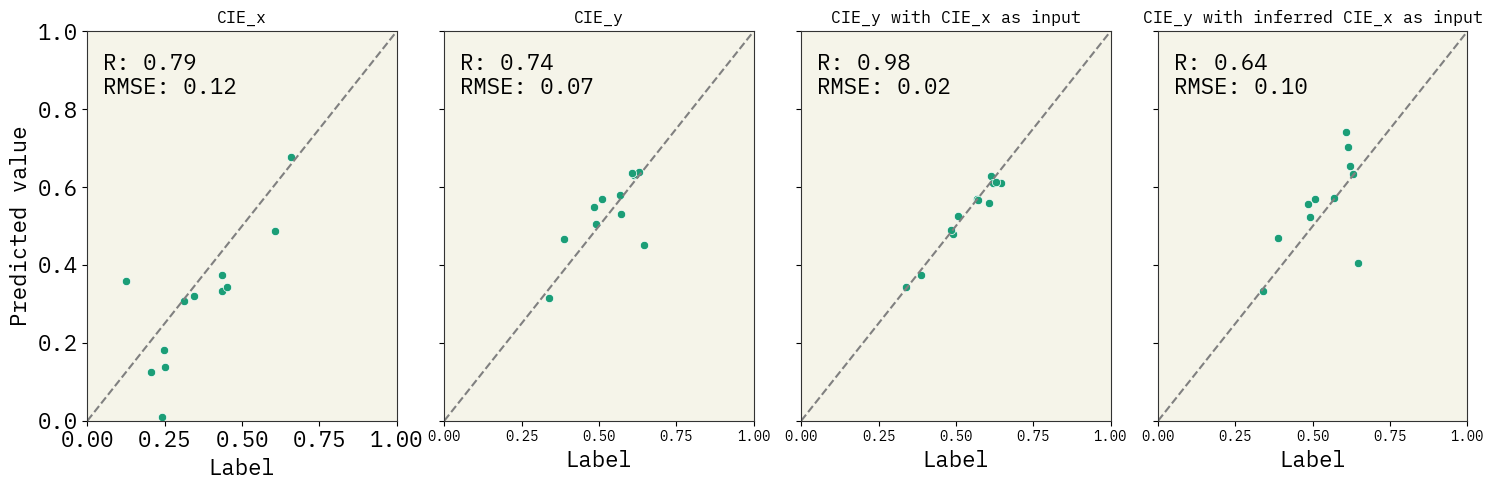

In [53]:
#make the scatter plots for the CIE_x and CIE_y
fig, axs = plt.subplots(1, 4, figsize=(15,5), sharex=True, sharey=True)
axs[0].set_title("CIE_x")
#REMOVE THE OUTLIERS

sns.scatterplot(x=y_CIE_x[0], y=means_y_hats_CIE_x, ax=axs[0], color='C0')
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
#include correlation coefficient
axs[0].text(0.05, 0.90, f"R: {np.corrcoef(y_CIE_x[0], means_y_hats_CIE_x)[0, 1]:.2f}", transform=axs[0].transAxes, fontsize=16)
axs[0].text(0.05, 0.84, f"RMSE: {np.sqrt(np.mean((np.array(y_CIE_x[0]) - means_y_hats_CIE_x)**2)):.2f}", transform=axs[0].transAxes, fontsize=16)
axs[0].set_xlabel("Label", fontsize=16)
axs[0].set_ylabel("Predicted value", fontsize=16)
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
#increase ticks labels size
axs[0].tick_params(axis='both', which='major', labelsize=16)

axs[1].set_title("CIE_y")
sns.scatterplot(x=y_CIE_y[0], y=means_y_hats_CIE_y, ax=axs[1], color='C0')
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
#include correlation coefficient
axs[1].text(0.05, 0.90, f"R: {np.corrcoef(y_CIE_y[0], means_y_hats_CIE_y)[0, 1]:.2f}", transform=axs[1].transAxes, fontsize=16)
axs[1].text(0.05, 0.84, f"RMSE: {np.sqrt(np.mean((np.array(y_CIE_y[0]) - means_y_hats_CIE_y)**2)):.2f}", transform=axs[1].transAxes, fontsize=16)
axs[1].set_xlabel("Label", fontsize=16)
axs[1].set_ylabel("Predicted value", fontsize=16)
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)

axs[2].set_title("CIE_y with CIE_x as input")
sns.scatterplot(x=y_CIE_y[0], y=means_y_hats_CIE_y_withxfirst, ax=axs[2], color='C0')
axs[2].plot([0, 1], [0, 1], transform=axs[2].transAxes, ls="--", color="gray")
#include correlation coefficient
axs[2].text(0.05, 0.90, f"R: {np.corrcoef(y_CIE_y[0], means_y_hats_CIE_y_withxfirst)[0, 1]:.2f}", transform=axs[2].transAxes, fontsize=16)
axs[2].text(0.05, 0.84, f"RMSE: {np.sqrt(np.mean((np.array(y_CIE_y[0]) - means_y_hats_CIE_y_withxfirst)**2)):.2f}", transform=axs[2].transAxes, fontsize=16)
axs[2].set_xlabel("Label", fontsize=16)
axs[2].set_ylabel("Predicted value", fontsize=16)


#make the scatter plots for the CIE_x and CIE_y
# fig, axs = plt.subplots(1, 4, figsize=(15,5), sharex=True, sharey=True)
axs[3].set_title("CIE_y with inferred CIE_x as input")
#REMOVE THE OUTLIERS
filtered_y_CIE_y = [y for y,z in zip(y_CIE_y[0],means_y_hats_CIE_y_with_inferred_xfirst) if z < 1]
filtered_means_y_hats_CIE_y_with_inferred_xfirst = [z for y,z in zip(y_CIE_y[0],means_y_hats_CIE_y_with_inferred_xfirst) if z < 1]
# filtered_means_y_hats_CIE_y_with_inferred_xfirst = [y for y in means_y_hats_CIE_y_with_inferred_xfirst if y < 1]
sns.scatterplot(x=filtered_y_CIE_y, y=filtered_means_y_hats_CIE_y_with_inferred_xfirst, ax=axs[3], color='C0')
axs[3].plot([0, 1], [0, 1], transform=axs[3].transAxes, ls="--", color="gray")
#include correlation coefficient
axs[3].text(0.05, 0.90, f"R: {np.corrcoef(filtered_y_CIE_y, filtered_means_y_hats_CIE_y_with_inferred_xfirst)[0, 1]:.2f}", transform=axs[3].transAxes, fontsize=16)    
axs[3].text(0.05, 0.84, f"RMSE: {np.sqrt(np.mean((np.array(filtered_y_CIE_y) - filtered_means_y_hats_CIE_y_with_inferred_xfirst)**2)):.2f}", transform=axs[3].transAxes, fontsize=16)
axs[3].set_xlabel("Label", fontsize=16)
axs[3].set_ylabel("Predicted value", fontsize=16)
#set the limits
axs[3].set_xlim(0, 1)
axs[3].set_ylim(0, 1)


plt.tight_layout()
plt.show()



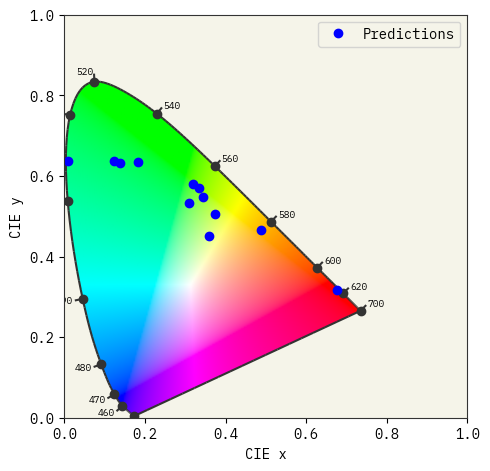

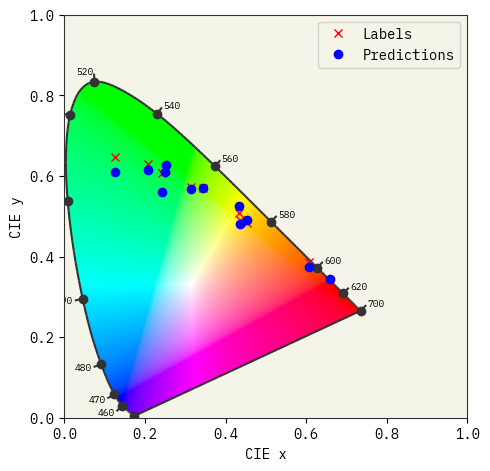

In [56]:
#plot chromaticity diagrams for the CIE_x and CIE_y
from colour.plotting import plot_chromaticity_diagram_CIE1931, render
import matplotlib.pyplot as plt
# Setting up the plot
plot_chromaticity_diagram_CIE1931(show=False, title = "")

# Plot predictions
# plt.title("")
plt.plot(means_y_hats_CIE_x, means_y_hats_CIE_y, "o", color="blue", label="Predictions")
plt.legend()
plt.show()
plot_chromaticity_diagram_CIE1931(show=False,title="")
# plt.title("")
# Plot labels
plt.plot(y_CIE_x[0], y_CIE_y[0], "x", color="red", label="Labels")
plt.plot(y_CIE_x[0], means_y_hats_CIE_y_withxfirst, "o", color="blue", label="Predictions")
plt.legend()
plt.show()
# Annotate

#now with the CIE_y using the CIE_x as input
# plot_chromaticity_diagram_CIE1931(show=False, title = "")
# plt.legend()
# plt.show()

In [ ]:
[0]

[0.50830346448300001,
 0.61429430808899999,
 0.48946504462899998,
 0.56894014525100001,
 0.62103885316700003,
 0.57187842911499998,
 0.48306560610499999,
 0.386337599064,
 0.33930812484599998,
 0.64586393860400004,
 0.62883253734599998,
 0.60721330065300005]

In [45]:
means_y_hats_CIE_y_with_inferred_xfirst

[0.56999999999999995,
 0.70399999999999996,
 0.52400000000000002,
 0.57199999999999995,
 0.65400000000000003,
 386.62400000000002,
 0.55600000000000005,
 0.46999999999999997,
 0.33200000000000002,
 0.40400000000000008,
 0.63400000000000001,
 0.74199999999999999]

In [54]:
#code to get the predictions for the CIE_x and CIE_y
#using the GPT-4o model and 5 fold cross validation
y_hats_CIE_x =[]
y_hats_CIE_y =[]
y_CIE_x = []
y_CIE_y = []
prompts_all_folds = []
for i in range(5):
    print(f"Fold {i+1}")
    test_indexes = folds[i]
    train_indexes = np.concatenate([folds[j] for j in range(5) if j != i])
    test_df = df.iloc[test_indexes]
    train_df = df.iloc[train_indexes]

    asktell_CIEx = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="The 'CIE 1931 2 Degree Standard Observer' x (red) coordinate from the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7
    )

    asktell_CIEy = bolift.AskTellFewShotTopk(
        prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="The 'CIE 1931 2 Degree Standard Observer' y (green) coordinate from the fluorescence spectrum",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7
    )

    for i in range(len(train_df)):
        asktell_CIEx.tell(train_df['Prompt'].iloc[i], train_df['CIE_x'].iloc[i])
        # if i >5:
            # break

    for i in range(len(train_df)):
        asktell_CIEy.tell(train_df['Prompt'].iloc[i], train_df['CIE_y'].iloc[i])
        # if i >5:
            # break


    yhat_1=[]
    yhat_2=[]
    y_1=[]
    y_2=[]
    prompts = []
    for i in test_df.index:
        x=asktell_CIEx.format_x(df.iloc[test_indexes].iloc[1]['Prompt'])
        y = asktell_CIEx._y_name
        # print(x)
        # print(y)
        # print(asktell_CIEx.ask(x))
        prompt = asktell_CIEx.prompt.format(x=x,y_name=y)
        yhat_1.append(asktell_CIEx.predict(df['Prompt'][i]).mean()) #system_message=system_message))
        yhat_2.append(asktell_CIEy.predict(df['Prompt'][i]).mean()) #system_message=system_message))
        y_1.append(test_df['CIE_x'][i])
        y_2.append(test_df['CIE_y'][i])
        prompts.append(prompt)    
        # break
        # print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {test_df['CIE_x'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {test_df['CIE_y'][i]}")
    y_hats_CIE_x.append(yhat_1)
    y_hats_CIE_y.append(yhat_2)
    y_CIE_x.append(y_1)
    y_CIE_y.append(y_2)
    prompts_all_folds.append(prompts)
    # break

#flatten all the arrays
y_hats_CIE_x = np.array(y_hats_CIE_x).flatten()
y_hats_CIE_y = np.array(y_hats_CIE_y).flatten()
y_CIE_x = np.array(y_CIE_x).flatten()
y_CIE_y = np.array(y_CIE_y).flatten()
prompts_all_folds = np.array(prompts_all_folds).flatten()


#save the results to a csv file
dataframe = {
    'y_hats_CIE_x': y_hats_CIE_x,
    'y_hats_CIE_y': y_hats_CIE_y,
    'y_CIE_x': y_CIE_x,
    'y_CIE_y': y_CIE_y,
    'prompts': prompts_all_folds
}

df = pd.DataFrame(dataframe)
df.to_csv("Data/cv_CIE_gpt4o_prompts.csv", index=False)
    



Fold 1


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 2


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 3


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 4


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 5


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [57]:
prompts

["Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n\n\nQ: Given the experimental procedure: Stock nanoplatelets have dimensions 31.63 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10 mL of MeOH and 4 mL of water. 1.0 % Ag doping requires 3.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes., what is The 'CIE 1931 2 Degree Standard Observer' x (red) coordinate from the fluorescence spectrum?\nA: 0.61###\n\n\n\nQ: Given the experimental procedure: Stock nanoplatelets have dimensions 31.63 nm by 13.8 nm and the optical density of 

In [58]:
flattened_y_hats_CIE_x = np.array([])
flattened_y_hats_CIE_y = np.array([])
flattened_y_CIE_x = np.array([])
flattened_y_CIE_y = np.array([])
flattened_prompts = np.array([])
for i, array in enumerate((y_hats_CIE_x, y_hats_CIE_y, y_CIE_x, y_CIE_y,prompts_all_folds)):
    for sub_array in array:
        for elem in sub_array:
            if i == 0:
                print(elem)
                flattened_y_hats_CIE_x= np.append(flattened_y_hats_CIE_x,elem)
            elif i == 1:
                flattened_y_hats_CIE_y= np.append(flattened_y_hats_CIE_y,elem)
            elif i == 2:
                flattened_y_CIE_x= np.append(flattened_y_CIE_x,elem)
            elif i == 3:
                flattened_y_CIE_y= np.append(flattened_y_CIE_y,elem)
            else:
                flattened_prompts = np.append(flattened_prompts,elem)
assert len(flattened_y_hats_CIE_x) == len(flattened_y_CIE_x)
assert len(flattened_y_hats_CIE_y) == len(flattened_y_CIE_y)
assert len(flattened_y_hats_CIE_x) == len(flattened_prompts)


0.37000000000000005
0.44000000000000006
0.252
0.3980000000000001
0.486
3.8680000000000003
0.38400000000000006
0.38
0.268
0.344
0.274
0.10200000000000001
0.35
0.31200000000000006
0.48200000000000004
0.4600000000000001
0.28800000000000003
0.38800000000000007
0.38
0.48800000000000004
0.42200000000000004
0.178
0.4660000000000001
0.26200000000000007
0.128
0.10600000000000001
0.058
0.21
0.31999999999999995
0.472
0.654
0.244
0.406
0.36000000000000004
0.03
0.10200000000000001
0.44399999999999995
0.33
0.536
0.56
0.382
0.11000000000000001
0.41800000000000004
0.4040000000000001
0.58
0.38000000000000006
0.506
0.464
0.23
0.43200000000000005
0.302
0.28200000000000003
0.486
0.67
0.27
0.278


In [61]:
#save all flattened data to a csv file
dataframe = {
    'y_hats_CIE_x': flattened_y_hats_CIE_x,
    'y_hats_CIE_y': flattened_y_hats_CIE_y,
    'y_CIE_x': flattened_y_CIE_x,
    'y_CIE_y': flattened_y_CIE_y,
    'prompts': flattened_prompts
}

df = pd.DataFrame(dataframe)
df.to_csv("Data/cv_CIE_gpt4o_prompts.csv", index=False)

In [60]:
flattened_prompts.shape

(56,)

In [51]:
np.shape(flattened_y_hats_CIE_x)

(56,)

In [14]:
!pip show langchain

Name: langchain
Version: 0.3.3
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages
Requires: aiohttp, async-timeout, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: bolift, langchain-community


### Saving obtained data (every experiment costs money)

In [305]:

# import pickle
# with open('Data/BO-ICL_y_hats_CIE_x.pkl', 'wb') as f:
#     pickle.dump(y_hats_CIE_x, f)
# with open('Data/BO-ICL_y_hats_CIE_y.pkl', 'wb') as f:
#     pickle.dump(y_hats_CIE_y, f)
# with open('Data/BO-ICL_y_CIE_x.pkl', 'wb') as f:
#     pickle.dump(y_CIE_x, f)
# with open('Data/BO-ICL_y_CIE_y.pkl', 'wb') as f:
#     pickle.dump(y_CIE_y, f)


In [4]:
#load the data
import pickle
with open('Data/BO-ICL_y_hats_CIE_x.pkl', 'rb') as f:
    y_hats_CIE_x = pickle.load(f)
with open('Data/BO-ICL_y_hats_CIE_y.pkl', 'rb') as f:
    y_hats_CIE_y = pickle.load(f)
with open('Data/BO-ICL_y_CIE_x.pkl', 'rb') as f:
    y_CIE_x = pickle.load(f)
with open('Data/BO-ICL_y_CIE_y.pkl', 'rb') as f:
    y_CIE_y = pickle.load(f)
    

Fold 1
RMSE CIE_x: 0.07
Fold 2
RMSE CIE_x: 0.18
Fold 3
RMSE CIE_x: 0.13
Fold 4
RMSE CIE_x: 0.06
Fold 5
RMSE CIE_x: 0.10


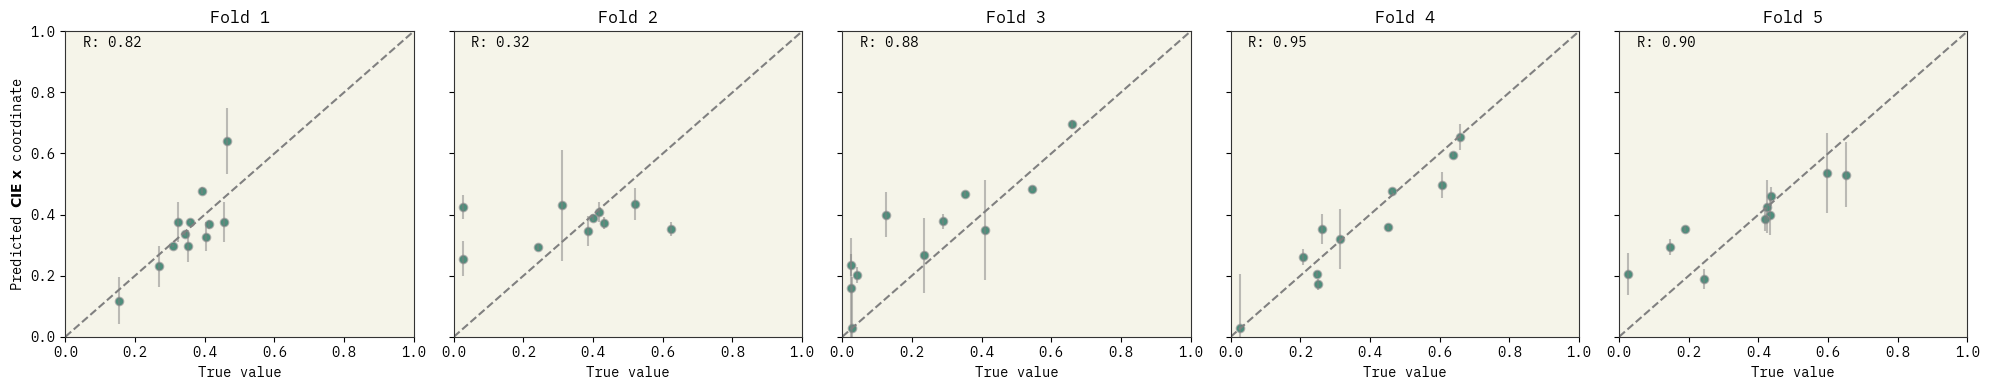

<Figure size 500x416.667 with 0 Axes>

Fold 1
RMSE CIE_y: 0.04
Fold 2
RMSE CIE_y: 0.08
Fold 3
RMSE CIE_y: 0.13
Fold 4
RMSE CIE_y: 0.06
Fold 5
RMSE CIE_y: 0.08


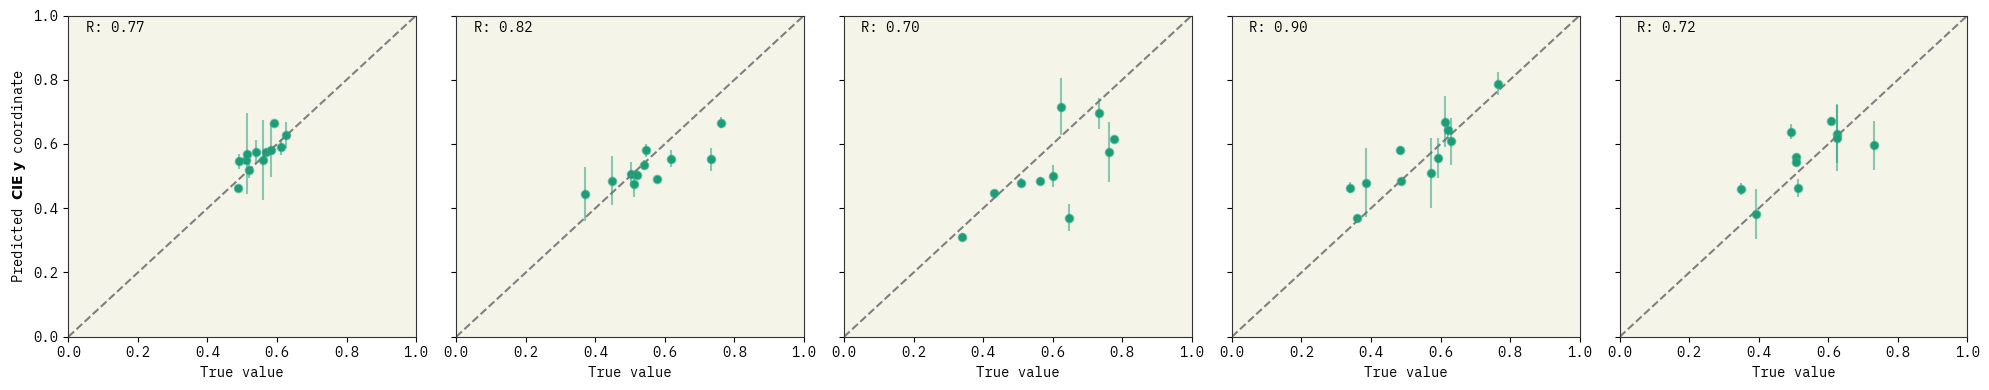

Fold 1


<Figure size 500x416.667 with 0 Axes>

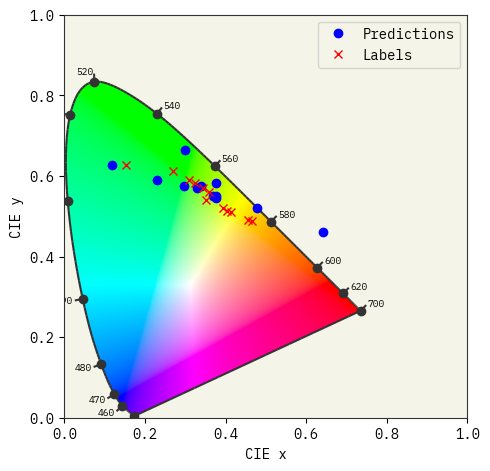

Fold 2


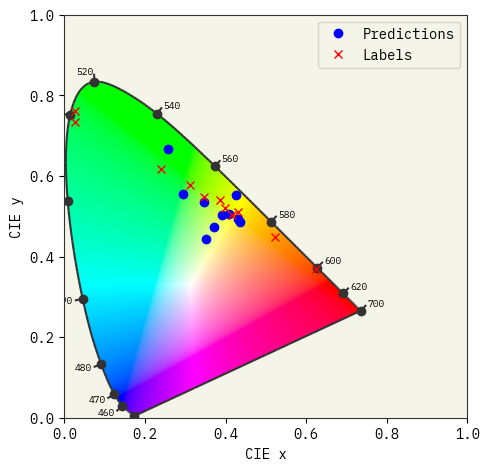

Fold 3


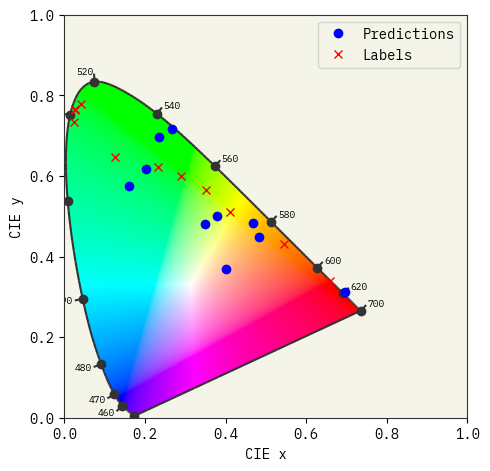

Fold 4


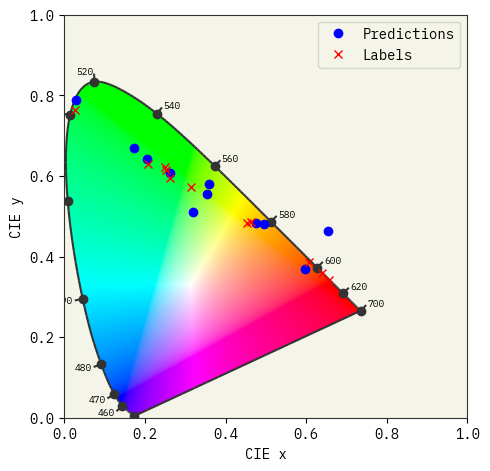

Fold 5


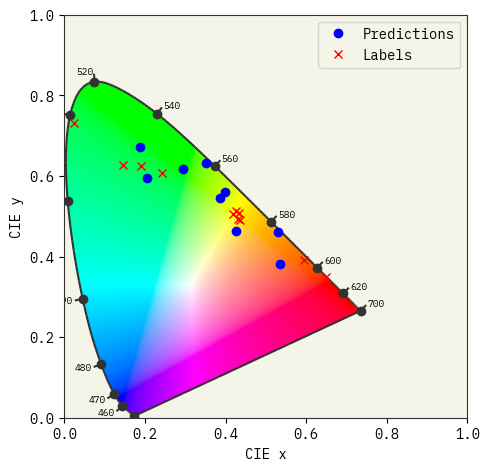

<Figure size 500x416.667 with 0 Axes>

In [304]:
#plot 5 scatter plots one for ciex and one for ciey for each fold
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
#remove values bigger than one in both hats and y
# y_hats_CIE_x = [[yi for yi in yhat if yi.mean() <= 1] for yhat in y_hats_CIE_x]
# y_hats_CIE_y = [[yi for yi in yhat if yi.mean() <= 1] for yhat in y_hats_CIE_y]
# y_CIE_x = [[yi for yi in y if yi <= 1] for y in y_CIE_x]

for i, (y_1, yhat1, ax) in enumerate(zip(y_CIE_x, y_hats_CIE_x, axs)):
    y_1 = np.array(y_1)
    yhat1_mean = np.array([yi.mean() for yi in yhat1 if yi.mean()])
    yhat1_std = np.array([yi.std() for yi in yhat1 if yi.mean() <= 1])
    index = np.where(yhat1_mean <= 1)
    y_1 = y_1[index]

    yhat1_mean = yhat1_mean[index]

    print(f"Fold {i+1}")
    print(f"RMSE CIE_x: {np.sqrt(np.mean((np.array(y_1) - np.array([yi for yi in yhat1_mean]))**2)):.2f}")
    
    ax.set_title(f"Fold {i+1}")
    sns.scatterplot(x=y_1, y=[yi for yi in yhat1_mean], ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_1, y=[yi for yi in yhat1_mean], yerr=[yi for yi in yhat1_std], fmt='o', color='gray', alpha=0.5)
    #include correlation coefficient
    ax.text(0.05, 0.95, f"R: {np.corrcoef(y_1, [yi for yi in yhat1_mean])[0, 1]:.2f}", transform=ax.transAxes)
    ax.set_xlabel("True value")
    ax.set_ylabel(r"Predicted $\mathbf{CIE\ x}$ coordinate")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
# plt.suptitle("CIE x")
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

for i, ( y_2, yhat2, ax) in enumerate(zip( y_CIE_y, y_hats_CIE_y, axs)):

    y_2 = np.array(y_2)
    yhat2_mean = np.array([yi.mean() for yi in yhat2 if yi.mean()])
    yhat2_std = np.array([yi.std() for yi in yhat2 if yi.mean() <= 1])
    index = np.where(yhat2_mean <= 1)
    y_2 = y_2[index]

    yhat2_mean = yhat2_mean[index]

    print(f"Fold {i+1}")
    # print(f"RMSE CIE_x: {np.sqrt(np.mean((np.array(y_1) - np.array([yi.mean() for yi in yhat1]))**2)):.2f}")
    print(f"RMSE CIE_y: {np.sqrt(np.mean((np.array(y_2) - np.array([yi for yi in yhat2_mean]))**2)):.2f}")
    
    # ax.set_title(f"Fold {i+1}")
    sns.scatterplot(x=y_2, y=[yi for yi in yhat2_mean], ax=ax, color='C0')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
    ax.errorbar(x=y_2, y=[yi for yi in yhat2_mean], yerr=[yi for yi in yhat2_std], fmt='o', color='C0',alpha=0.5)
    #include correlation coefficient
    ax.text(0.05, 0.95, f"R: {np.corrcoef(y_2, [yi for yi in yhat2_mean])[0, 1]:.2f}", transform=ax.transAxes)
    ax.set_xlabel("True value")
    ax.set_ylabel(r"Predicted $\mathbf{CIE\ y}$ coordinate")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
# plt.suptitle("CIE y")
plt.tight_layout()
plt.show()

plt.tight_layout()

#for every fold plot the prediction colours

for i in range(5):
    plot_chromaticity_diagram_CIE1931(show=False, title = "")
    print(f"Fold {i+1}")
    yhat_means_x = [yi.mean() for yi in y_hats_CIE_x[i]]
    yhat_means_y = [yi.mean() for yi in y_hats_CIE_y[i]]
    labels_x = y_CIE_x[i]
    labels_y = y_CIE_y[i]
    # Setting up the plot

    # Plot predictions
    # plt.title("")
    plt.plot(yhat_means_x, yhat_means_y, "o", color="blue", label="Predictions")
    plt.legend()
    # plt.show()
    # plot_chromaticity_diagram_CIE1931(show=False,title="")
    # plt.title("")
    # Plot labels
    plt.plot(labels_x, labels_y, "x", color="red", label="Labels")

    # Annotate
    # for i, (px, py, lx, ly) in enumerate(zip(yhat_means_x, yhat_means_y, labels_x, labels_y)):
        # plt.annotate(f"P{i+1}", (px, py), color="blue")
        # plt.annotate(f"L{i+1}", (lx, ly), color="red")
        # if i >3:
            # break

    # Add legend and render
    plt.legend()
    render(show=True, limits=(-0.1, 0.9, -0.1, 0.9), x_tighten=True, y_tighten=True)
# plt.suptitle("CIE_y")
plt.tight_layout()
plt.show()



Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
[ 0.00894427  0.0244949   0.02416609  0.008       0.12505734  0.00979796
  0.03720215  0.08423776  0.02529822  0.01019804  0.12505734  0.03919184]
Fold 1
[ 0.07709734  0.08333067  0.03826225  0.004       0.0257682   0.03487119
  0.0174356   0.02        0.03666061  0.01356466  0.01356466]
Fold 2
[ 0.088       0.0334664   0.01264911  0.04195235  0.012       0.004
  0.0116619   0.008       0.093723    0.048     ]
Fold 3
[ 0.10838606  0.03487119  0.016       0.00489898  0.07194442  0.10838606
  0.06151423  0.01264911  0.07797435  0.00632456  0.0174356 ]
Fold 4
[ 0.00632456  0.028       0.07552483  0.0116619   0.09108238  0.10303397
  0.02        0.01019804  0.07833262  0.024     ]
Fold 5


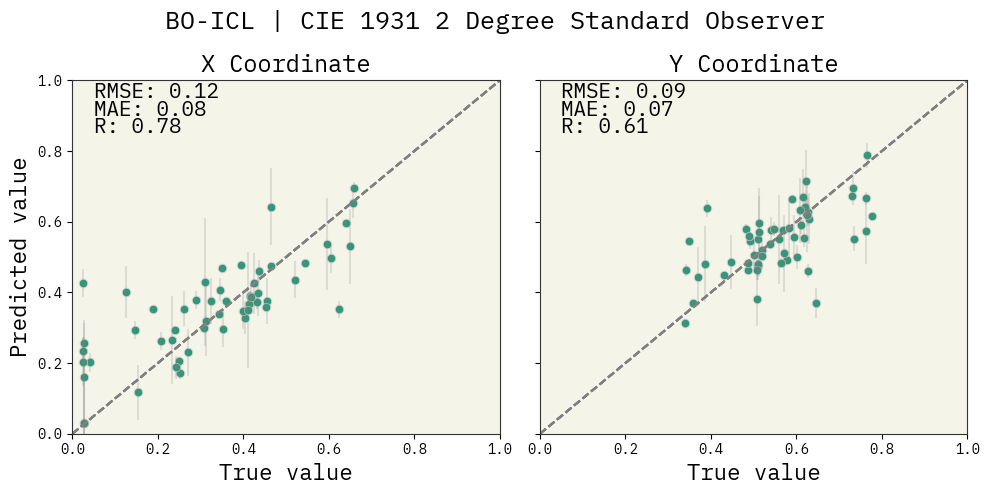

In [13]:
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
all_ys = []
all_yhats = []
# axs[1].errorbar(x=y_2, y=[yi.mean() for yi in yhat_2], yerr=[yi.std() for yi in yhat_2], fmt='o', color='gray', alpha=0.2)

for i, (y_1, yhat1) in enumerate(zip(y_CIE_x, y_hats_CIE_x)):
    y_1 = np.array(y_1)
    yhat_mean = np.array([yi.mean() for yi in yhat1 if yi.mean() <= 1])
    yhat_stds = np.array([yi.std() for yi in yhat1 if yi.mean() <= 1])
    # print(y_stds)
    index = np.where(yhat_mean < 1)
    y_1 = y_1[index]
    # yhat1 = yhat1[index]
    all_ys.extend(y_1)
    all_yhats.extend(yhat_mean)

    print(f"Fold {i+1}")
    # print(f"RMSE CIE_x: {np.sqrt(np.mean((np.array(y_1) - np.array([yi.mean() for yi in yhat1]))**2)):.2f}")
    
    axs[0].set_title(f"X Coordinate", fontsize=17)
    sns.scatterplot(x=y_1, y=[yi for yi in yhat_mean], ax=axs[0], color='C0')
    axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
    axs[0].errorbar(x=y_1, y=[yi for yi in yhat_mean], yerr=[yi for yi in yhat_stds], fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    # axs[0].text(0.05, 0.95, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat1])[0, 1]:.2f}", transform=axs[0].transAxes)
    axs[0].set_ylabel("Predicted value", fontsize=16)
    axs[0].set_xlabel("True value", fontsize=16)
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)
#rmse 
axs[0].text(0.05, 0.95, f"RMSE: {np.sqrt(np.mean((np.array(all_ys) - np.array(all_yhats))**2)):.2f}", transform=axs[0].transAxes,fontsize= 15)
#mae
axs[0].text(0.05, 0.90, f"MAE: {np.mean(np.abs(np.array(all_ys) - np.array(all_yhats))):.2f}", transform=axs[0].transAxes,fontsize= 15)
axs[0].text(0.05, 0.85, f"R: {np.corrcoef(all_ys, all_yhats)[0, 1]:.2f}", transform=axs[0].transAxes,fontsize= 15)
all_ys = []
all_yhats = []
for i, (y_1, yhat1) in enumerate(zip(y_CIE_y, y_hats_CIE_y)):
    y_1 = np.array(y_1)
    yhat_mean = np.array([yi.mean() for yi in yhat1 if yi.mean() <= 1])
    yhat_stds = np.array([yi.std() for yi in yhat1 if yi.mean() <= 1])
    print(yhat_stds)
    index = np.where(yhat_mean < 1)
    y_1 = y_1[index]
    # yhat1 = yhat1[index]
    all_ys.extend(y_1)
    all_yhats.extend(yhat_mean)

    print(f"Fold {i+1}")
    # print(f"RMSE CIE_x: {np.sqrt(np.mean((np.array(y_1) - np.array([yi.mean() for yi in yhat1]))**2)):.2f}")
    
    axs[1].set_title(f"Y Coordinate", fontsize=17)
    sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_mean], ax=axs[1], color='C0')
    #add error bars with y1.std()
    
    axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
    axs[1].errorbar(x=y_1, y=[yi for yi in yhat_mean], yerr=[yi for yi in yhat_stds], fmt='o', color='gray', alpha=0.2)
    #include correlation coefficient
    # axs[1].text(0.05, 0.95, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat1])[0, 1]:.2f}", transform=axs[1].transAxes)
    axs[1].set_ylabel("Predicted value", fontsize=16)
    axs[1].set_xlabel("True value", fontsize=16)
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(0, 1)
#rmse 
axs[1].text(0.05, 0.95, f"RMSE: {np.sqrt(np.mean((np.array(all_ys) - np.array(all_yhats))**2)):.2f}", transform=axs[1].transAxes, fontsize=15)
#maey
axs[1].text(0.05, 0.90, f"MAE: {np.mean(np.abs(np.array(all_ys) - np.array(all_yhats))):.2f}", transform=axs[1].transAxes, fontsize=15)
axs[1].text(0.05, 0.85, f"R: {np.corrcoef(all_ys, all_yhats)[0, 1]:.2f}", transform=axs[1].transAxes, fontsize=15)
plt.suptitle('BO-ICL | CIE 1931 2 Degree Standard Observer', fontsize=18)
plt.tight_layout()
plt.show()

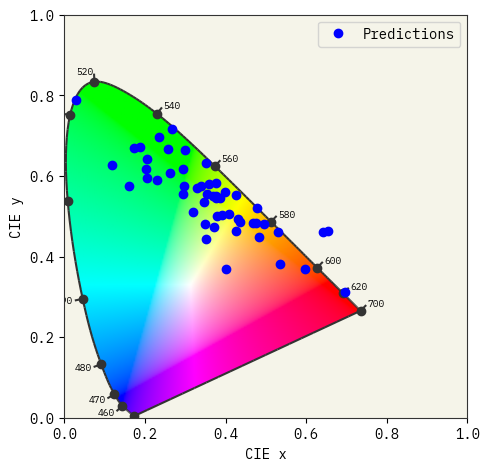

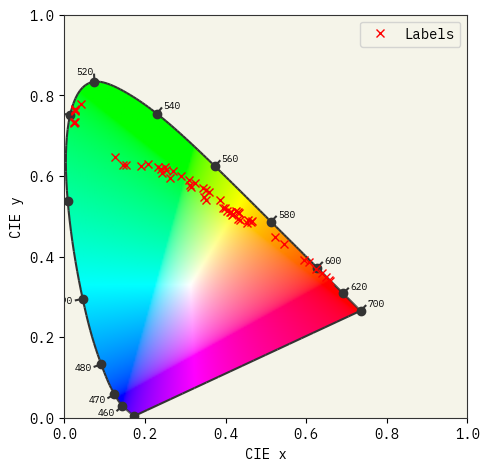

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='CIE x', ylabel='CIE y'>)

In [ ]:
#train and test a gpr with ard_dim =9 and GPMatern 2.5 kernel and LeaveOneOutPseudoLikelihood.
import matplotlib.pyplot as plt
from colour.plotting import plot_chromaticity_diagram_CIE1931, render
plot_chromaticity_diagram_CIE1931(show=False,title="")
for i in range(5):
    
    yhat_means_x = [yi.mean() for yi in y_hats_CIE_x[i]]
    yhat_means_y = [yi.mean() for yi in y_hats_CIE_y[i]]
    labels_x = y_CIE_x[i]
    labels_y = y_CIE_y[i]
    # Setting up the plot
    # plot_chromaticity_diagram_CIE1931(show=False, title = "")

    # Plot predictions
    # plt.title("")
    if i == 0:
        plt.plot(yhat_means_x, yhat_means_y, "o", color="blue", label="Predictions")
    else:
        plt.plot(yhat_means_x, yhat_means_y, "o", color="blue")

# 
    # if i == 0:
        # plt.plot(labels_x, labels_y, "x", color="red", label="Labels")
    # else:
        # plt.plot(labels_x, labels_y, "x", color="red")
    # Add legend and render
plt.legend()
render(show=True, limits=(-0.1, 0.9, -0.1, 0.9), x_tighten=True, y_tighten=True)
plot_chromaticity_diagram_CIE1931(show=False,title="",fontsize=18)
for i in range(5):
    
    yhat_means_x = [yi.mean() for yi in y_hats_CIE_x[i]]
    yhat_means_y = [yi.mean() for yi in y_hats_CIE_y[i]]
    labels_x = y_CIE_x[i]
    labels_y = y_CIE_y[i]
    # Setting up the plot
    # plot_chromaticity_diagram_CIE1931(show=False, title = "")

    # Plot predictions
    # plt.title("")
    # if i == 0:
        # plt.plot(yhat_means_x, yhat_means_y, "o", color="blue", label="Predictions")
    # else:
        # plt.plot(yhat_means_x, yhat_means_y, "o", color="blue")
# 

    if i == 0:
        plt.plot(labels_x, labels_y, "x", color="red", label="Labels")
    else:
        plt.plot(labels_x, labels_y, "x", color="red")

    # plt.plot(labels_x, labels_y, "x", color="red", label="Labels")

    # plt.legend()
    # Annotate
    # for i, (px, py, lx, ly) in enumerate(zip(yhat_means_x, yhat_means_y, labels_x, labels_y)):
        # plt.annotate(f"P{i+1}", (px, py), color="blue")
        # plt.annotate(f"L{i+1}", (lx, ly), color="red")
        # if i >3:
            # break

    # Add legend and render
plt.legend()
render(show=True, limits=(-0.1, 0.9, -0.1, 0.9), x_tighten=True, y_tighten=True)

In [208]:
flat_y_CIE_x = np.hstack(y_CIE_x)
flat_y_CIE_y = np.hstack(y_CIE_y)
# flat_y_CIE_x,flat_y_CIE_y
flat_y_hats_x = np.hstack(y_hats_x)
flat_y_hats_y = np.hstack(y_hats_y)
flat_y_hats_x,flat_y_hats_y

(array([  3.68000000e-01,   2.30000000e-01,   3.76000000e-01,
          3.38000000e-01,   3.28000000e-01,   6.42000000e-01,
          2.96000000e-01,   3.76000000e-01,   4.78000000e-01,
          2.98000000e-01,   3.76000000e-01,   1.18000000e-01,
          4.36000000e-01,   3.52000000e-01,   3.72000000e-01,
          4.30000000e-01,   2.94000000e-01,   4.26000000e-01,
          2.56000000e-01,   3.86418000e+02,   4.08000000e-01,
          3.90000000e-01,   3.46000000e-01,   2.66000000e-01,
          3.78000000e-01,   3.50000000e-01,   4.00000000e-01,
          4.68000000e-01,   4.84000000e-01,   6.96000000e-01,
          2.02000000e-01,   1.60000000e-01,   2.34000000e-01,
          3.00000000e-02,   3.20000000e-01,   3.00000000e-02,
          2.06000000e-01,   4.76000000e-01,   2.62000000e-01,
          4.96000000e-01,   3.54000000e-01,   3.58000000e-01,
          1.72000000e-01,   5.96000000e-01,   6.54000000e-01,
          4.60000000e-01,   3.98000000e-01,   4.26000000e-01,
        

In [211]:
#remove the data whose values are above 1, but in all arrays 
indexes = np.where(flat_y_hats_y < 1)
flat_y_CIE_x = flat_y_CIE_x[indexes]
flat_y_CIE_y = flat_y_CIE_y[indexes]
flat_y_hats_x = flat_y_hats_x[indexes]
flat_y_hats_y = flat_y_hats_y[indexes]


In [212]:
indexes

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52,
        53]),)

In [75]:
flatten_y_CIE_x = [item for sublist in y_CIE_x for item in sublist]
flatten_y_CIE_y = [item for sublist in y_CIE_y for item in sublist]
flatten_y_hats_CIE_x = [item for sublist in y_hats_CIE_x for item in sublist]
flatten_y_hats_CIE_y = [item for sublist in y_hats_CIE_y for item in sublist]
flatten_y_hats_CIE_x = [item.mean() for item in flatten_y_hats_CIE_x]
flatten_y_hats_CIE_y = [item.mean() for item in flatten_y_hats_CIE_y]
# for Cie_X hats and Cie_Y hats, remove any value over 1, remove the same index in the y values
flatten_y_CIE_x = np.array(flatten_y_CIE_x)
flatten_y_CIE_y = np.array(flatten_y_CIE_y)
flatten_y_hats_CIE_x = np.array(flatten_y_hats_CIE_x)
flatten_y_hats_CIE_y = np.array(flatten_y_hats_CIE_y)

flatten_y_CIE_x = flatten_y_CIE_x[flatten_y_hats_CIE_x < 1]
flatten_y_CIE_y = flatten_y_CIE_y[flatten_y_hats_CIE_y < 1]
flatten_y_hats_CIE_x = flatten_y_hats_CIE_x[flatten_y_hats_CIE_x < 1]
flatten_y_hats_CIE_y = flatten_y_hats_CIE_y[flatten_y_hats_CIE_y < 1]


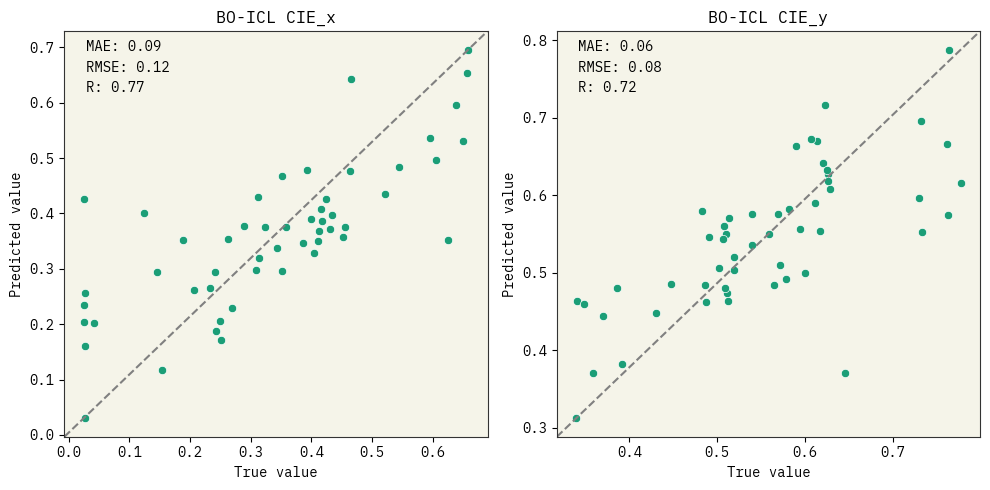

In [236]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs[0].set_title("BO-ICL CIE_x")
sns.scatterplot(x=flat_y_CIE_x, y=flat_y_hats_x, ax=axs[0], color='C0')
axs[0].set_xlabel("True value")
axs[0].set_ylabel("Predicted value")
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
# axs[0].errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs[0].text(0.05, 0.95, f"MAE: {mae(np.array(flat_y_CIE_x), np.array(flat_y_hats_x)):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.90, f"RMSE: {rmse(np.array(flat_y_CIE_x), np.array(flat_y_hats_x)):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.85, f"R: {np.corrcoef(flat_y_CIE_x, flat_y_hats_x)[0, 1]:.2f}", transform=axs[0].transAxes)

axs[1].set_title("BO-ICL CIE_y")
sns.scatterplot(x=flat_y_CIE_y, y=flat_y_hats_y, ax=axs[1], color='C0')
axs[1].set_xlabel("True value")
axs[1].set_ylabel("Predicted value")
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
# axs[1].errorbar(x=y_2, y=[yi.mean() for yi in yhat_2], yerr=[yi.std() for yi in yhat_2], fmt='o', color='gray', alpha=0.2)
axs[1].text(0.05, 0.95, f"MAE: {mae(np.array(flat_y_CIE_y), np.array(flat_y_hats_y)):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.90, f"RMSE: {rmse(np.array(flat_y_CIE_y), np.array(flat_y_hats_y)):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.85, f"R: {np.corrcoef(flat_y_CIE_y, flat_y_hats_y)[0, 1]:.2f}", transform=axs[1].transAxes)

plt.tight_layout()


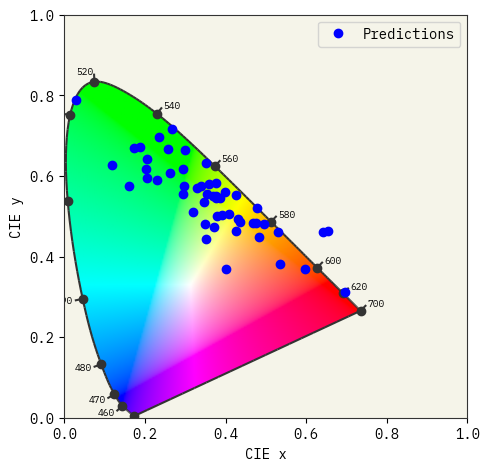

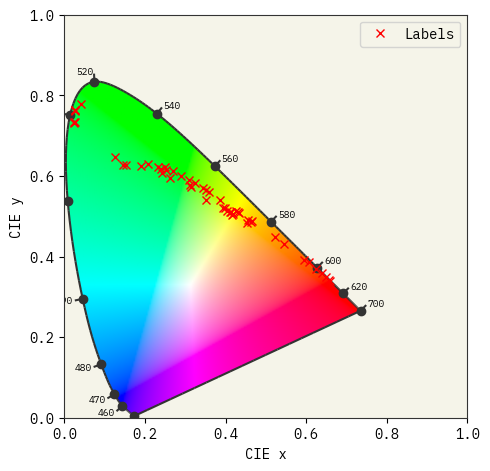

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='CIE x', ylabel='CIE y'>)

In [214]:

# Data from the user
yhat_means_x = flat_y_hats_x
yhat_means_y = flat_y_hats_y
labels_x = flat_y_CIE_x
labels_y = flat_y_CIE_y

# Setting up the plot
plot_chromaticity_diagram_CIE1931(show=False, title = "")

# Plot predictions
# plt.title("")
plt.plot(yhat_means_x, yhat_means_y, "o", color="blue", label="Predictions")
plt.legend()
plt.show()
plot_chromaticity_diagram_CIE1931(show=False,title="")
# plt.title("")
# Plot labels
plt.plot(labels_x, labels_y, "x", color="red", label="Labels")

# Annotate
# for i, (px, py, lx, ly) in enumerate(zip(yhat_means_x, yhat_means_y, labels_x, labels_y)):
    # plt.annotate(f"P{i+1}", (px, py), color="blue")
    # plt.annotate(f"L{i+1}", (lx, ly), color="red")
    # if i >3:
# Add legend and render
        # break

plt.legend()
render(show=True, limits=(-0.1, 0.9, -0.1, 0.9), x_tighten=True, y_tighten=True)

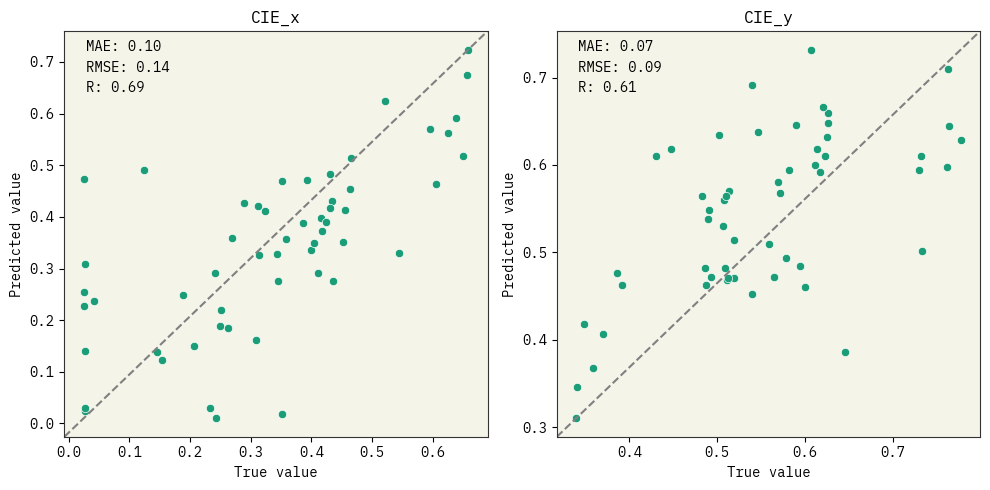

In [79]:
#make two plots for CIE_x and CIE_y
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs[0].set_title("CIE_x")
sns.scatterplot(x=flatten_y_CIE_x, y=flatten_y_hats_CIE_x, ax=axs[0], color='C0')
axs[0].set_xlabel("True value")
axs[0].set_ylabel("Predicted value")
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
# axs[0].errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs[0].text(0.05, 0.95, f"MAE: {mae(np.array(flatten_y_CIE_x), np.array(flatten_y_hats_CIE_x)):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.90, f"RMSE: {rmse(np.array(flatten_y_CIE_x), np.array(flatten_y_hats_CIE_x)):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.85, f"R: {np.corrcoef(flatten_y_CIE_x, flatten_y_hats_CIE_x)[0, 1]:.2f}", transform=axs[0].transAxes)

axs[1].set_title("CIE_y")
sns.scatterplot(x=flatten_y_CIE_y, y=flatten_y_hats_CIE_y, ax=axs[1], color='C0')
axs[1].set_xlabel("True value")
axs[1].set_ylabel("Predicted value")
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
# axs[1].errorbar(x=y_2, y=[yi.mean() for yi in yhat_2], yerr=[yi.std() for yi in yhat_2], fmt='o', color='gray', alpha=0.2)
axs[1].text(0.05, 0.95, f"MAE: {mae(np.array(flatten_y_CIE_y), np.array(flatten_y_hats_CIE_y)):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.90, f"RMSE: {rmse(np.array(flatten_y_CIE_y), np.array(flatten_y_hats_CIE_y)):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.85, f"R: {np.corrcoef(flatten_y_CIE_y, flatten_y_hats_CIE_y)[0, 1]:.2f}", transform=axs[1].transAxes)

plt.tight_layout()


In [82]:
#do the cross validation for the baseline models 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

lr_x = LinearRegression()
lr_y = LinearRegression()
rf_x = RandomForestRegressor()
rf_y = RandomForestRegressor()
svr_x = SVR()
svr_y = SVR()

models_x = [lr_x, rf_x, svr_x]
model_y = [lr_y,rf_y,svr_y]
model_names_x = ["Linear Regression CIE_x", "Random Forest CIE_x", "SVR CIE_x"]
models_names_y = ["Linear Regression CIE_y", "Random Forest CIE_y", "SVR CIE_y"]

y_hats_CIE_x =[]
y_hats_CIE_y =[]
y_CIE_x = []
y_CIE_y = []
for model_x, model_y, name_x, name_y in zip(models_x, model_y, model_names_x, models_names_y):
    for i in range(5):
        print(f"Fold {i+1}")
        test_indexes = folds[i]
        train_indexes = np.concatenate([folds[j] for j in range(5) if j != i])
        test_df = df_structured.iloc[test_indexes]
        train_df = df_structured.iloc[train_indexes]


        #train the models
        model_x.fit(train_df[['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Dilution(%)',
                'Nano_stock_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
                'Doping(%)',  'Time(min)',
                'Temperature(C)']], train_df['CIE_x'])
        model_y.fit(train_df[['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Dilution(%)',
                'Nano_stock_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
                'Doping(%)',  'Time(min)',
                'Temperature(C)']], train_df['CIE_y'])


        yhat_1=[]
        yhat_2=[]
        y_1=[]
        y_2=[]
        # for i in test_df.index:
            #predictions for each 
        yhat_1.append(model_x.predict(test_df[['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Dilution(%)',
                'Nano_stock_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
                'Doping(%)',  'Time(min)',
                'Temperature(C)']])) #system_message=system_message))
        yhat_2.append(model_y.predict(test_df[['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Dilution(%)',
                'Nano_stock_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
                'Doping(%)',  'Time(min)',
                'Temperature(C)']])) #system_message=system_message))
        y_1.append(test_df['CIE_x'])
        y_2.append(test_df['CIE_y'])
        # print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {test_df['CIE_x'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {test_df['CIE_y'][i]}")
        y_hats_CIE_x.append(yhat_1)
        y_hats_CIE_y.append(yhat_2)
        y_CIE_x.append(y_1)
        y_CIE_y.append(y_2)
    
    break

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [103]:
flatten_y_CIE_x = [item for sublist in y_CIE_x for item in sublist]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [115]:
#flatten the flatten_y_cie_x list of lists
# flatten_y_CIE_x = [ item.to_numpy().ravel() for item in flatten_y_CIE_x]
#stack the flatten_y_CIE_x
flatten_y_CIE_x 


array([ 0.62461123,  0.41082294,  0.35850545,  0.02716795,  0.30873864,
        0.39357654,  0.65715504,  0.41605574,  0.65017364,  0.35095678,
        0.12470777,  0.65876742,  0.34534245,  0.31369069,  0.63910276,
        0.02444294,  0.60566   ,  0.4344144 ,  0.54483035,  0.1532759 ,
        0.31120552,  0.02623914,  0.02694148,  0.04185684,  0.28826612,
        0.14551183,  0.34390597,  0.25137967,  0.20661231,  0.02516399,
        0.2486895 ,  0.43153777,  0.52139794,  0.02649846,  0.43106013,
        0.4639325 ,  0.02494756,  0.46473877,  0.26952103,  0.39927988,
        0.38643428,  0.45188488,  0.45548318,  0.18882361,  0.40361865,
        0.24242132,  0.2620459 ,  0.32312039,  0.43608923,  0.42491172,
        0.24029907,  0.59541789,  0.35170117,  0.41336115,  0.23327964,
        0.41822415])

In [118]:
np.hstack(flatten_y_hats_CIE_x)

array([ 0.37600334,  0.27550376,  0.24001649,  0.14751613,  0.29715777,
        0.40132708,  0.67585623,  0.34829425,  0.56025228,  0.32915468,
        0.42322421,  0.80022908,  0.27717917,  0.35195718,  0.62266114,
        0.17398242,  0.51722509,  0.3108182 ,  0.50216733,  0.06177069,
        0.39781077,  0.24434517,  0.27734862,  0.31789611,  0.29152903,
        0.1491976 ,  0.42245592,  0.32729815,  0.19365803,  0.4566071 ,
        0.3660437 ,  0.47531191,  0.47697727,  0.13890873,  0.3193769 ,
        0.28452717,  0.06590746,  0.35367601,  0.28507779,  0.24899271,
        0.4216456 ,  0.37914173,  0.49024382,  0.1840996 ,  0.22998839,
        0.0883697 ,  0.3227658 ,  0.31594405,  0.47523945,  0.54991317,
        0.37059439,  0.2407572 ,  0.39900263,  0.29511042,  0.0619349 ,
        0.19587553])

In [135]:
flatten_y_CIE_y = np.hstack(flatten_y_CIE_y)
flatten_y_CIE_y

array([ 0.36949388,  0.50927104,  0.5591303 ,  0.76480522,  0.5903321 ,
        0.51950714,  0.34067864,  0.50184102,  0.34809627,  0.56492656,
        0.64586394,  0.33930812,  0.5464695 ,  0.57187843,  0.35841906,
        0.73025461,  0.3863376 ,  0.50830346,  0.42987451,  0.62626983,
        0.57853697,  0.7620125 ,  0.7641696 ,  0.77761231,  0.60060205,
        0.62600831,  0.56894015,  0.61429431,  0.62883254,  0.73384695,
        0.62103885,  0.49348917,  0.44753842,  0.76336484,  0.51080147,
        0.48609277,  0.73271775,  0.48713721,  0.61162988,  0.51957646,
        0.53915797,  0.48306561,  0.49121448,  0.6247768 ,  0.51338664,
        0.6072133 ,  0.59397436,  0.58209451,  0.48946504,  0.51256236,
        0.61757334,  0.39147059,  0.53960968,  0.50971886,  0.62260885,
        0.50666683])

In [132]:
# flatten_y_CIE_y = np.hstack(flatten_y_CIE_y)
flatten_y_hats_CIE_y = np.hstack(flatten_y_hats_CIE_y)
flatten_y_hats_CIE_y

array([ 0.53557   ,  0.60723057,  0.61651838,  0.68341728,  0.59611736,
        0.52026946,  0.35374631,  0.53620253,  0.41488291,  0.57707068,
        0.49234771,  0.27203283,  0.58183302,  0.54955644,  0.37054038,
        0.64557778,  0.44205296,  0.58885529,  0.45138163,  0.70912156,
        0.52309436,  0.61641307,  0.59772372,  0.58213269,  0.58570029,
        0.65655948,  0.51391759,  0.57635102,  0.62988971,  0.45742333,
        0.54860764,  0.45248229,  0.45460519,  0.68546871,  0.58543005,
        0.59115926,  0.70938205,  0.56459956,  0.60626054,  0.61903121,
        0.51756766,  0.5389294 ,  0.47590667,  0.63276962,  0.62574075,
        0.70073365,  0.5552556 ,  0.58507803,  0.45496958,  0.41860482,
        0.54942311,  0.57291845,  0.50511259,  0.58518774,  0.71899914,
        0.63586883])

In [150]:
# flatten_y_hats_CIE_x = np.hstack(flatten_y_hats_CIE_x)
# flatten_y_CIE_x = np.hstack(flatten_y_CIE_x)
flatten_y_CIE_y = np.hstack(flatten_y_CIE_y)
flatten_y_hats_CIE_y = np.hstack(flatten_y_hats_CIE_y)
flatten_y_hats_CIE_x, flatten_y_hats_CIE_y,flatten_y_CIE_x,flatten_y_CIE_y


(array([ 0.37600334,  0.27550376,  0.24001649,  0.14751613,  0.29715777,
         0.40132708,  0.67585623,  0.34829425,  0.56025228,  0.32915468,
         0.42322421,  0.80022908,  0.27717917,  0.35195718,  0.62266114,
         0.17398242,  0.51722509,  0.3108182 ,  0.50216733,  0.06177069,
         0.39781077,  0.24434517,  0.27734862,  0.31789611,  0.29152903,
         0.1491976 ,  0.42245592,  0.32729815,  0.19365803,  0.4566071 ,
         0.3660437 ,  0.47531191,  0.47697727,  0.13890873,  0.3193769 ,
         0.28452717,  0.06590746,  0.35367601,  0.28507779,  0.24899271,
         0.4216456 ,  0.37914173,  0.49024382,  0.1840996 ,  0.22998839,
         0.0883697 ,  0.3227658 ,  0.31594405,  0.47523945,  0.54991317,
         0.37059439,  0.2407572 ,  0.39900263,  0.29511042,  0.0619349 ,
         0.19587553]),
 array([ 0.53557   ,  0.60723057,  0.61651838,  0.68341728,  0.59611736,
         0.52026946,  0.35374631,  0.53620253,  0.41488291,  0.57707068,
         0.49234771,  0.2720

Text(0.05, 0.85, 'R: 0.65')

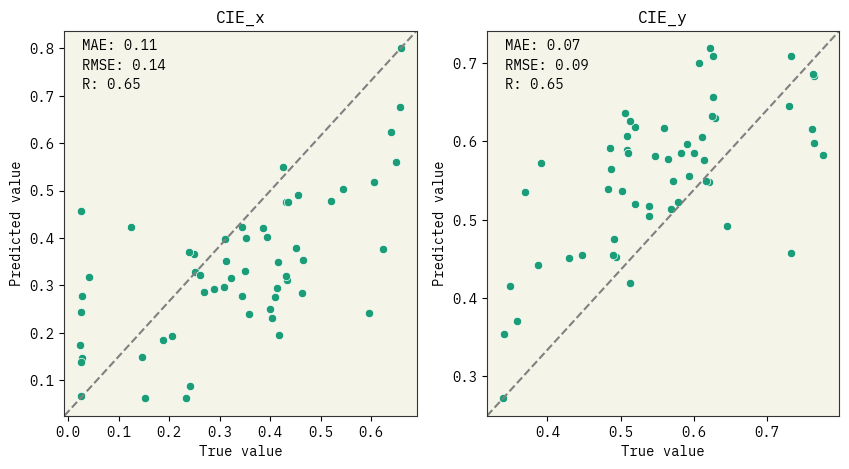

In [151]:
#flatten the lists
# flatten_y_CIE_x = [item.to_list() for sublist in y_CIE_x for item in sublist]
# flatten_y_CIE_y = [item.to_list() for sublist in y_CIE_y for item in sublist]


# flatten_y_hats_CIE_x = [item for sublist in y_hats_CIE_x for item in sublist]
# flatten_y_hats_CIE_y = [item for sublist in y_hats_CIE_y for item in sublist]

#make scatter plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs[0].set_title("CIE_x")
sns.scatterplot(x=flatten_y_CIE_x, y=np.hstack(flatten_y_hats_CIE_x), ax=axs[0], color='C0')
axs[0].set_xlabel("True value")
axs[0].set_ylabel("Predicted value")
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
# axs[0].errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs[0].text(0.05, 0.95, f"MAE: {mae(flatten_y_CIE_x, flatten_y_hats_CIE_x):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.90, f"RMSE: {rmse(np.array(flatten_y_CIE_x), np.array(flatten_y_hats_CIE_x)):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.85, f"R: {np.corrcoef(flatten_y_CIE_x, flatten_y_hats_CIE_x)[0, 1]:.2f}", transform=axs[0].transAxes)

axs[1].set_title("CIE_y")
sns.scatterplot(x=flatten_y_CIE_y, y=np.hstack(flatten_y_hats_CIE_y), ax=axs[1], color='C0')
axs[1].set_xlabel("True value")
axs[1].set_ylabel("Predicted value")

axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
# axs[1].errorbar(x=y_2, y=[yi.mean() for yi in yhat_2], yerr=[yi.std() for yi in yhat_2], fmt='o', color='gray', alpha=0.2)
axs[1].text(0.05, 0.95, f"MAE: {mae(flatten_y_CIE_y, flatten_y_hats_CIE_y):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.90, f"RMSE: {rmse(np.array(flatten_y_CIE_y), np.array(flatten_y_hats_CIE_y)):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.85, f"R: {np.corrcoef(flatten_y_CIE_y, flatten_y_hats_CIE_y)[0, 1]:.2f}", transform=axs[1].transAxes)


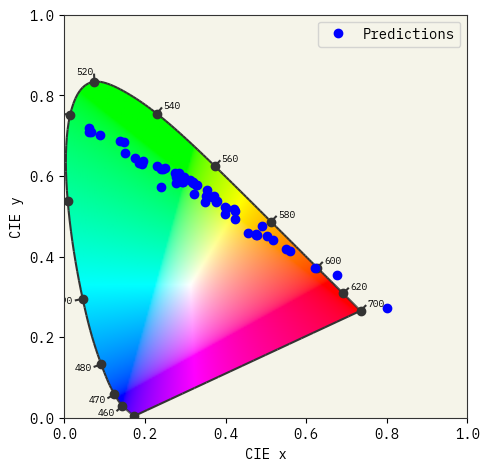

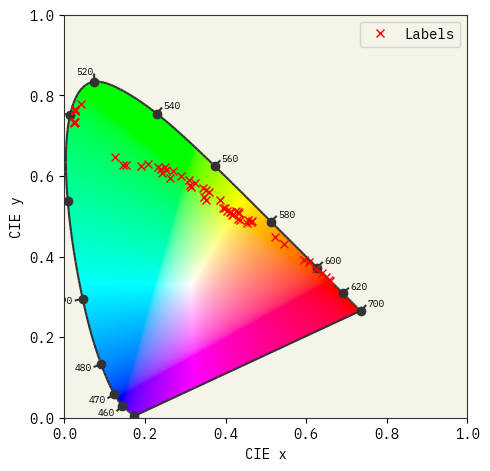

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='CIE x', ylabel='CIE y'>)

In [169]:
yhat_means_x = flatten_y_hats_CIE_x
yhat_means_y = flatten_y_hats_CIE_y
labels_x = flatten_y_CIE_x
labels_y = flatten_y_CIE_y

# Setting up the plot
plot_chromaticity_diagram_CIE1931(show=False, title = "")

# Plot predictions
# plt.title("")
plt.plot(yhat_means_x, yhat_means_y, "o", color="blue", label="Predictions")
plt.legend()
plt.show()
plot_chromaticity_diagram_CIE1931(show=False,title="")
# plt.title("")
# Plot labels
plt.plot(labels_x, labels_y, "x", color="red", label="Labels")

# Annotate
# for i, (px, py, lx, ly) in enumerate(zip(yhat_means_x, yhat_means_y, labels_x, labels_y)):
    # plt.annotate(f"P{i+1}", (px, py), color="blue")
    # plt.annotate(f"L{i+1}", (lx, ly), color="red")
    # if i >3:
        # break

# Add legend and render
plt.legend()
render(show=True, limits=(-0.1, 0.9, -0.1, 0.9), x_tighten=True, y_tighten=True)

### Baseline with Ax GPR

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random
import numpy as np
np.random.seed(0)
random.seed(0)

In [2]:
#Core libraries
import torch
import numpy as np
import pandas as pd
import gpytorch

#Ax library
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils.datasets import SupervisedDataset
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from ax.models.torch.botorch_modular.surrogate import Surrogate
# from botorch import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood, LeaveOneOutPseudoLikelihood, SumMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement
from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate, SurrogateSpec
from ax.models.torch.botorch_modular.utils import ModelConfig

#Deveper API
from ax import (
    ComparisonOp,
    ParameterType,
    RangeParameter,
    ChoiceParameter,
    FixedParameter,
    SearchSpace,
    Experiment,
    OutcomeConstraint,
    OrderConstraint,
    SumConstraint,
    OptimizationConfig,
    Objective,
    Metric,
    Runner,
    Data,
    Arm,
)
from ax.core import ObservationFeatures
#For Visualization Purposes
from ax.utils.notebook.plotting import render
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.slice import plot_slice



[WARNING 02-10 16:03:08] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [3]:
### This is how i figure base on a lot of conversation and trial and error that you can 
### initialize your model classes for use with Ax.dev framework. (e.g. speficying the likelihood directly in the __init__)
class ExactGPModel1(gpytorch.models.ExactGP, GPyTorchModel):
    
    _num_outputs = 1 

    def __init__(self, train_X, train_Y,**kwargs):
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood(), **kwargs)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=9))
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#matern models

class BaseGPMatern(gpytorch.models.ExactGP, GPyTorchModel):
    _num_outputs = 1 
    
    def __init__(self, train_X, train_Y, **kwargs):
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood(), **kwargs)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=9))
        self.to(train_X)
            
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

In [39]:
# Because we already have a warm start with raw data, we dont need SOBOL sampling to begin with. So we want to use BoTorch w qExpectedImprovement for sampling
# the mll_class can be either ExactMarginalLogLikelihood or LeaveOneOutPseudoLikelihood for our ExactGP models. The later is more stable.
def generate_strategy(): 
    gs=GenerationStrategy(
    steps=[
            GenerationStep(
                model=Models.BOTORCH_MODULAR,
                num_trials=-1,  # No limitation on how many trials should be produced from this step
                # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
                model_gen_kwargs={"max_retries": 10},
                model_kwargs={
                    "surrogate":Surrogate(surrogate_spec=SurrogateSpec(
                            model_configs=[
                                ModelConfig(
                                    # The model class to use
                                    botorch_model_class=BaseGPMatern,
                                    # Optional, MLL class with which to optimize model parameters
                                                    mll_class=LeaveOneOutPseudoLikelihood,
                                                    input_transform_classes=None,
                                                    ),
                                    # Optional, dictionary of keyword arguments to model constructor
                                    # model_options={}
                                    # Passing in `None` to disable the default set of input transforms
                                    # constructed in Ax, since the model doesn't support transforms.
                                    # input_transform_classes=None,
                                ])
            ),
                    "botorch_acqf_class": qExpectedImprovement,
                    },
                    
            ),
        ]
    )
    return gs
 

In [5]:
## Points to consider
#for the "choice" variables, add ordered = False 
# as parameter if you prefer one-hot encoding rather than ordinal encoding
# for more options look at Ax documentation on parameters and Trasformations (Transforms)
ax_parameters = [
    {
        "name": "Dimension1",
        "type": "range",
        "bounds": [12.0000,51.00000],
        "value_type":'float'
    },
    {
        "name": "Dimension2",
        "type": "range",
        "bounds": [6,26],
        "value_type": 'float'
    },
    {
        "name": "Dilution(OD)",
        "type": "range",
        "bounds": [0.12,0.465]
    },
    {   "name":"Nano_stock_vol",
        "type":"choice",
        "values": [0.25,0.5],

    },
    {
        "name": "Ag_acet_conc",
        "type": "choice",
        "values": [0.0007,0.006],

    },
     {
        "name": "Ag_acet_mass",
        "type": "choice",
        "values": [3.5,7.8,14.0],

     },
    {
        "name": "Doping%",
        "type": "range",
        "bounds": [0.1,10.0],
        "value_type": 'float'

    },
    {
        "name": "Time",
        "type": "choice",
        "values": [10.0,60.0,180.0],
        'value_type': 'float'
    },
    {
        "name": "Temperature",
        "type": "choice",
        "values": [0.0,25.0,50.0],
        "value_type": 'float',
    },

]



In [ ]:
#read corrected data wo baseline: data with CIE values
modified_features = pd.read_csv('Data/processed_data.csv', sep=",")
print(modified_features.columns)
modified_features = modified_features[['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'Doping(%)',  'Time(min)',
       'Temperature(C)', 'CIE_x', 'CIE_y','QY']]
#remove if QY is -1
modified_features = modified_features[modified_features['QY'] != -1]
modified_features.head()

Index(['Dimension1(nm)', 'Dimension2(nm)', 'OD', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'MeOH_vol(mL)', 'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)',
       'Temperature(C)', 'Experiment', 'Peak1', 'Peak2', 'Area1', 'Area2',
       'Pre-QY', 'QY', 'QY_peak1', 'QY_peak2', 'Fl_Wavelengths',
       'Fluorescence', 'Fluorescence_norm', 'Abs_Wavelengths', 'Absorbance',
       'Absorbance_norm', 'CIE_x', 'CIE_y'],
      dtype='object')


Dimension1(nm)  Dimension2(nm)  Dilution(%)  Nano_stock_vol(mL)  AgConc(M)  \
0            18.8           14.04        0.175                0.25     0.0060   
1            18.8           14.04        0.175                0.25     0.0060   
2            18.8           14.04        0.175                0.25     0.0060   
3            18.8           14.04        0.175                0.25     0.0060   
4            18.8           14.04        0.175                0.25     0.0007   

   AgMass(mg)  Doping(%)  Time(min)  Temperature(C)     CIE_x     CIE_y  \
0         7.8       1.25         60              25  0.521398  0.447538   
1         7.8       2.50         60              25  0.650174  0.348096   
2         7.8       5.00         60              25  0.639103  0.358419   
3         7.8      10.00         60              25  0.658767  0.339308   
4         3.5       0.25         60              25  0.041857  0.777612   

         QY  
0  0.355697  
1  0.243591  
2  0.245067  
3  0.089776  
4  0.276434

In [95]:
#check types of each column
modified_features.columns = ['Dimension1', 'Dimension2', 'Dilution(OD)',
       'Nano_stock_vol', 'Ag_acet_conc', 'Ag_acet_mass',
       'Doping%',  'Time',
       'Temperature', 'CIE_x', 'CIE_y','QY']

In [96]:
def train_ax_client(client,features,labels,label='CIE_x'):
    for i in range(len(features)):
        client.attach_trial(parameters = {ax_parameters[j]['name']: features.values[i][j] for j in range(9)})
        client.complete_trial(trial_index = i, raw_data = {f"{label}": labels[label].values[i]})

    #fit the model
    AxClient.fit_model(client)

    return client

In [99]:
ax_client_QY = AxClient(generation_strategy=generate_strategy(), random_seed=12345)
ax_client_CIE_x = AxClient(generation_strategy=generate_strategy(), random_seed=12345)
ax_client_CIE_y = AxClient(generation_strategy=generate_strategy(), random_seed=12345   )
#create experiments

ax_client_QY.create_experiment(parameters = ax_parameters, 
              objectives= {"QY":ObjectiveProperties(minimize=False)},)
ax_client_CIE_x.create_experiment(parameters = ax_parameters,
              objectives= {"CIE_x":ObjectiveProperties(minimize=False)},)
ax_client_CIE_y.create_experiment(parameters = ax_parameters,
              objectives= {"CIE_y":ObjectiveProperties(minimize=False)},)


ax_client_CIE_x = train_ax_client(ax_client_CIE_x,modified_features[['Dimension1', 'Dimension2', 'Dilution(OD)',
       'Nano_stock_vol', 'Ag_acet_conc', 'Ag_acet_mass',
       'Doping%',  'Time',
       'Temperature']],modified_features,'CIE_x')
ax_client_CIE_y = train_ax_client(ax_client_CIE_y,modified_features[['Dimension1', 'Dimension2', 'Dilution(OD)',
         'Nano_stock_vol', 'Ag_acet_conc', 'Ag_acet_mass',
         'Doping%',  'Time',
#          'Temperature']],modified_features,'CIE_y')
# ax_client_QY = train_ax_client(ax_client_QY,modified_features[['Dimension1', 'Dimension2', 'Dilution(OD)',
#             'Nano_stock_vol', 'Ag_acet_conc', 'Ag_acet_mass',
#             'Doping%',  'Time',
#             'Temperature']],modified_features,'QY')

#save the models

#cross validate the models

cv_resultsQY = cross_validate(ax_client_QY.generation_strategy.model,)
render(interact_cross_validation(cv_resultsQY, show_context=True,autoset_axis_limits=False))

cv_resultsCIE_x = cross_validate(ax_client_CIE_x.generation_strategy.model,)
render(interact_cross_validation(cv_resultsCIE_x, show_context=True,autoset_axis_limits=False))

cv_resultsCIE_y = cross_validate(ax_client_CIE_y.generation_strategy.model,)
render(interact_cross_validation(cv_resultsCIE_y, show_context=True,autoset_axis_limits=False))


SyntaxError: '[' was never closed (2019717265.py, line 18)

In [100]:
indexes = np.arange(len(modified_features))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)
folds = np.array_split(indexes, 5)
QY_hats = []
QY_labels = []
CIE_x_hats = []
CIE_y_hats = []
CIE_x_labels = []
CIE_y_labels = []
for i in range(5):
    print(f"Fold {i+1}")
    test_indexes = folds[i]
    train_indexes = np.concatenate([folds[j] for j in range(5) if j != i])
    test_df = modified_features.iloc[test_indexes]
    train_df = modified_features.iloc[train_indexes]

    test_df_features = test_df[['Dimension1', 'Dimension2', 'Dilution(OD)',
       'Nano_stock_vol', 'Ag_acet_conc', 'Ag_acet_mass',
       'Doping%',  'Time','Temperature']]
    test_df_labels = test_df[['CIE_x', 'CIE_y']]

    train_df_features = train_df[['Dimension1', 'Dimension2', 'Dilution(OD)',
       'Nano_stock_vol', 'Ag_acet_conc', 'Ag_acet_mass',
       'Doping%',  'Time','Temperature']]
    train_df_labels = train_df[['CIE_x', 'CIE_y','QY']]
    gs1 = generate_strategy()
    # gs2 = generate_strategy()
    ax_client_QY = AxClient(generation_strategy = gs1)
    ax_client_QY.create_experiment(parameters = ax_parameters, 
                            objectives= {"QY":ObjectiveProperties(minimize=False)},)
    try:
      ax_client_QY = train_ax_client(ax_client_QY,train_df_features,train_df_labels,label='QY')
      cv_resultsQY = cross_validate(ax_client_QY.generation_strategy.model,)
      render(interact_cross_validation(cv_resultsQY, show_context=True,autoset_axis_limits=False))
    except:
      continue
    # ax_client_CIEy = AxClient(generation_strategy = gs1)
    # ax_client_CIEx = AxClient(generation_strategy = gs2)
    # ax_client_CIEy.create_experiment(parameters = ax_parameters, 
                            # objectives= {"CIE_y":ObjectiveProperties(minimize=False)},)
                            # tracking_metric_names = ["f"])  #we want to maximze f, but it shouldnt matter
    # ax_client_CIEx.create_experiment(parameters = ax_parameters, 
                            # objectives= {"CIE_x":ObjectiveProperties(minimize=False)},)
    # try:                                                                                    # f = QT*AUC2 
      # ax_client_CIEx = train_ax_client(ax_client_CIEx,train_df_features,train_df_labels,label='CIE_x')
      # cv_resultsx = cross_validate(ax_client_CIEx.generation_strategy.model,)
      # render(interact_cross_validation(cv_resultsx, show_context=True,autoset_axis_limits=False))
    # except:
      # continue
    # 
    # try:
      # ax_client_CIEy = train_ax_client(ax_client_CIEy,train_df_features,train_df_labels,label='CIE_y')
      # cv_resultsy = cross_validate(ax_client_CIEy.generation_strategy.model,)
      # render(interact_cross_validation(cv_resultsy, show_context=True,autoset_axis_limits=False))
    # except:
      # continue
    #predicting the values
    #convert test_features to torch.Tensor
    # test_df_features = torch.tensor(test_df_features.values, dtype=torch.float)
    # preds_CIE_x = ax_client_CIEx.generation_strategy.model.model.predict(test_df_features)
    # preds_CIE_y = ax_client_CIEy.generation_strategy.model.model.predict(test_df_features)
    # CIE_x_hats.append(preds_CIE_x)
    # CIE_y_hats.append(preds_CIE_y)
    # CIE_x_labels.append(test_df_labels['CIE_x'])
    # CIE_y_labels.append(test_df_labels['CIE_y'])

    # print(f"Predicted CIE_x: {preds_CIE_x}| Labels:{test_df_labels['CIE_x']}")
    # print(f"  Predicted CIE_y: {preds_CIE_y}| Labels:{test_df_labels['CIE_y']}")
    test_df_features = torch.tensor(test_df_features.values, dtype=torch.float)
    print("Features:",test_df_features)
    preds_QY = ax_client_QY.generation_strategy.model.model.predict(test_df_features)
    QY_hats.append(preds_QY)
    QY_labels.append(test_df_labels)
    print(f"Predicted QY: {preds_QY}| Labels:{test_df_labels}")
    
    

[INFO 02-12 15:53:01] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-12 15:53:01] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Dilution(OD). If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-12 15:53:01] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Nano_stock_vol. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/ax/service/utils/instantiation.py:258: AxParameterWarning:

`is_ordered` is not specified for `ChoiceParameter` "Nano_stock_vol". Defaulting to `True`  since there are exactly two choi

Fold 1


[INFO 02-12 15:53:01] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 35.0, 'Dimension2': 15.0, 'Dilution(OD)': 0.21199999999999999, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.00069999999999999999, 'Ag_acet_mass': 3.5, 'Doping%': 3.0, 'Time': 60.0, 'Temperature': 25.0}] as trial 14.
[INFO 02-12 15:53:01] ax.service.ax_client: Completed trial 14 with data: {'QY': (0.209649, None)}.
[INFO 02-12 15:53:01] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 36.270000000000003, 'Dimension2': 6.5199999999999996, 'Dilution(OD)': 0.12, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.00069999999999999999, 'Ag_acet_mass': 3.5, 'Doping%': 3.0, 'Time': 10.0, 'Temperature': 50.0}] as trial 15.
[INFO 02-12 15:53:01] ax.service.ax_client: Completed trial 15 with data: {'QY': (0.527085, None)}.
[INFO 02-12 15:53:01] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 39.159999999999997, 'Dimension2': 6.3399999999999999, 'Dilution(OD)': 0.419999999999999

Fold 2


[INFO 02-12 15:53:03] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 31.629999999999999, 'Dimension2': 13.800000000000001, 'Dilution(OD)': 0.12, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.0060000000000000001, 'Ag_acet_mass': 14.0, 'Doping%': 1.0, 'Time': 60.0, 'Temperature': 25.0}] as trial 5.
[INFO 02-12 15:53:03] ax.service.ax_client: Completed trial 5 with data: {'QY': (0.306997, None)}.
[INFO 02-12 15:53:03] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 39.159999999999997, 'Dimension2': 6.3399999999999999, 'Dilution(OD)': 0.41999999999999998, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.0060000000000000001, 'Ag_acet_mass': 14.0, 'Doping%': 5.0, 'Time': 60.0, 'Temperature': 25.0}] as trial 6.
[INFO 02-12 15:53:03] ax.service.ax_client: Completed trial 6 with data: {'QY': (0.457926, None)}.
[INFO 02-12 15:53:03] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 31.629999999999999, 'Dimension2': 13.800000000000001, 'Dilution

Fold 3


[INFO 02-12 15:53:05] ax.service.ax_client: Completed trial 11 with data: {'QY': (0.081949, None)}.
[INFO 02-12 15:53:05] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 36.270000000000003, 'Dimension2': 6.5199999999999996, 'Dilution(OD)': 0.12, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.00069999999999999999, 'Ag_acet_mass': 3.5, 'Doping%': 3.0, 'Time': 10.0, 'Temperature': 25.0}] as trial 12.
[INFO 02-12 15:53:05] ax.service.ax_client: Completed trial 12 with data: {'QY': (0.344371, None)}.
[INFO 02-12 15:53:05] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 18.800000000000001, 'Dimension2': 14.039999999999999, 'Dilution(OD)': 0.17499999999999999, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.00069999999999999999, 'Ag_acet_mass': 3.5, 'Doping%': 1.75, 'Time': 60.0, 'Temperature': 25.0}] as trial 13.
[INFO 02-12 15:53:05] ax.service.ax_client: Completed trial 13 with data: {'QY': (0.175461, None)}.
[INFO 02-12 15:53:05] ax.core.experiment: Attache

Fold 4


[INFO 02-12 15:53:06] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 18.800000000000001, 'Dimension2': 14.039999999999999, 'Dilution(OD)': 0.17499999999999999, 'Nano_stock_vol': 0.25, 'Ag_acet_conc': 0.00069999999999999999, 'Ag_acet_mass': 3.5, 'Doping%': 2.0, 'Time': 60.0, 'Temperature': 25.0}] as trial 2.
[INFO 02-12 15:53:07] ax.service.ax_client: Completed trial 2 with data: {'QY': (0.139167, None)}.
[INFO 02-12 15:53:07] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 31.629999999999999, 'Dimension2': 13.800000000000001, 'Dilution(OD)': 0.12, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.00069999999999999999, 'Ag_acet_mass': 3.5, 'Doping%': 0.75, 'Time': 60.0, 'Temperature': 25.0}] as trial 3.
[INFO 02-12 15:53:07] ax.service.ax_client: Completed trial 3 with data: {'QY': (0.214765, None)}.
[INFO 02-12 15:53:07] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 45.770000000000003, 'Dimension2': 7.29, 'Dilution(OD)': 0.260

Fold 5


[INFO 02-12 15:53:08] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 31.629999999999999, 'Dimension2': 13.800000000000001, 'Dilution(OD)': 0.12, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.0060000000000000001, 'Ag_acet_mass': 14.0, 'Doping%': 0.5, 'Time': 60.0, 'Temperature': 25.0}] as trial 7.
[INFO 02-12 15:53:08] ax.service.ax_client: Completed trial 7 with data: {'QY': (0.407964, None)}.
[INFO 02-12 15:53:08] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 35.0, 'Dimension2': 15.0, 'Dilution(OD)': 0.21199999999999999, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.00069999999999999999, 'Ag_acet_mass': 3.5, 'Doping%': 1.0, 'Time': 60.0, 'Temperature': 25.0}] as trial 8.
[INFO 02-12 15:53:08] ax.service.ax_client: Completed trial 8 with data: {'QY': (0.312704, None)}.
[INFO 02-12 15:53:08] ax.core.experiment: Attached custom parameterizations [{'Dimension1': 18.800000000000001, 'Dimension2': 14.039999999999999, 'Dilution(OD)': 0.17499999999999999, 

Text(0.05, 0.9, 'RMSE: 0.23')

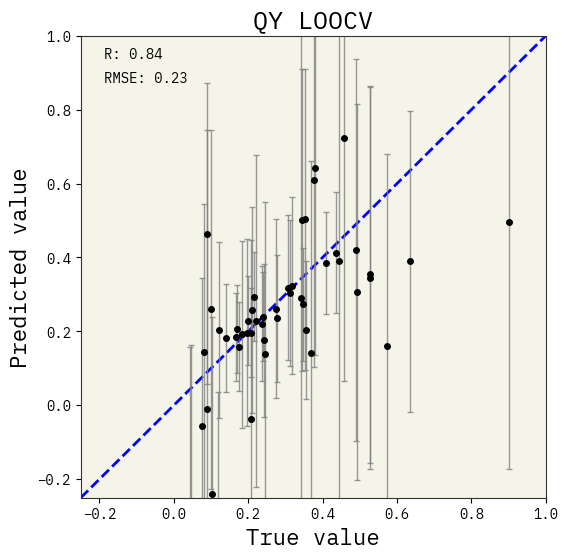

In [88]:
cv = cross_validate(ax_client_QY.generation_strategy.model)
y_true = np.stack([cv_.observed.data.means for cv_ in cv]).ravel()
y_saas_mean = np.stack([cv_.predicted.means for cv_ in cv]).ravel()
y_saas_std = np.stack(
    [np.sqrt(np.diag(cv_.predicted.covariance)) for cv_ in cv]
).ravel()

# Cross-validation plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
min_val, max_val = -0.25, 1
ax.plot([min_val, max_val], [min_val, max_val], "b--", lw=2)
markers, caps, bars = ax.errorbar(
    y_true,
    y_saas_mean,
    yerr=1.96 * y_saas_std,
    fmt=".",
    capsize=2,
    elinewidth=1.0,
    ms=8,
    c="k",
    ecolor="gray",
)
[bar.set_alpha(0.8) for bar in bars]
[cap.set_alpha(0.8) for cap in caps]
ax.set_xlim([min_val, max_val])
ax.set_ylim([min_val, max_val])
ax.set_xlabel("True value", fontsize=16)
ax.set_ylabel("Predicted value", fontsize=16)
#add title 
ax.set_title("QY LOOCV", fontsize=18)
#add correlation coefficient score and rmse 
ax.text(0.05, 0.95, f"R: {np.corrcoef(y_true, y_saas_mean)[0, 1]:.2f}", transform=ax.transAxes)
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))
ax.text(0.05, 0.90, f"RMSE: {rmse(y_true, y_saas_mean):.2f}", transform=ax.transAxes)

# ax.grid(True)

In [106]:
cv[0].observed.features

ObservationFeatures(parameters={'Dimension1': 31.63, 'Dimension2': 13.8, 'Dilution(OD)': 0.12, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.0007, 'Ag_acet_mass': 3.5, 'Doping%': 5.0, 'Time': 60.0, 'Temperature': 25.0}, trial_index=21)

In [108]:
cv1[0].observed.features

ObservationFeatures(parameters={'Dimension1': 36.27, 'Dimension2': 6.52, 'Dilution(OD)': 0.12, 'Nano_stock_vol': 0.5, 'Ag_acet_conc': 0.0007, 'Ag_acet_mass': 3.5, 'Doping%': 10.0, 'Time': 10.0, 'Temperature': 25.0}, trial_index=37)

In [109]:
#organize the data based on the trial_index of each cv object
y_true = np.stack([cv_.observed.data.means for cv_ in cv]).ravel()
y_saas_mean = np.stack([cv_.predicted.means for cv_ in cv]).ravel()
y_saas_std = np.stack(
    [np.sqrt(np.diag(cv_.predicted.covariance)) for cv_ in cv]
).ravel()

#get the trial index for each cv object
trial_index_x= [cv_.observed.features.trial_index for cv_ in cv]
trial_index_y = [cv_.observed.features.trial_index for cv_ in cv1]

Text(0.05, 0.9, 'RMSE: 0.12')

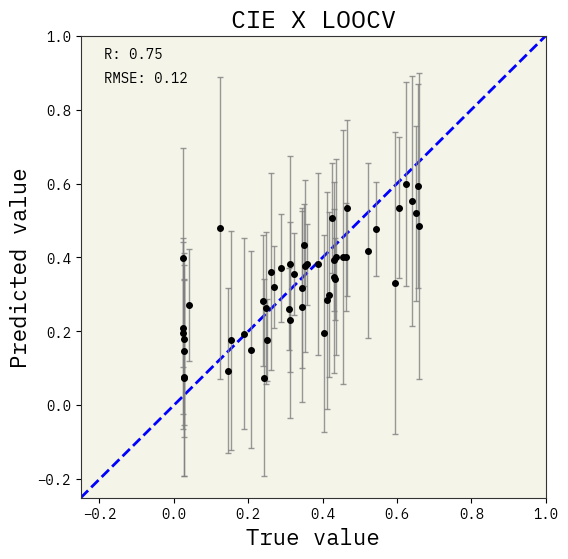

In [ ]:
cv = cross_validate(ax_client_CIE_x.generation_strategy.model)
y_true = np.stack([cv_.observed.data.means for cv_ in cv]).ravel()
y_saas_mean = np.stack([cv_.predicted.means for cv_ in cv]).ravel()
y_saas_std = np.stack(
    [np.sqrt(np.diag(cv_.predicted.covariance)) for cv_ in cv]
).ravel()
trial_index_x = [cv_.observed.features.trial_index for cv_ in cv]
# Cross-validation plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
min_val, max_val = -0.25, 1
ax.plot([min_val, max_val], [min_val, max_val], "b--", lw=2)
markers, caps, bars = ax.errorbar(
    y_true,
    y_saas_mean,
    yerr=1.96 * y_saas_std,
    fmt=".",
    capsize=2,
    elinewidth=1.0,
    ms=8,
    c="k",
    ecolor="gray",
)
[bar.set_alpha(0.8) for bar in bars]
[cap.set_alpha(0.8) for cap in caps]
ax.set_xlim([min_val, max_val])
ax.set_ylim([min_val, max_val])
ax.set_xlabel("True value", fontsize=16)
ax.set_ylabel("Predicted value", fontsize=16)
#add title 
ax.set_title("CIE X LOOCV", fontsize=18)
#add correlation coefficient score and rmse 
ax.text(0.05, 0.95, f"R: {np.corrcoef(y_true, y_saas_mean)[0, 1]:.2f}", transform=ax.transAxes)
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))
ax.text(0.05, 0.90, f"RMSE: {rmse(y_true, y_saas_mean):.2f}", transform=ax.transAxes)

# ax.grid(True)

Text(0.05, 0.9, 'RMSE: 0.07')

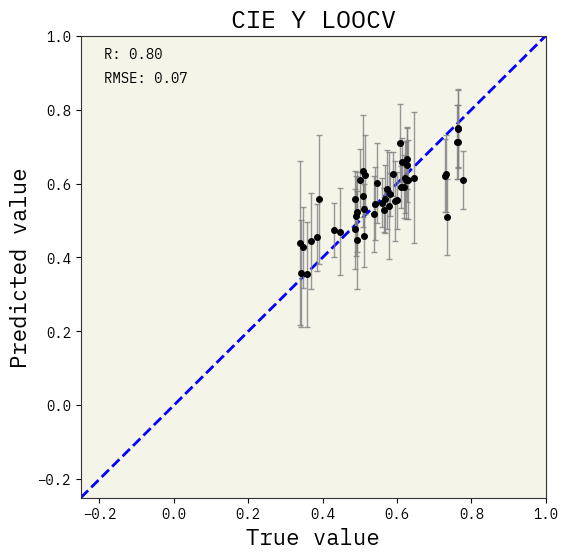

In [112]:
cv1 = cross_validate(ax_client_CIE_y.generation_strategy.model)
y_true = np.stack([cv_.observed.data.means for cv_ in cv1]).ravel()
y_saas_mean = np.stack([cv_.predicted.means for cv_ in cv1]).ravel()
y_saas_std = np.stack(
    [np.sqrt(np.diag(cv_.predicted.covariance)) for cv_ in cv1]
).ravel()

# Cross-validation plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
min_val, max_val = -0.25, 1
ax.plot([min_val, max_val], [min_val, max_val], "b--", lw=2)
markers, caps, bars = ax.errorbar(
    y_true,
    y_saas_mean,
    yerr=1.96 * y_saas_std,
    fmt=".",
    capsize=2,
    elinewidth=1.0,
    ms=8,
    c="k",
    ecolor="gray",
)
[bar.set_alpha(0.8) for bar in bars]
[cap.set_alpha(0.8) for cap in caps]
ax.set_xlim([min_val, max_val])
ax.set_ylim([min_val, max_val])
ax.set_xlabel("True value", fontsize=16)
ax.set_ylabel("Predicted value", fontsize=16)
#add title 
ax.set_title("CIE Y LOOCV", fontsize=18)
#add correlation coefficient score and rmse 
ax.text(0.05, 0.95, f"R: {np.corrcoef(y_true, y_saas_mean)[0, 1]:.2f}", transform=ax.transAxes)
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))
ax.text(0.05, 0.90, f"RMSE: {rmse(y_true, y_saas_mean):.2f}", transform=ax.transAxes)

# ax.grid(True)

In [104]:
x_true

array([ 0.62461123,  0.02694148,  0.24029907,  0.02516399,  0.41605574,
        0.43608923,  0.65876742,  0.02444294,  0.26952103,  0.2486895 ,
        0.35850545,  0.4639325 ,  0.40361865,  0.28826612,  0.43153777,
        0.41082294,  0.14551183,  0.02716795,  0.31369069,  0.35170117,
        0.63910276,  0.30873864,  0.52139794,  0.34390597,  0.45548318,
        0.65715504,  0.4344144 ,  0.12470777,  0.1532759 ,  0.2620459 ,
        0.24242132,  0.32312039,  0.18882361,  0.42491172,  0.25137967,
        0.60566   ,  0.59541789,  0.43106013,  0.02623914,  0.04185684,
        0.46473877,  0.35095678,  0.38643428,  0.54483035,  0.02649846,
        0.31120552,  0.20661231,  0.02494756,  0.34534245,  0.65017364])

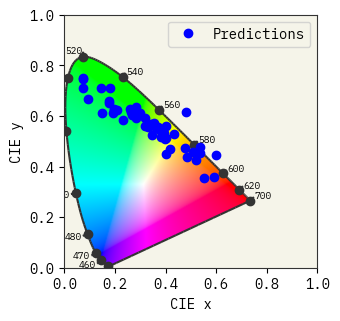

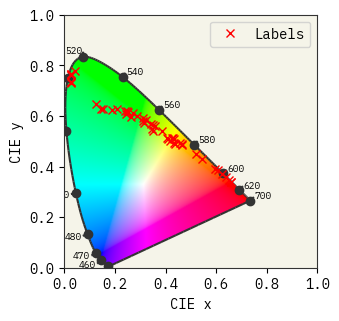

(<Figure size 350x350 with 1 Axes>, <Axes: xlabel='CIE x', ylabel='CIE y'>)

In [110]:
from colour.plotting import plot_chromaticity_diagram_CIE1931, render

cv = cross_validate(ax_client_CIE_y.generation_strategy.model)
y_true = np.stack([cv_.observed.data.means for cv_ in cv]).ravel()
y_saas_mean = np.stack([cv_.predicted.means for cv_ in cv]).ravel()
trial_index_y = [cv_.observed.features.trial_index for cv_ in cv]
cv = cross_validate(ax_client_CIE_x.generation_strategy.model)
x_true = np.stack([cv_.observed.data.means for cv_ in cv]).ravel()
x_saas_mean = np.stack([cv_.predicted.means for cv_ in cv]).ravel()
trial_index_x = [cv_.observed.features.trial_index for cv_ in cv]

#organize y_true and x_true based on the trial_index of each cv object
ordered_y_label= np.zeros(len(trial_index_y))
ordered_x_label = np.zeros(len(trial_index_x))
ordered_y_pred = np.zeros(len(trial_index_y))
ordered_x_pred = np.zeros(len(trial_index_x))

for i in range(len(trial_index_y)):
    ordered_y_label[trial_index_y[i]] = y_true[i]
    ordered_x_label[trial_index_x[i]] = x_true[i]

for i in range(len(trial_index_y)):
    ordered_y_pred[trial_index_y[i]] = y_saas_mean[i]
    ordered_x_pred[trial_index_x[i]] = x_saas_mean[i]





# Setting up the plot
plot_chromaticity_diagram_CIE1931(show=False, title = "")

# Plot predictions
# plt.title("")
plt.plot(ordered_x_pred, ordered_y_pred, "o", color="blue", label="Predictions")
plt.legend()
plt.show()
plot_chromaticity_diagram_CIE1931(show=False,title="")
# plt.title("")
# Plot labels
plt.plot(ordered_x_label, ordered_y_label, "x", color="red", label="Labels")

# Annotate
# for i, (px, py, lx, ly) in enumerate(zip(yhat_means_x, yhat_means_y, labels_x, labels_y)):
    # plt.annotate(f"P{i+1}", (px, py), color="blue")
    # plt.annotate(f"L{i+1}", (lx, ly), color="red")
    # if i >3:
        # break

# Add legend and render
plt.legend()
render(show=True, limits=(-0.1, 0.9, -0.1, 0.9), x_tighten=True, y_tighten=True)

In [54]:
test_df

Prompt     CIE_x     CIE_y
23  Stock nanoplatelets have dimensions 31.63 nm b...  0.544830  0.429875
36  Stock nanoplatelets have dimensions 36.27 nm b...  0.024443  0.730255
21  Stock nanoplatelets have dimensions 31.63 nm b...  0.624611  0.369494
19  Stock nanoplatelets have dimensions 31.63 nm b...  0.358505  0.559130
9   Stock nanoplatelets have dimensions 18.8 nm by...  0.434414  0.508303
39  Stock nanoplatelets have dimensions 36.27 nm b...  0.416056  0.501841
51  Stock nanoplatelets have dimensions 45.77 nm b...  0.311206  0.578537
3   Stock nanoplatelets have dimensions 18.8 nm by...  0.658767  0.339308
0   Stock nanoplatelets have dimensions 18.8 nm by...  0.521398  0.447538
53  Stock nanoplatelets have dimensions 45.77 nm b...  0.413361  0.509719
47  Stock nanoplatelets have dimensions 45.77 nm b...  0.399280  0.519576
44  Stock nanoplatelets have dimensions 45.77 nm b...  0.313691  0.571878

In [58]:
# system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat_1=[]
yhat_2=[]
y_1=[]
y_2=[]
for i in test_df.index:
  yhat_1.append(asktell_auc1.predict(df['Prompt'][i], system_message=system_message))
  yhat_2.append(asktell_auc2.predict(df['Prompt'][i], system_message=system_message))
  y_1.append(test_df['CIE_x'][i])
  y_2.append(test_df['CIE_y'][i])
  print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {test_df['CIE_x'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {test_df['CIE_y'][i]}")


0.40+/-0.07 : 0.544830347921 // 0.56+/-0.01 : 0.429874509168
0.18+/-0.18 : 0.0244429362424 // 0.61+/-0.01 : 0.730254605212
0.54+/-0.16 : 0.624611230116 // 0.38+/-0.08 : 0.369493877294
0.34+/-0.01 : 0.358505447264 // 0.52+/-0.05 : 0.559130304557
0.34+/-0.18 : 0.434414396086 // 0.56+/-0.00 : 0.508303464483
0.39+/-0.01 : 0.416055738574 // 0.57+/-0.05 : 0.501841015419
0.43+/-0.03 : 0.311205523361 // 0.58+/-0.06 : 0.578536969081
0.65+/-0.02 : 0.658767415803 // 0.33+/-0.01 : 0.339308124846
0.44+/-0.10 : 0.52139794011 // 0.44+/-0.05 : 0.447538420632
0.38+/-0.01 : 0.413361152959 // 0.54+/-0.02 : 0.509718861234
0.40+/-0.04 : 0.399279883489 // 0.58+/-0.08 : 0.519576459191
0.40+/-0.18 : 0.313690694308 // 0.56+/-0.10 : 0.571878429115


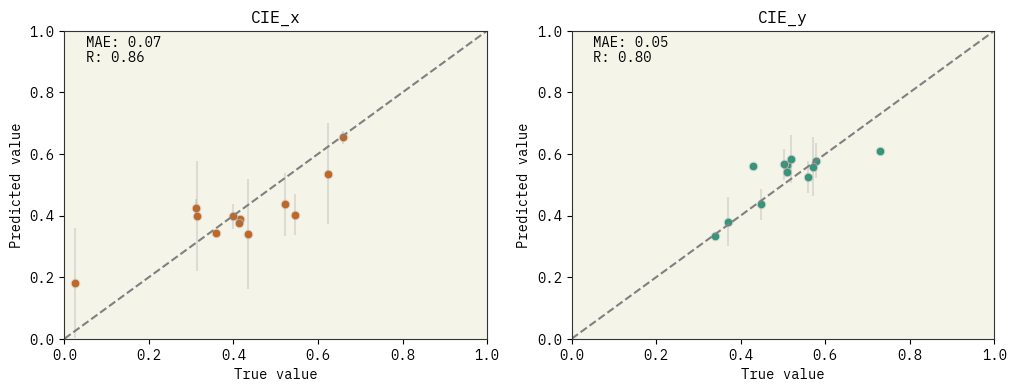

In [65]:
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs[0].set_title("CIE_x")
sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_1], ax=axs[0], color='C1')
axs[0].set_xlabel("True value")
axs[0].set_ylabel("Predicted value")
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
axs[0].errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs[0].text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array([yi.mean() for yi in yhat_1])):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.90, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat_1])[0, 1]:.2f}", transform=axs[0].transAxes)
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)

axs[1].set_title("CIE_y")
sns.scatterplot(x=y_2, y=[yi.mean() for yi in yhat_2], ax=axs[1], color='C0')
axs[1].set_xlabel("True value")
axs[1].set_ylabel("Predicted value")
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
axs[1].errorbar(x=y_2, y=[yi.mean() for yi in yhat_2], yerr=[yi.std() for yi in yhat_2], fmt='o', color='gray', alpha=0.2)
axs[1].text(0.05, 0.95, f"MAE: {mae(np.array(y_2), np.array([yi.mean() for yi in yhat_2])):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.90, f"R: {np.corrcoef(y_2, [yi.mean() for yi in yhat_2])[0, 1]:.2f}", transform=axs[1].transAxes)
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)

plt.show()

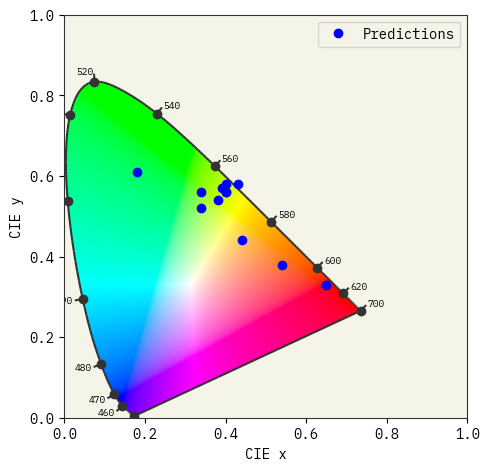

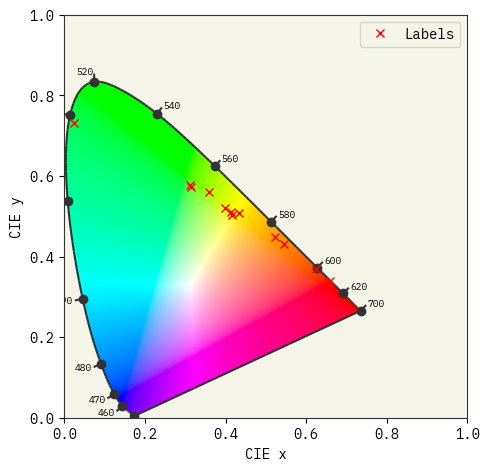

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='CIE x', ylabel='CIE y'>)

In [17]:
import matplotlib.pyplot as plt
from colour.plotting import plot_chromaticity_diagram_CIE1931, render

# Data from the user
yhat_means_x = [0.40, 0.18, 0.54, 0.34, 0.34, 0.39, 0.43, 0.65, 0.44, 0.38, 0.40, 0.40]
yhat_means_y = [0.56, 0.61, 0.38, 0.52, 0.56, 0.57, 0.58, 0.33, 0.44, 0.54, 0.58, 0.56]
labels_x = [0.544830347921, 0.0244429362424, 0.624611230116, 0.358505447264, 
            0.434414396086, 0.416055738574, 0.311205523361, 0.658767415803, 
            0.52139794011, 0.413361152959, 0.399279883489, 0.313690694308]
labels_y = [0.429874509168, 0.730254605212, 0.369493877294, 0.559130304557, 
            0.508303464483, 0.501841015419, 0.578536969081, 0.339308124846, 
            0.447538420632, 0.509718861234, 0.519576459191, 0.571878429115]

# Setting up the plot
plot_chromaticity_diagram_CIE1931(show=False, title = "")

# Plot predictions
# plt.title("")
plt.plot(yhat_means_x, yhat_means_y, "o", color="blue", label="Predictions")
plt.legend()
plt.show()
plot_chromaticity_diagram_CIE1931(show=False,title="")
# plt.title("")
# Plot labels
plt.plot(labels_x, labels_y, "x", color="red", label="Labels")

# Annotate
# for i, (px, py, lx, ly) in enumerate(zip(yhat_means_x, yhat_means_y, labels_x, labels_y)):
    # plt.annotate(f"P{i+1}", (px, py), color="blue")
    # plt.annotate(f"L{i+1}", (lx, ly), color="red")
    # if i >3:
        # break

# Add legend and render
plt.legend()
render(show=True, limits=(-0.1, 0.9, -0.1, 0.9), x_tighten=True, y_tighten=True)

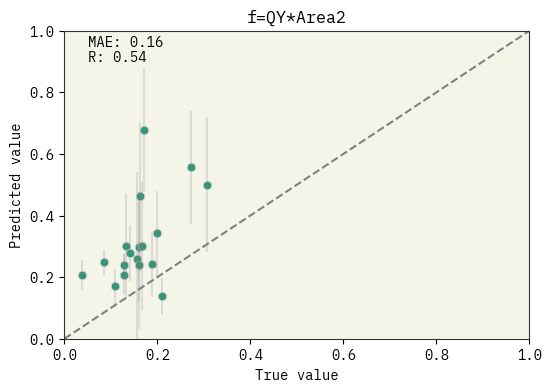

In [348]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs.set_title("f=QY*Area2")
sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_1], ax=axs, color='C0')
axs.set_xlabel("True value")
axs.set_ylabel("Predicted value")
axs.plot([0, 1], [0, 1], transform=axs.transAxes, ls="--", color="gray")
axs.errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs.text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array([yi.mean() for yi in yhat_1])):.2f}", transform=axs.transAxes)
axs.text(0.05, 0.90, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat_1])[0, 1]:.2f}", transform=axs.transAxes)
axs.set_xlim(0, 1)
axs.set_ylim(0, 1)
plt.show()

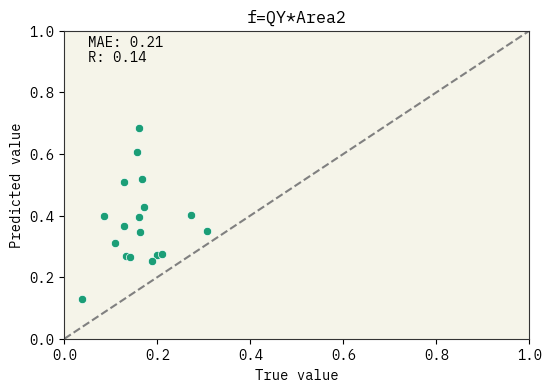

In [347]:
auc = np.array([0.68, 0.65, 0.47, 0.39, 0.63, 0.65, 0.69, 0.54, 0.87, 0.72, 0.70, 0.41, 0.33, 0.63, 0.63, 0.72, 0.45, 0.74])
p = np.array([0.40, 0.61, 0.57, 0.80, 0.63, 0.54, 0.88, 0.51, 0.46, 0.51, 0.74, 0.65, 0.39, 0.81, 0.55, 0.95, 0.56, 0.58])
y_pred = auc*p

fig, axs = plt.subplots(1, 1, figsize=(6, 4))
axs.set_title("f=QY*Area2")
sns.scatterplot(x=y_1, y=y_pred, ax=axs, color='C0')
axs.set_xlabel("True value")
axs.set_ylabel("Predicted value")
axs.plot([0, 1], [0, 1], transform=axs.transAxes, ls="--", color="gray")
axs.text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array(y_pred)):.2f}", transform=axs.transAxes)
axs.text(0.05, 0.90, f"R: {np.corrcoef(y_1, y_pred)[0, 1]:.2f}", transform=axs.transAxes)
axs.set_xlim(0, 1)
axs.set_ylim(0, 1)
plt.show()


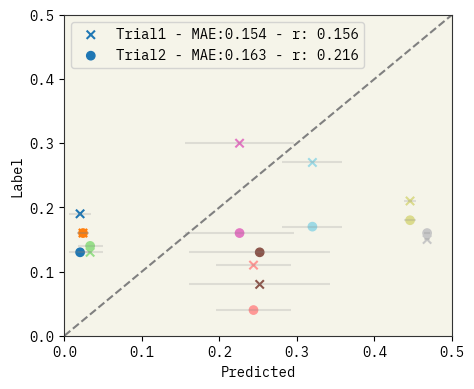

In [352]:
'''
Trial |             f = QY*AUC2                         |
        |  rep1 |   rep2| Predicted/designed |
1.    | 0.19  | 0.13 | 0.02024 +/- 0.01381|
2.    | 0.16  | 0.16 |  0.024 +/- 0.008.     |
3.    | 0.13  | 0.14 | 0.03320 +/- 0.0162 |
4.    | 0.11  | 0.04 |. 0.244 +/- 0.0484     |
5.    | 0.08  | 0.13 | 0.252 +/- 0.09130    |
6     | 0.30  | 0.16 |. 0.226 +/- 0.07          |
7.    | 0.15  | 0.16 |. 0.468 +/- 0.00399   |
8.    | 0.21  | 0.18 | 0.4460 +/- 0.008      |
9     | 0.27  | 0.17. | 0.32 +/- 0.0388         |
'''

t1 = np.array([
    0.19, 0.16, 0.13, 0.11, 0.08, 0.30, 0.15, 0.21, 0.27
])
t2 = np.array([
    0.13, 0.16, 0.14, 0.04, 0.13, 0.16, 0.16, 0.18, 0.17
])
predicted = np.array([
    0.02024, 0.024, 0.03320, 0.244, 0.252, 0.226, 0.468, 0.446, 0.32
])
std = np.array([
    0.01381, 0.008, 0.0162, 0.0484, 0.09130, 0.07, 0.00399, 0.008, 0.0388
])
mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))
corr = lambda a, b: np.corrcoef(a, b)[0, 1]

# plot parity plots with t1 and t2 vs predicted. Color by the position in the list
plt.figure()
plt.scatter(predicted, t1, c=range(len(t1)), label=f'Trial1 - MAE:{mae(predicted, t1):.3f} - r: {corr(predicted, t1):.3f}', marker='x')
plt.scatter(predicted, t2, c=range(len(t2)), label=f'Trial2 - MAE:{mae(predicted, t2):.3f} - r: {corr(predicted, t2):.3f}', marker='o')
plt.errorbar(predicted, t1, xerr=std, fmt='none', ecolor='gray', alpha=0.2)
plt.errorbar(predicted, t2, xerr=std, fmt='none', ecolor='gray', alpha=0.2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Label")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.legend()
plt.show()


[0.08929 0.064   0.1142  0.486   0.7085  0.576   0.48795 0.486   0.514  ]
[0.03923972 0.         0.07788984 0.65477114 1.         0.79441427
 0.65779674 0.65477114 0.69821567]


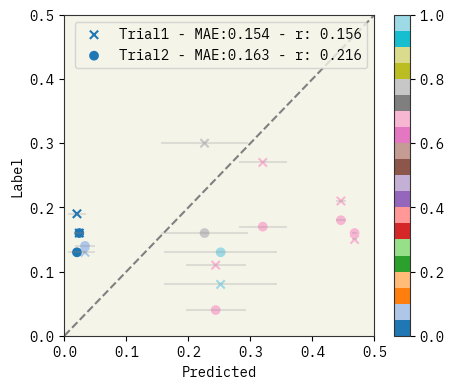

In [349]:
'''
Trial |             f = QY*AUC2                         |
        |  rep1 |   rep2| Predicted/designed |
1.    | 0.19  | 0.13 | 0.02024 +/- 0.01381|
2.    | 0.16  | 0.16 |  0.024 +/- 0.008.     |
3.    | 0.13  | 0.14 | 0.03320 +/- 0.0162 |
4.    | 0.11  | 0.04 |. 0.244 +/- 0.0484     |
5.    | 0.08  | 0.13 | 0.252 +/- 0.09130    |
6     | 0.30  | 0.16 |. 0.226 +/- 0.07          |
7.    | 0.15  | 0.16 |. 0.468 +/- 0.00399   |
8.    | 0.21  | 0.18 | 0.4460 +/- 0.008      |
9     | 0.27  | 0.17. | 0.32 +/- 0.0388         |
'''

t1 = np.array([
    0.19, 0.16, 0.13, 0.11, 0.08, 0.30, 0.15, 0.21, 0.27
])
t2 = np.array([
    0.13, 0.16, 0.14, 0.04, 0.13, 0.16, 0.16, 0.18, 0.17
])
predicted = np.array([
    0.02024, 0.024, 0.03320, 0.244, 0.252, 0.226, 0.468, 0.446, 0.32
])
std = np.array([
    0.01381, 0.008, 0.0162, 0.0484, 0.09130, 0.07, 0.00399, 0.008, 0.0388
])
mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))
corr = lambda a, b: np.corrcoef(a, b)[0, 1]

acq = predicted + 5*std
print(acq)
acq = (acq - acq.min())/(acq.max() - acq.min())
print(acq)

# plot parity plots with t1 and t2 vs predicted. Color by the position in the list
plt.figure()
# select the color palette to maximize color gradient on plt
plt.set_cmap('tab20')
plt.scatter(predicted, t1, c=acq, label=f'Trial1 - MAE:{mae(predicted, t1):.3f} - r: {corr(predicted, t1):.3f}', marker='x')
plt.scatter(predicted, t2, c=acq, label=f'Trial2 - MAE:{mae(predicted, t2):.3f} - r: {corr(predicted, t2):.3f}', marker='o')
plt.errorbar(predicted, t1, xerr=std, fmt='none', ecolor='gray', alpha=0.2)
plt.errorbar(predicted, t2, xerr=std, fmt='none', ecolor='gray', alpha=0.2)
plt.colorbar()
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Label")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.legend()
plt.show()


## Testing prediction

In [96]:
df = pd.read_csv('Data/procedures_new.tsv', sep="\t")
prompts = df['prompt'].tolist()
labels_f = df['obj_f'].to_list()

In [97]:
import numpy as np
indexes = np.arange(len(prompts))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)

train_indexes = indexes[:int(split*len(indexes))]
test_indexes = indexes[int(split*len(indexes)):]

In [98]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7,
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
else:
    inv_system_message = ""

for i in train_indexes:
  if labels_f[i] >= 0:
    asktell.tell(prompts[i], labels_f[i])

In [ ]:
yhat=[]
y=[]
for i in test_indexes:
  yhat.append(asktell.predict(prompts[i] , system_message=""))
  y.append(labels_f[i]) 

In [ ]:
for i in test_indexes:
  print(f"{prompts[i]} => {labels_f[i]}")

# [f"{i.mean():.2f}" for i in yhat], y

In [ ]:
def rmse(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.mean((a - b)**2))

sum = 0
print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
n = 0
for ihat, i in zip(yhat, y):
  n+=1
  mae = abs(ihat.mean()-i)
  print(f"| {ihat.mean():^10.2f}+/-{ihat.std():^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
  sum += mae
print(f"\n{'RMSE: ':>20s}{rmse([ihat.mean() for ihat in yhat], y):<18.2f}")

import matplotlib.pyplot as plt
yhat_mean = [ihat.mean() for ihat in yhat]
y_plot    = np.array(y)[np.where(np.array(yhat_mean) <= 1)]
yhat_plot = np.array(yhat_mean)[np.where(np.array(yhat_mean) <= 1)]
yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(yhat_mean) <= 1)]
plt.figure(figsize=(6, 4))
plt.xlabel('Experimental outcome')
plt.ylabel('Predicted outcome')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('LLM prediction: f = QY * AUC2')
plt.plot((0,0.4), (0,0.4), '--')
plt.text(0.75, 0.90, f"RMSE: {rmse(y_plot, yhat_plot):.2f}", fontsize=12, transform=plt.gca().transAxes)
plt.show()

## Bayesian optimization

In [26]:
proc_list = pd.read_csv('Data/procedures_prompts.tsv', sep='\t')
prompts, labels_f = proc_list['prompt'].tolist(), proc_list['obj_f'].tolist()

pool_type = "processed"
pool_list = pd.read_csv(f"Data/pools_pre{pool_type}.txt", sep=";",header=None)
# pool = cloudpickle.load(open(f'Data/pool_{pool_type}.pkl', 'rb'))
pool = bolift.Pool(pool_list[0].to_list())


In [27]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
    print("Loaded system message")
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
    print("Loaded inv system message")
else:
    inv_system_message = ""

print(pool)

for p,l in zip(prompts, labels_f):
  asktell.tell(p, float(l))
  try:
    pool.choose(p)
  except:
    continue

print(pool)

Loaded system message
Loaded inv system message
Pool of 2592 items with 0 selected
Pool of 2592 items with 0 selected


In [28]:
max(labels_f)

0.7273897437345833

In [33]:
selected = asktell.ask(pool, aq_fxn="expected_improvement", k=5, inv_filter=15, aug_random_filter=1, inv_system_message=inv_system_message, system_message=system_message)
i = 0
for prompt, p in zip(selected[0], asktell.predict(selected[0], system_message=system_message)):
    print(f"{prompt} => {p.mean():.4f} +/- {p.std():.4f}\n")
    # print(f"{i+1}: {prompt}")
    i+=1


Stock nanoplatelets have dimensions 25.59635 nm by 5.9023 nm and the optical density of 100x hexanes dilution of stock is 0.15% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.5633061444576635 mL of MeOH and 2.2253224577830655 mL of water. 5.0 % Ag doping requires 3.256582483967214 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes. => 0.7600 +/- 0.4525

Stock nanoplatelets have dimensions 25.59635 nm by 5.9023 nm and the optical density of 100x hexanes dilution of stock is 0.15% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.5633061444576635 mL of MeOH and 2.22532245778

Stock nanoplatelets have dimensions 23.54675 nm by 12.7644 nm and the optical density of 100x hexanes dilution of stock is 0.15% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 21.39733132483717 mL of MeOH and 8.558932529934868 mL of water. 5.0 % Ag doping requires 111.06503221215982 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes. => 0.4360 +/- 0.1725

Stock nanoplatelets have dimensions 25.59635 nm by 5.9023 nm and the optical density of 100x hexanes dilution of stock is 0.15% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.5633061444576635 mL of MeOH and 2.2253224577830655 mL of water. 2.0 % Ag doping requires 1.3026329935868857 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes. => 130.3560 +/- 259.8220

Stock nanoplatelets have dimensions 25.59635 nm by 5.9023 nm and the optical density of 100x hexanes dilution of stock is 0.15% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 3.5 mg of silver acetate in 2.496355321231003 mL of MeOH and 0.9985421284924011 mL of water. 2.0 % Ag doping requires 1.3026329935868857 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes. => 0.2600 +/- 0.1371

Stock nanoplatelets have dimensions 25.59635 nm by 5.9023 nm and the optical density of 100x hexanes dilution of stock is 0.15% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 3.5 mg of silver acetate in 2.496355321231003 mL of MeOH and 0.9985421284924011 mL of water. 2.0 % Ag doping requires 2.6052659871737713 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes. => 0.3600 +/- 0.1301

Stock nanoplatelets have dimensions 25.59635 nm by 5.9023 nm and the optical density of 100x hexanes dilution of stock is 0.15% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 3.5 mg of silver acetate in 2.496355321231003 mL of MeOH and 0.9985421284924011 mL of water. 2.0 % Ag doping requires 2.6052659871737713 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes. => 130.4200 +/- 259.7902


In [32]:
pool

Pool of 2592 items with 0 selected

In [ ]:
i=0
for prompt in selected[0]:
    print(f"{i+1}: {prompt}\n")
    i+=1

## New exp suggestion

In [17]:
proc_list = pd.read_csv('Data/procedures_prompts.tsv', sep='\t')
prompts, labels_f = proc_list['prompt'].tolist(), proc_list['obj_f'].tolist()

pool_type = "processed"
pool_list = pd.read_csv(f"Data/pools_pre{pool_type}.txt", sep=";",header=None)
# pool = cloudpickle.load(open(f'Data/pool_{pool_type}.pkl', 'rb'))
pool = bolift.Pool(pool_list[0].to_list())


In [25]:
pool_list[0].to_list()[-1]

'Stock nanoplatelets have dimensions 27.3818 nm by 8.75165 nm and the optical density of 100x hexanes dilution of stock is 0.3% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 14.0 mg of silver acetate in 85.58932529934869 mL of MeOH and 34.23573011973947 mL of water. 10.0 % Ag doping requires 354.2076159810427 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.'

In [13]:
pool_list

0
0     Stock nanoplatelets have dimensions 25.59635 n...
1     Stock nanoplatelets have dimensions 25.59635 n...
2     Stock nanoplatelets have dimensions 25.59635 n...
3     Stock nanoplatelets have dimensions 25.59635 n...
4     Stock nanoplatelets have dimensions 25.59635 n...
...                                                 ...
2587  Stock nanoplatelets have dimensions 27.3818 nm...
2588  Stock nanoplatelets have dimensions 27.3818 nm...
2589  Stock nanoplatelets have dimensions 27.3818 nm...
2590  Stock nanoplatelets have dimensions 27.3818 nm...
2591  Stock nanoplatelets have dimensions 27.3818 nm...

[2592 rows x 1 columns]

In [18]:
import os
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
    print("Loaded system message")
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
    print("Loaded inv system message")
else:
    inv_system_message = ""

print(pool)

for p,l in zip(prompts, labels_f):
  asktell.tell(p, float(l))
  try:
    pool.choose(p)
  except:
    continue

print(pool)

Loaded system message
Loaded inv system message
Pool of 2592 items with 0 selected
Pool of 2592 items with 0 selected


In [19]:
max(labels_f)

0.7273897437345833

In [20]:
propts = []
preds_mean = []
preds_std = []

for p in pool:
  propts.append(p)
  pred = asktell.predict(p, system_message=system_message)
  preds_mean.append(pred.mean())
  preds_std.append(pred.std())

predicted_pool = pd.DataFrame({
  'prompt': propts, 
  'pred_mean': preds_mean,
  'pred_std': preds_std
  })

KeyboardInterrupt: 

In [ ]:
predicted_pool.sort_values(by='pred_mean', ascending=True, inplace=True)
predicted_pool.to_csv(f'Data/predicted_pool_{pool_type}.txt', sep=';', index=False)
predicted_pool

prompt  pred_mean    pred_std
19    Stock nanoplatelets have dimensions 33.654 nm ...     0.0400    0.018974
675   Stock nanoplatelets have dimensions 30.594 nm ...     0.0419    0.018095
893   Stock nanoplatelets have dimensions 30.594 nm ...     0.0423    0.021810
26    Stock nanoplatelets have dimensions 33.654 nm ...     0.0440    0.026533
21    Stock nanoplatelets have dimensions 33.654 nm ...     0.0520    0.024000
...                                                 ...        ...         ...
1133  Stock nanoplatelets have dimensions 33.654 nm ...   520.1240  259.752000
2257  Stock nanoplatelets have dimensions 30.594 nm ...   520.1320  259.736000
816   Stock nanoplatelets have dimensions 33.654 nm ...   520.2240  259.552000
1132  Stock nanoplatelets have dimensions 33.654 nm ...   650.0000    0.140257
382   Stock nanoplatelets have dimensions 33.654 nm ...   650.0000    0.140257

[2588 rows x 3 columns]

In [354]:
filtered_pool = predicted_pool[predicted_pool['pred_mean'] < 1.0]
filtered_pool = filtered_pool[filtered_pool['pred_std'] < 0.1]

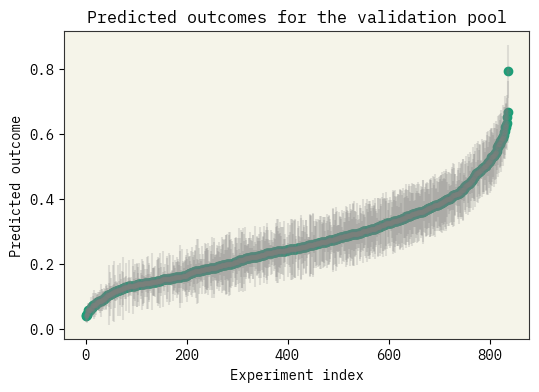

In [355]:
# plot filtered+pool means using pred_std as error
plt.figure(figsize=(6, 4))
plt.errorbar(range(len(filtered_pool)), filtered_pool['pred_mean'],yerr=filtered_pool['pred_std'], fmt='.', alpha=0.2, color='gray')
plt.scatter(range(len(filtered_pool)), filtered_pool['pred_mean'], label='Filtered pool')
plt.xlabel('Experiment index')
plt.ylabel('Predicted outcome')
plt.title('Predicted outcomes for the validation pool')
plt.show()

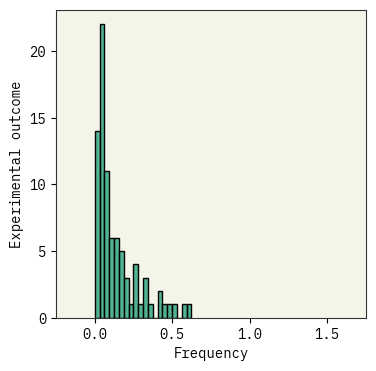

In [44]:
# make a histogram of labels_f using sns with the frequency in the axis x
# rotate the previous histogram so that the experimental outcome is in the y-axis. Also limit the range to [0,1]
plt.figure(figsize=(4, 4))
sns.histplot(labels_f, bins=20)
plt.ylabel('Experimental outcome')
plt.xlabel('Frequency')
# plt.title('Histogram of the experimental outcomes')
plt.xlim(-0.25, 1.75)
plt.show()

In [19]:
for l in [2,4,23, 950,953,947, 965,964,962]:
# for l in range(900, 950):
  print(f''' ------------ [index: {l}] ------------
  prompt: {filtered_pool.iloc[l]['prompt']}
  prediction: {filtered_pool.iloc[l]['pred_mean']} +/- {filtered_pool.iloc[l]['pred_std']}
  ''')

 ------------ [index: 2] ------------
  prompt: Stock nanoplatelets have dimensions 30.594 nm by 8.897 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 14.000 mg of silver acetate in 9.985 mL of MeOH and 3.994 mL of water. 2.000 % Ag doping requires 4.694 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
  prediction: 0.0423 +/- 0.021809630900132174
  
 ------------ [index: 4] ------------
  prompt: Stock nanoplatelets have dimensions 33.654 nm by 6.926 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution o

IndexError: single positional indexer is out-of-bounds